# IPO prediction 

Group 7

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from string import digits
import pandas_profiling
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

# Enable display of all columns
pd.options.display.max_columns = None

from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.linear_model    import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.pipeline        import Pipeline
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import roc_curve
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import f1_score, fbeta_score, precision_score, recall_score

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing   import OneHotEncoder

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

SEED = 1

# Custom Functions useful for plotting

In [2]:
def plot_confusion_matrix(cm, title='Confusion Matrix', ax=None):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    sns.heatmap(data=pd.DataFrame(cm), vmin=0, annot=True, square=True, cmap=plt.cm.Reds, fmt='g', ax=ax)
    if ax == None:
        plt.xlabel('Predicted label')
        plt.ylabel('Actual label')
        plt.title(title)
    else:
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('Actual label')
        ax.set_title(title)

In [3]:
def plot_roc(fpr, tpr, title='ROC Curve', note='', ax=None):
    """
    Function to plot an ROC curve in a consistent way.
    The fpr and tpr parameters can be created by the sklearn roc_curve() function.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    if ax == None:
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title(title)
        if note: plt.text(0.6, 0.2, note)
    else:
        ax.set_aspect('equal', 'box')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.plot(fpr, tpr)
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True positive rate')
        ax.set_title(title)
        if note: ax.set_text(0.6, 0.2, note)
    plt.show()

In [4]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False, ylim=[0,1.1], title='Validation Curve', ax=None):    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)

    lw = 2
    
    if ax == None: 
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.ylim(ylim)
        if x_logscale:
            plt.semilogx(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        else:
            plt.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)

        plt.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        if x_logscale:
            plt.semilogx(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        else:
            plt.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)

        plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        plt.legend(loc='best')
    else:
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_ylim(ylim)
        if x_logscale:
            ax.semilogx(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        else:
            ax.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)

        ax.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        if x_logscale:
            ax.semilogx(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        else:
            ax.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)

        ax.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        ax.legend(loc="best")

In [5]:
def plot_3rocs(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, model1, model2, model3):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr1, tpr1, label=model1)
    plt.plot(fpr2, tpr2, label=model2)
    plt.plot(fpr3, tpr3, label=model3)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.title('ROC Curves comparison')
    plt.show()

---------------

# Predictions using ML models

In [6]:
data_to_learn = pd.read_pickle('data_to_learn.pkl')
data_to_predict = pd.read_pickle('data_to_predict.pkl')

## Our approach for the predictions P1, ..., P3

To predict P1,...,P3, the following approach is taken:
1. Depending on the prediction at hand, **choose some ML models to test**
2. For each model, **cross-validate on the training set to tune the hyper-parameters** and **choose the hyper-parameter which**:
    - **gives the greatest F1-score** (assuming a threshold of 0.5 if necessary)
3. Compare the **trained models performance on the test set** by **choosing the model** which:
    - has the **highest AUC score**
4. Pick the **best model** as the one with **highest AUC score**
5. **Cross-validate on the training set** our **best model** and pick the **threshold** which **maximizes the Fbeta-score** 

> In the task at hand, **mislabeling an overpriced stock as being underpriced** (i.e. a FP for P1, P2, P3) is **very costly** (from the investor's point of view). Indeed, we would buy the stock and then lose money. On the other hand, **mislabeling an underpriced stock as being overpriced** (i.e. a FN for P1, P2, P3) is more of a **loss of opportunity**. We would not buy the stock which would end up going up. **Precision** is therefore more important than **recall**, and this **difference in importance is translated into a lower/greater** $\beta$. The lower the $\beta$, the greater our precision but the lower our recall, and vice-versa. It is up to us to decide how important this distinction is. We **arbitrarily decide to pick $\beta=0.2$** (i.e. **precision is 4 times as important as recall**).

6. Fill in the predictions (e.g. P1)

## Prediction P1

- Predict whether the **closing price at the end of the first day** (i.e. `closeDay1`) of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the **offer price** `offerPrice`. You may use all data from the dataset except for the rf variable (i.e., risk factors).


### Split into test, train, validation sets

From the data to train from, 20% is test set, 20% is train set and 20% is test set

In [51]:
# Prepare the dataset to learn from
y = np.array(data_to_learn['closeDay1'] > data_to_learn['offerPrice'])

P1_FEATURES = data_to_learn.drop(['closeDay1', 'rfSuccessAvgTop1', 'rfSuccessAvgTop10', 'rfSuccessAvgTop100'], axis=1).columns

# We remove the features engineered from rf
X = np.array(data_to_learn[P1_FEATURES])
X_to_predict = np.array(data_to_predict[P1_FEATURES])

### Features standardization

In [52]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_to_predict = scaler.transform(X_to_predict)

In [53]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)


### Is our training set balanced?

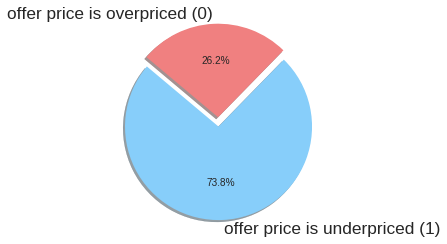

In [11]:
# Data to plot
labels = 'offer price is underpriced (1)', 'offer price is overpriced (0)'
sizes = [sum(y), len(y)-sum(y)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

It looks like our dataset is **not too unbalanced**, even though **underpriced offer prices are more common.**

### KNN

In [12]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(5.0, 50.0, endpoint=True, num=10)])
model     = KNeighborsClassifier()
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores, cv_scores = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name = "n_neighbors", 
                                                   param_range = K_values,
                                                   cv=cv_schema)

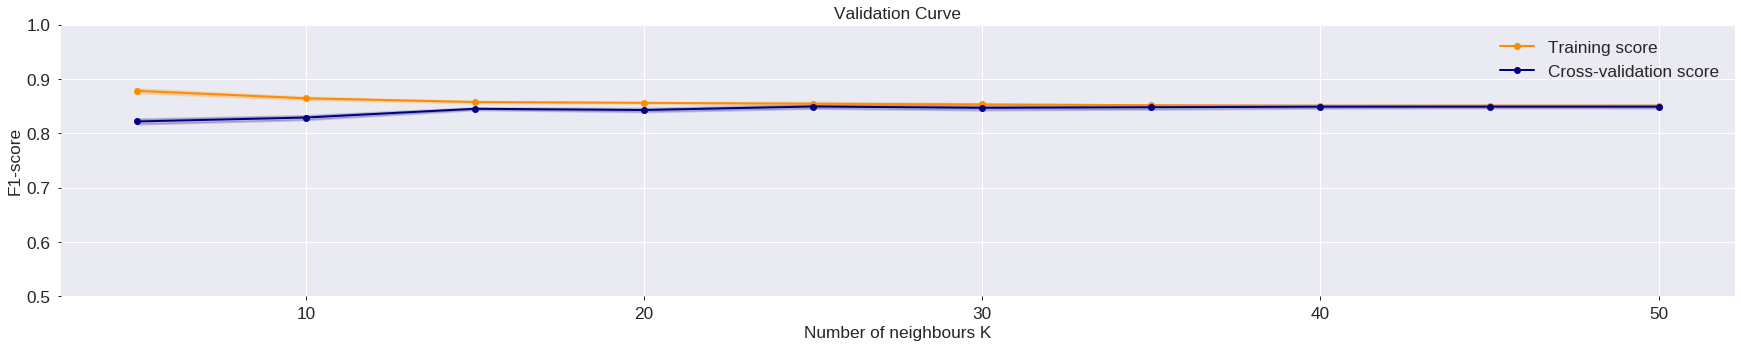

In [13]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, 
                      cv_scores,
                      K_values,
                      ylim=[0.5, 1.0],
                      y_label='F1-score',
                      x_label='Number of neighbours K', 
                      x_logscale=False)

In [14]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_K_value = K_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter K = ", best_K_value)

Best value for the parameter K =  25


In [15]:
# Calculate F1 of KNN Model on test set at best value of K
KNN = KNeighborsClassifier(n_neighbors=best_K_value, n_jobs=-1)
KNN.fit(X_train, y_train)
y_hat_KNN_prob = KNN.predict_proba(X_test)[:,1]

In [16]:
print("F1-score of our best KNN model: ", f1_score(y_test, y_hat_KNN_prob > 0.5))

F1-score of our best KNN model:  0.8576642335766423


### Random Forest

In [17]:
# Use a Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(5.0, 1000, 10)])
model     = RandomForestClassifier(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name = "n_estimators", 
                                                   param_range = N_values,
                                                   cv=cv_schema)

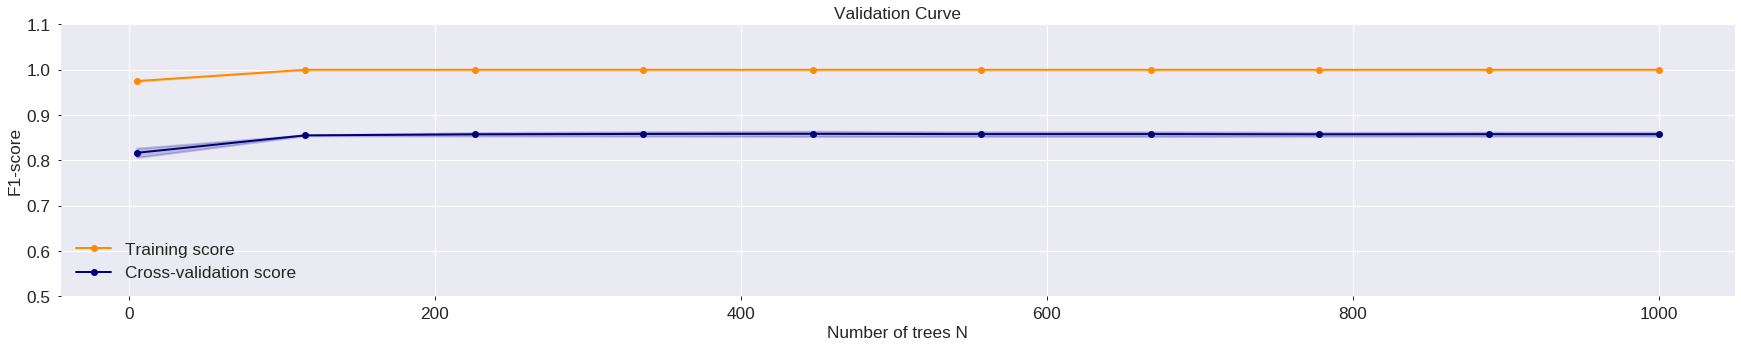

In [18]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores_val,
                      cv_scores_val,
                      N_values, y_label='F1-score',
                      ylim = [0.5, 1.1],
                      x_label='Number of trees N', 
                      x_logscale=False)


In [19]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores_val, axis=1)
best_N_value = N_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter N =", best_N_value)

Best value for the parameter N = 447


We take 700 trees since there is no real improvement on the cross-validation score with more trees

In [20]:
# Calculate F1 of Random Forest Model on test set at best value of N
RF = RandomForestClassifier(n_estimators=700, n_jobs=-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat_RF_prob = RF.predict_proba(X_test)[:,1]

In [21]:
print("F1-score of our best Random Forest Model: ", f1_score(y_test, y_hat_RF_prob > 0.5))

F1-score of our best Random Forest Model:  0.8555452003727866


### Regularized Logit Model

In [22]:
# Define model
C_values = np.logspace(-10, 10, num=21, endpoint=True, base=10.0)
LR = LogisticRegression(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

# Now use the validation_curve() function to train/validate models...
train_scores, cv_scores = validation_curve(LR, X_train, y_train,
                                           scoring='f1',
                                           param_name="C",
                                           param_range=C_values,
                                           cv=cv_schema)

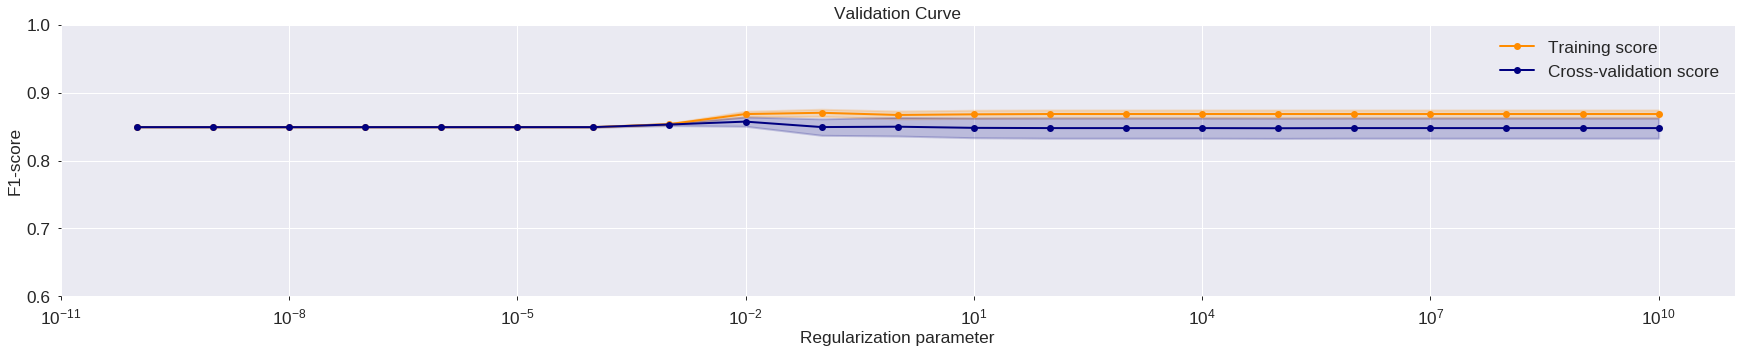

In [23]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores,
                      C_values, 
                      y_label='F1-score',
                      ylim = [0.6, 1.0],
                      x_label='Regularization parameter', 
                      x_logscale=True)

In [24]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_C_value = C_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter C =", best_C_value)

Best value for the parameter C = 0.01


In [25]:
# Calculate F1 of Regularized Logit Model on test set at best value of C
LR = LogisticRegression(C=best_C_value, n_jobs=-1, random_state=SEED)
LR.fit(X_train, y_train)
y_hat_logit_prob = LR.predict_proba(X_test)[:,1]

In [26]:
print("F1-score of our best Logit Model: ", f1_score(y_test, y_hat_logit_prob > 0.5))

F1-score of our best Logit Model:  0.8542056074766354


### Models comparison

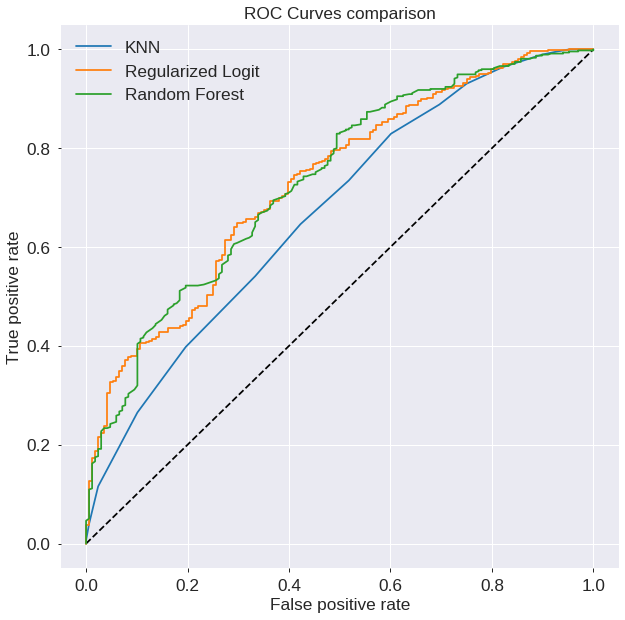

In [27]:
(fpr1, tpr1, thresholds1), model1 = roc_curve(y_test, y_hat_KNN_prob),'KNN'
(fpr2, tpr2, thresholds2), model2 = roc_curve(y_test, y_hat_logit_prob), 'Regularized Logit'
(fpr3, tpr3, thresholds3), model3 = roc_curve(y_test, y_hat_RF_prob), 'Random Forest'
plot_3rocs(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, model1, model2, model3)

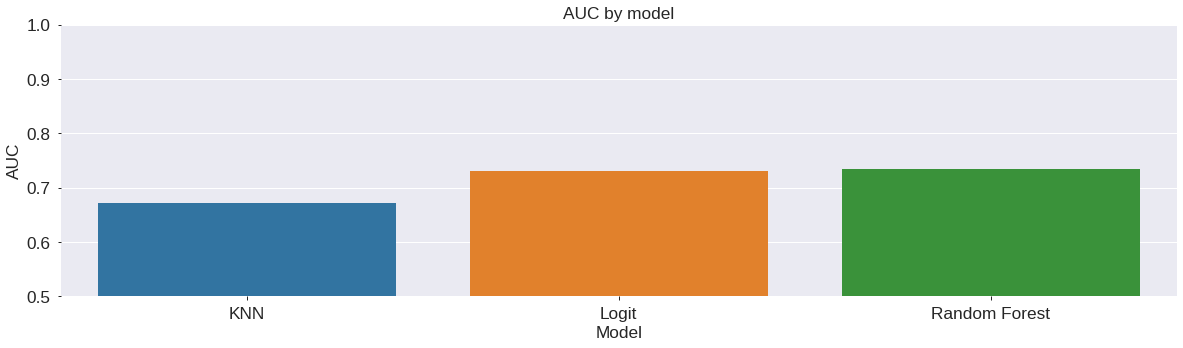

In [28]:
df =  pd.Series({'KNN': roc_auc_score(y_test, y_hat_KNN_prob),
                 'Random Forest': roc_auc_score(y_test, y_hat_RF_prob),
                 'Logit': roc_auc_score(y_test, y_hat_logit_prob)}).reset_index().sort_values(by=0)
plt.figure(figsize=(20,5))
sns.barplot(x='index', y=0, data=df)
plt.title('AUC by model')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.ylim([0.5,1])
plt.show()

It looks like the **Random Forest Model with 700 trees** is the **best performing model**.

We can now find the **threshold maximizing the Fbeta-score** with $\beta = 0.2$ by **cross-validating on the training set**.

In [29]:
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)
RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
thresholds = np.linspace(0,1,50)

train_scores = []
cv_scores = []
for train_indices, cv_indices in cv_schema.split(X_train, y_train):
    RF.fit(X_train[train_indices], y_train[train_indices])
    train_scores_inner = []
    cv_scores_inner = []
    for thresh in thresholds:
        y_hat_prob_train = RF.predict_proba(X_train[train_indices])[:,1] > thresh
        y_hat_prob_cv = RF.predict_proba(X_train[cv_indices])[:,1] > thresh

        train_scores_inner.append(fbeta_score(y_train[train_indices], y_hat_prob_train, beta=0.2))
        cv_scores_inner.append(fbeta_score(y_train[cv_indices], y_hat_prob_cv, beta=0.2))

    train_scores.append(train_scores_inner)
    cv_scores.append(cv_scores_inner)

# Transpose the array so they have the right shape
train_scores = np.ndarray.transpose(np.array(train_scores))
cv_scores = np.ndarray.transpose(np.array(cv_scores))

Threshold maximizing the Fbeta-score: 0.7755102040816326


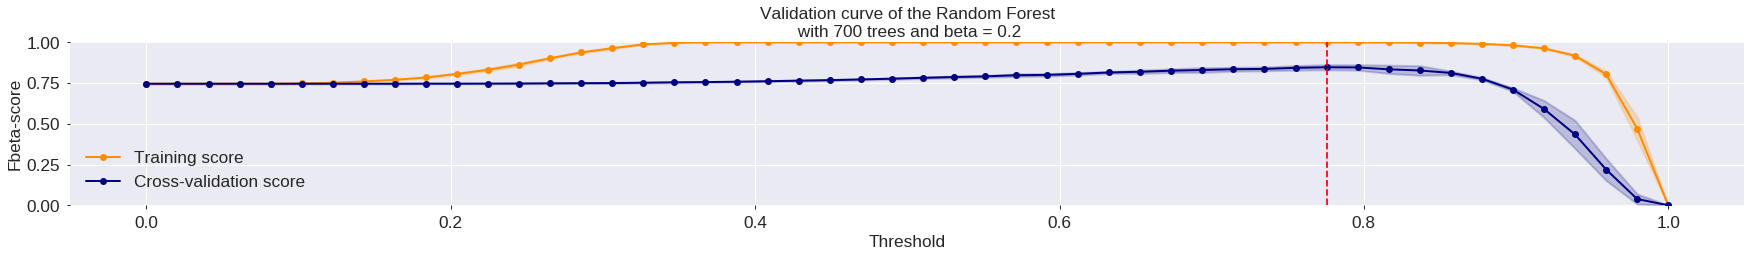

In [30]:
# Plot validation curve
plt.figure(figsize=(30,3))
plot_validation_curve(train_scores, cv_scores,
                      thresholds, 
                      x_label="Threshold",
                      y_label='Fbeta-score',
                      ylim = [0, 1.0],
                      title="Validation curve of the Random Forest\n with 700 trees and beta = 0.2",
                      x_logscale=False, 
                      ax=plt.gca())

# Find best threshold
df = pd.DataFrame(cv_scores, index=thresholds).mean(axis=1)
best_thresh = df.sort_values(ascending=False).reset_index()['index'].iloc[0]
print('Threshold maximizing the Fbeta-score: {}'.format(best_thresh))
plt.axvline(x=best_thresh, c='r', linestyle='--')
plt.show()

### Assessement of the best model

Our **best model** is the **Random Forest Model with 700 trees and a threshold of ~0.77**. 

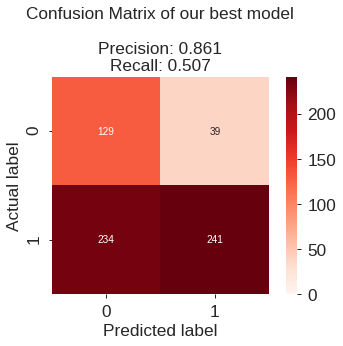

In [31]:
y_hat = RF.predict_proba(X_test)[:,1] > 0.7755
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Confusion Matrix of our best model\n\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title)
    
plt.show()

### What is the influence of $\beta$ ?

In [32]:
# Cross-validate over the training set for several betas
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)
RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
thresholds = np.linspace(0,1,50)

betas = [0.1, 0.2, 0.4]
train_scores_per_beta = []
cv_scores_per_beta = []

for beta in betas:
    train_scores = []
    cv_scores = []
    for train_indices, cv_indices in cv_schema.split(X_train, y_train):
        RF.fit(X_train[train_indices], y_train[train_indices])
        train_scores_inner = []
        cv_scores_inner = []
        for thresh in thresholds:
            y_hat_prob_train = RF.predict_proba(X_train[train_indices])[:,1] > thresh
            y_hat_prob_cv = RF.predict_proba(X_train[cv_indices])[:,1] > thresh

            train_scores_inner.append(fbeta_score(y_train[train_indices], y_hat_prob_train, beta=beta))
            cv_scores_inner.append(fbeta_score(y_train[cv_indices], y_hat_prob_cv, beta=beta))

        train_scores.append(train_scores_inner)
        cv_scores.append(cv_scores_inner)
    
    # Transpose the array so they have the right shape
    train_scores = np.ndarray.transpose(np.array(train_scores))
    cv_scores = np.ndarray.transpose(np.array(cv_scores))
    
    train_scores_per_beta.append(train_scores)
    cv_scores_per_beta.append(cv_scores)

In [33]:
best_thresholds = []
for i, beta in enumerate(betas):
    df = pd.DataFrame(cv_scores_per_beta[i], index=thresholds).mean(axis=1)
    best_thresh = df.sort_values(ascending=False).reset_index()['index'].iloc[0]
    best_thresholds.append(best_thresh)
    print("Threshold yielding highest Fbeta-score (beta: {}): {}".format(beta, best_thresh))

Threshold yielding highest Fbeta-score (beta: 0.1): 0.8571428571428571
Threshold yielding highest Fbeta-score (beta: 0.2): 0.7755102040816326
Threshold yielding highest Fbeta-score (beta: 0.4): 0.673469387755102


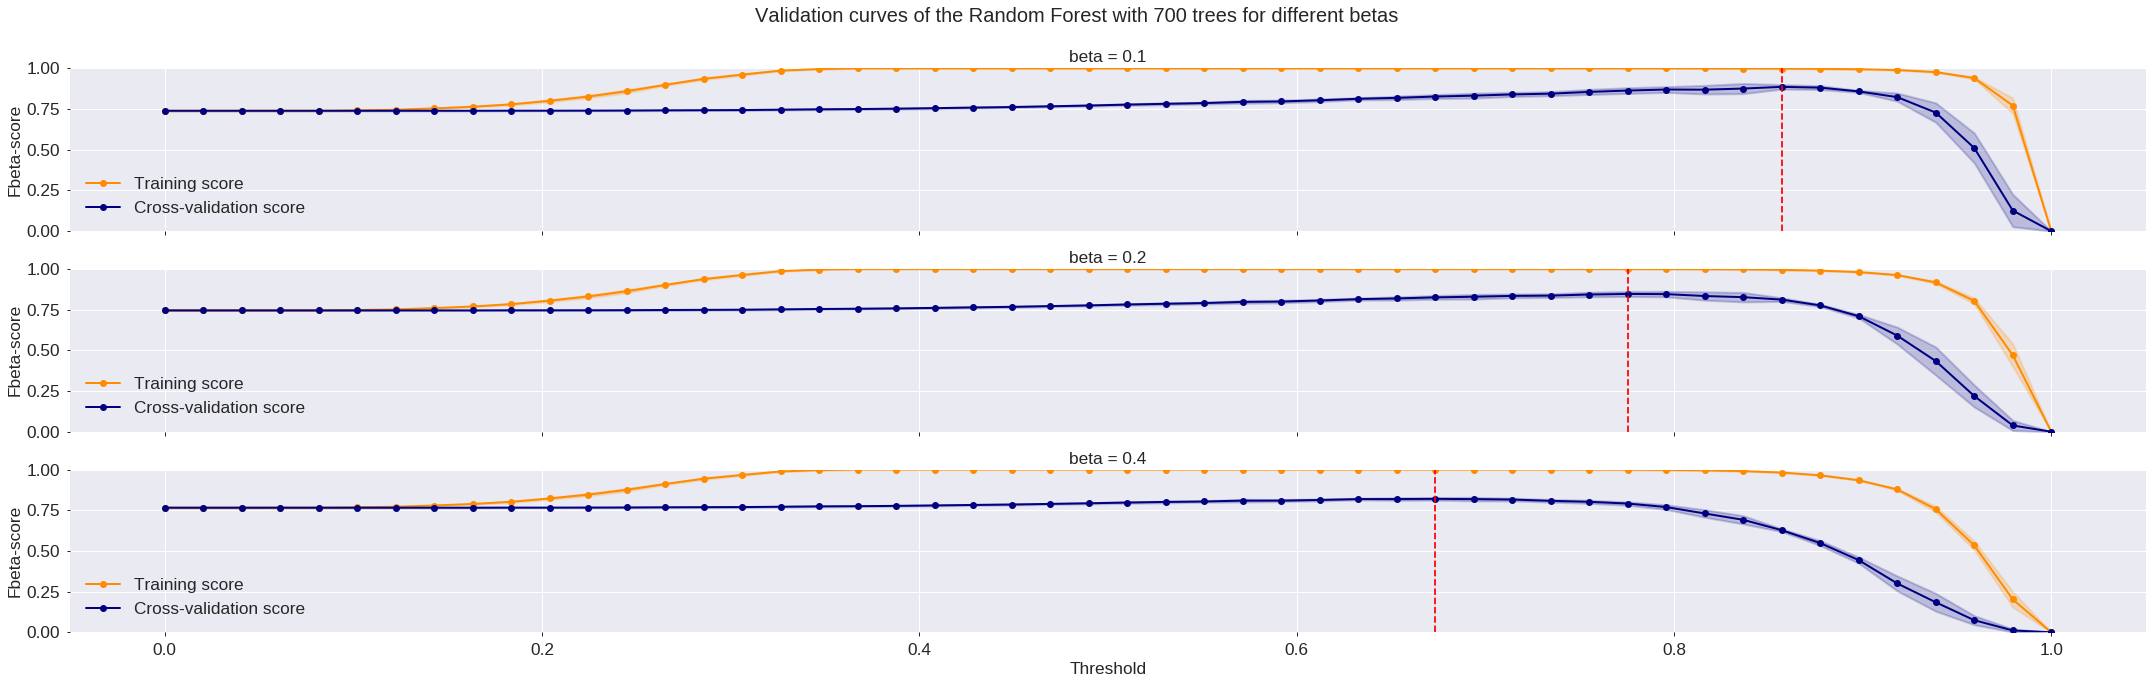

In [34]:
f, axes = plt.subplots(3,1, sharex=True, figsize=(30,9))
for i, beta, ax in zip(range(len(betas)), betas, axes.ravel()):
    plot_validation_curve(train_scores_per_beta[i], cv_scores_per_beta[i],
                          thresholds, 
                          y_label='Fbeta-score',
                          ylim = [0, 1.0],
                          title="beta = " + str(beta),
                          x_logscale=False, 
                          ax=ax)
    ax.axvline(x=best_thresholds[i], c='r', linestyle='--')
    
axes[2].set_xlabel('Threshold')
f.suptitle("Validation curves of the Random Forest with 700 trees for different betas", y=1.05, fontsize=20)
f.tight_layout()
plt.show()

As we can see, **the greater the $\beta$, the lower the threshold**. This makes sense since a greater $\beta$ gives more weight to the recall, and hence we will lower the threshold to "catch" more TP.

In [35]:
RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train);



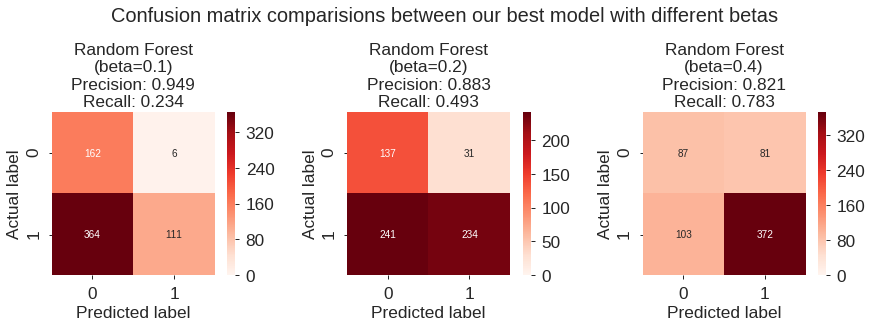

In [36]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
for ax, beta, best_thresh in zip(axes, betas, best_thresholds):
    y_hat = RF.predict_proba(X_test)[:,1] > best_thresh
    cm = confusion_matrix(y_test, y_hat)
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    title = "Random Forest\n(beta={})\nPrecision: {}\nRecall: {}".format(beta, round(precision, 3), round(recall, 3))
    plot_confusion_matrix(cm, title=title, ax=ax)
    
plt.suptitle('Confusion matrix comparisions between our best model with different betas', y=1.37, x=0.52, fontsize=20)
plt.show()

As expected, by **increasing the $\beta$**, we **give more weight to the recall** while **decreasing the importance of the precision**.

### How does it compare to the baseline ?

As a baseline, we always predict underpriced (i.e. `1`), since it is the most common outcome.


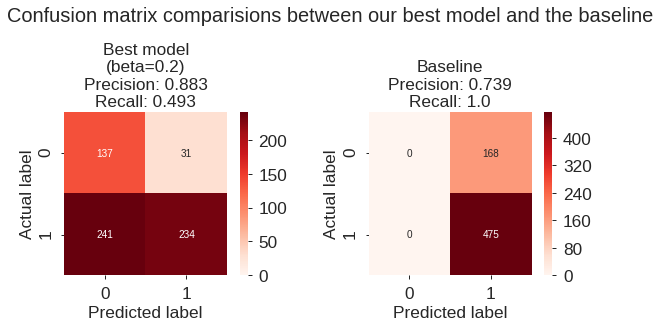

In [37]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
# Best random forest
best_thresh = 0.7755

RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat = RF.predict_proba(X_test)[:,1] > best_thresh
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Best model\n(beta=0.2)\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title, ax=axes[0])

# Baseline
y_hat_baseline = np.full_like(y_test, 1)
cm = confusion_matrix(y_test, y_hat_baseline)
precision = precision_score(y_test, y_hat_baseline)
recall = recall_score(y_test, y_hat_baseline)
title = "Baseline\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))

plot_confusion_matrix(cm, title=title, ax=axes[1])

plt.suptitle('Confusion matrix comparisions between our best model and the baseline', y=1.37, x=0.55, fontsize=20)

plt.show()

As we can see, the model performs much better than the baseline. Our model has **~50% of the TP for only ~20% of the FP**. On the other hand, it suffers from a high FN count, which was to expect given the chosen $\beta$ (i.e. 0.2)

### Which features matter more ?

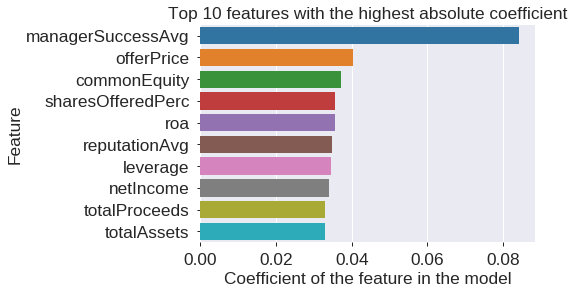

In [38]:
df = pd.DataFrame(RF.feature_importances_, index=P1_FEATURES)

sns.barplot(y='index', x=0, orient="h", data=df.apply(abs).reset_index().sort_values(by=0, ascending=False)[:10])
plt.xlabel('Coefficient of the feature in the model')
plt.ylabel('Feature')
plt.title('Top 10 features with the highest absolute coefficient')
plt.show()

The feature engineering from the `manager` field (i.e. `managerSuccessAvg`) is by far the most important in our model. This shows that the **track record of the managers is a good predictor of their IPOs' success.**

### Predict P1

We can now predict P1 using our best model: **Random Forest** with **700 trees** and a **threshold of ~0.69**

In [54]:
# Predict P1 for the data_to_predict
best_thresh = 0.7755

RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)
pd.to_pickle(pd.Series(RF.predict_proba(X_to_predict)[:,1] > best_thresh), 'P1.pkl')

## Prediction P2

- Predict whether the **closing price at the end of the first day** of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the **offer price.** You may use only the **rf** (i.e., risk factors), **year**, and **industryFF12** variables for this prediction task. You may, however, perform additional text analysis of the rf variable.


In [55]:
# Prepare the dataset to learn from
y = np.array(data_to_learn['closeDay1'] > data_to_learn['offerPrice'])

P2_FEATURES = ['rfSuccessAvgTop1', 'rfSuccessAvgTop10', 'rfSuccessAvgTop100', 'year'] + [industryFF12_column for industryFF12_column in data_to_learn.columns if industryFF12_column.startswith('industryFF12')]

X = np.array(data_to_learn[P2_FEATURES])
X_to_predict = np.array(data_to_predict[P2_FEATURES])

In [56]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_to_predict = scaler.transform(X_to_predict)

In [57]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

### KNN

In [43]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(5.0, 300.0, endpoint=True, num=20)])
model     = KNeighborsClassifier(n_jobs = -1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores, cv_scores = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name = "n_neighbors", 
                                                   param_range = K_values,
                                                   cv=cv_schema)

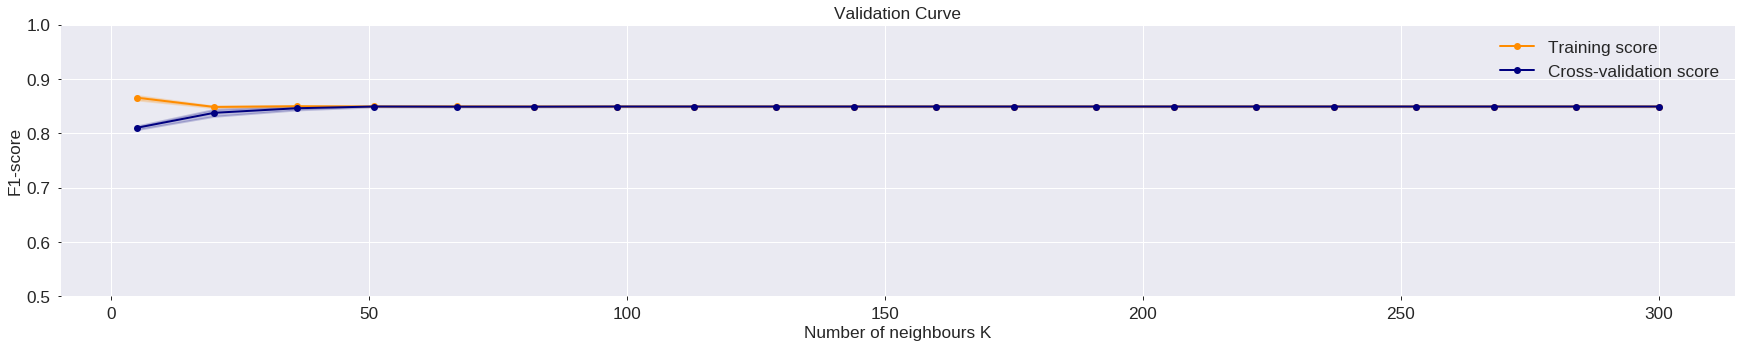

In [44]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, 
                      cv_scores,
                      K_values,
                      ylim=[0.5, 1.0],
                      y_label='F1-score',
                      x_label='Number of neighbours K', 
                      x_logscale=False)

In [45]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_K_value = K_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter K =", best_K_value)

Best value for the parameter K = 98


In [46]:
# Calculate F1 of KNN Model on test set at best value of K
KNN = KNeighborsClassifier(n_neighbors=best_K_value, n_jobs=-1)
KNN.fit(X_train, y_train)
y_hat_KNN_prob = KNN.predict_proba(X_test)[:,1]

In [47]:
print("F1-score of our best KNN model:", f1_score(y_test, y_hat_KNN_prob > 0.5))

F1-score of our best KNN model: 0.8497316636851521


### Random Forest

In [48]:
# Use a Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(5.0, 1000, 10)])
model = RandomForestClassifier(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name = "n_estimators", 
                                                   param_range = N_values,
                                                   cv=cv_schema)

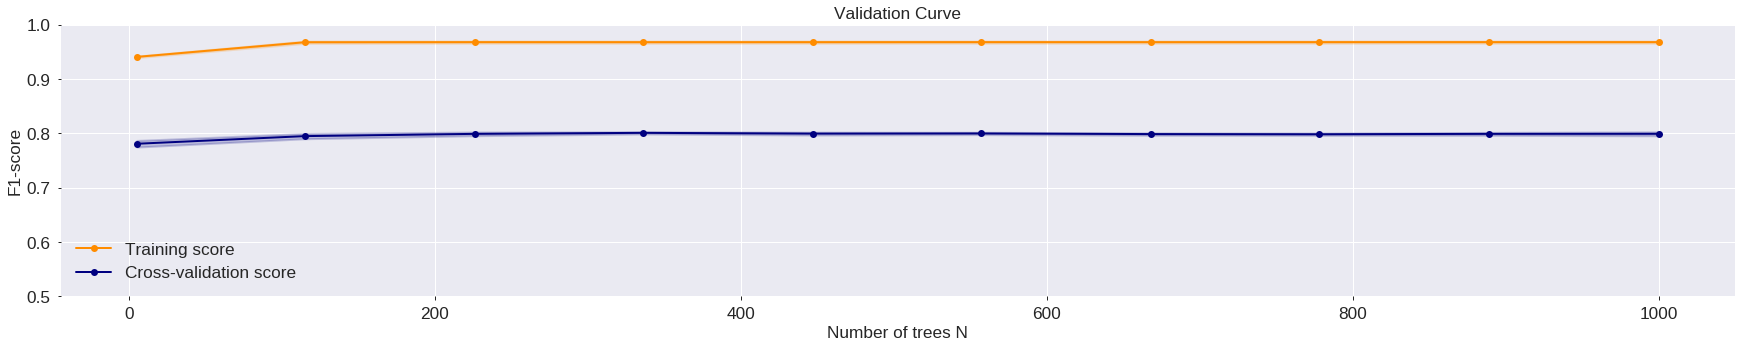

In [49]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores_val,
                      cv_scores_val,
                      N_values, y_label='F1-score',
                      ylim = [0.5, 1.0],
                      x_label='Number of trees N', 
                      x_logscale=False)


In [50]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores_val, axis=1)
best_N_value = N_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter N =", best_N_value)

Best value for the parameter N = 336


We take 700 trees because the F1-score does not really improve as we increase the amount of trees.

In [51]:
# Calculate F1 of Random Forest Model on test set at best value of N
RF = RandomForestClassifier(n_estimators=700, n_jobs=-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat_RF_prob = RF.predict_proba(X_test)[:,1]

In [52]:
print("F1-score of our best Random Forest Model:", f1_score(y_test, y_hat_RF_prob > 0.5))

F1-score of our best Random Forest Model: 0.8051181102362205


### Regularized Logit Model

In [53]:
# Define model
C_values = np.logspace(-10, 10, num=21, endpoint=True, base=10.0)
LR = LogisticRegression( random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

# Now use the validation_curve() function to train/validate models...
train_scores, cv_scores = validation_curve(LR, X_train, y_train,
                                           scoring='f1',
                                           param_name="C",
                                           param_range=C_values,
                                           cv=cv_schema)

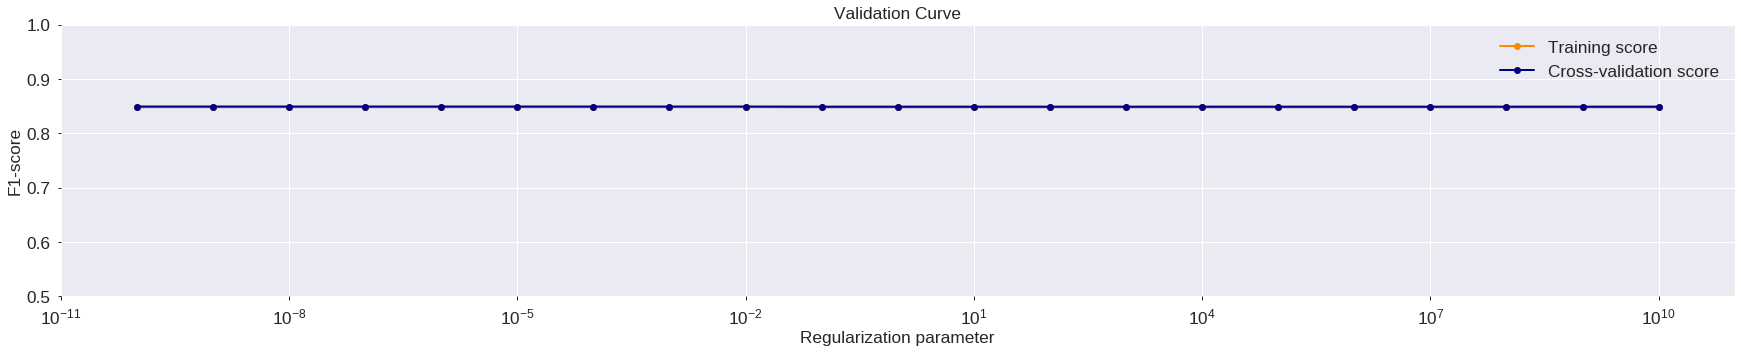

In [54]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores,
                      C_values, 
                      y_label='F1-score',
                      ylim = [0.5, 1.0],
                      x_label='Regularization parameter', 
                      x_logscale=True)

In [55]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_C_value = C_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter C =", best_C_value)

Best value for the parameter C = 1e-10


In [56]:
# Calculate F1 of Regularized Logit Model on test set at best value of C

LR = LogisticRegression(C=0.001, n_jobs=-1, random_state=SEED)
LR.fit(X_train, y_train)
y_hat_logit_prob = LR.predict_proba(X_test)[:,1]

In [57]:
print("F1-score of our best Logit Model:", f1_score(y_test, y_hat_logit_prob > 0.5))

F1-score of our best Logit Model: 0.8497316636851521


### Models comparison

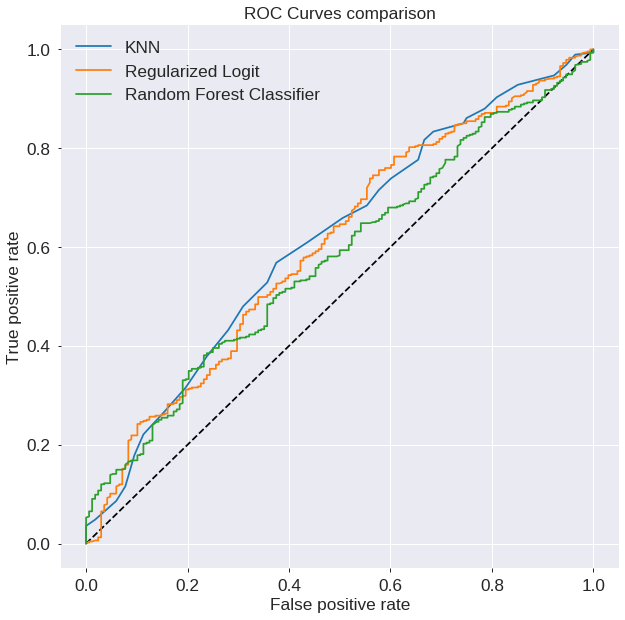

In [58]:
(fpr1, tpr1, thresholds1), model1 = roc_curve(y_test, y_hat_KNN_prob),'KNN'
(fpr2, tpr2, thresholds2), model2 = roc_curve(y_test, y_hat_logit_prob), 'Regularized Logit'
(fpr3, tpr3, thresholds3), model3 = roc_curve(y_test, y_hat_RF_prob), 'Random Forest Classifier'
plot_3rocs(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, model1, model2, model3)

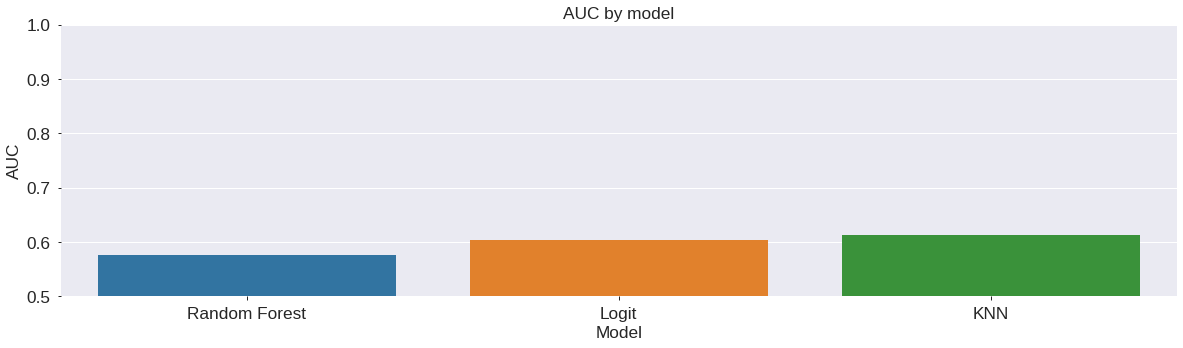

In [59]:
df =  pd.Series({'KNN': roc_auc_score(y_test, y_hat_KNN_prob),
                 'Random Forest': roc_auc_score(y_test, y_hat_RF_prob),
                 'Logit': roc_auc_score(y_test, y_hat_logit_prob)}).reset_index().sort_values(by=0)
plt.figure(figsize=(20,5))
sns.barplot(x='index', y=0, data=df)
plt.title('AUC by model')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.ylim([0.5,1])
plt.show()

It looks like the **KNN with 51 neighbors** is the **best performing model**.

We can now find the **threshold maximizing the Fbeta-score** with $\beta = 0.2$ by **cross-validating on the training set**.

In [60]:
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)
KNN = KNeighborsClassifier(n_neighbors=51, n_jobs = -1)
thresholds = np.linspace(0,1,50)

train_scores = []
cv_scores = []
for train_indices, cv_indices in cv_schema.split(X_train, y_train):
    KNN.fit(X_train[train_indices], y_train[train_indices])
    train_scores_inner = []
    cv_scores_inner = []
    for thresh in thresholds:
        y_hat_prob_train = KNN.predict_proba(X_train[train_indices])[:,1] > thresh
        y_hat_prob_cv = KNN.predict_proba(X_train[cv_indices])[:,1] > thresh

        train_scores_inner.append(fbeta_score(y_train[train_indices], y_hat_prob_train, beta=0.2))
        cv_scores_inner.append(fbeta_score(y_train[cv_indices], y_hat_prob_cv, beta=0.2))

    train_scores.append(train_scores_inner)
    cv_scores.append(cv_scores_inner)

# Transpose the array so they have the right shape
train_scores = np.ndarray.transpose(np.array(train_scores))
cv_scores = np.ndarray.transpose(np.array(cv_scores))

Threshold maximizing the Fbeta-score: 0.7346938775510203


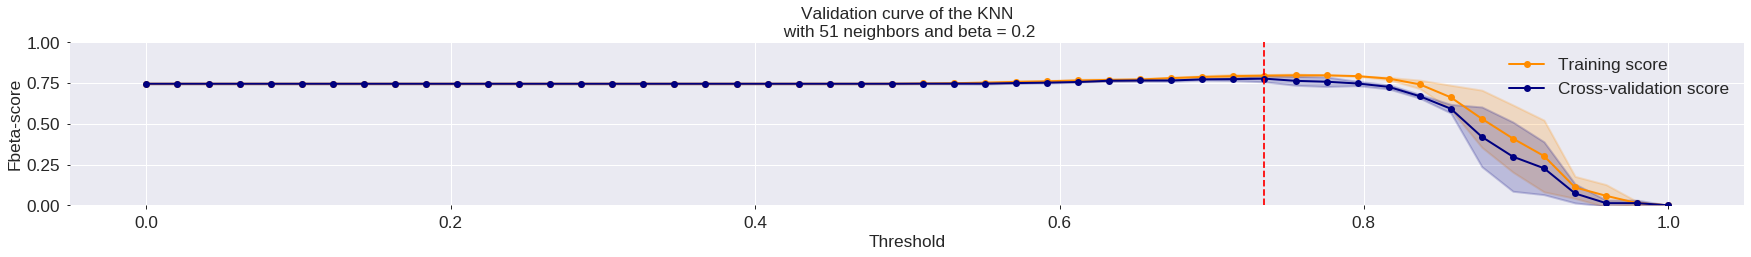

In [61]:
# Plot validation curve
plt.figure(figsize=(30,3))
plot_validation_curve(train_scores, cv_scores,
                      thresholds, 
                      x_label="Threshold",
                      y_label='Fbeta-score',
                      ylim = [0, 1.0],
                      title="Validation curve of the KNN\n with 51 neighbors and beta = 0.2",
                      x_logscale=False, 
                      ax=plt.gca())

# Find best threshold
df = pd.DataFrame(cv_scores, index=thresholds).mean(axis=1)
best_thresh = df.sort_values(ascending=False).reset_index()['index'].iloc[0]
print('Threshold maximizing the Fbeta-score: {}'.format(best_thresh))
plt.axvline(x=best_thresh, c='r', linestyle='--')
plt.show()

### Assessement of the best model

We pick the **KNN Model with 51 neighbors and a threshold of ~0.73**

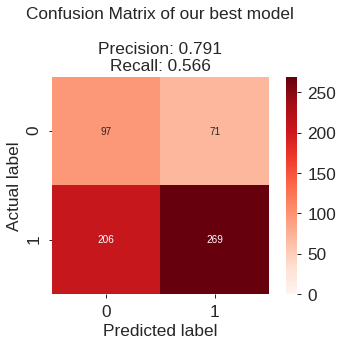

In [62]:
y_hat = KNN.predict_proba(X_test)[:,1] > 0.7347
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Confusion Matrix of our best model\n\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title)
    
plt.show()

### What is the influence of $\beta$ ?

In [63]:
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)
KNN = KNeighborsClassifier(n_neighbors=51, n_jobs = -1)
thresholds = np.linspace(0,1,50)


betas = [0.1, 0.2, 0.4]
train_scores_per_beta = []
cv_scores_per_beta = []

for beta in betas:
    train_scores = []
    cv_scores = []
    for train_indices, cv_indices in cv_schema.split(X_train, y_train):
        KNN.fit(X_train[train_indices], y_train[train_indices])
        train_scores_inner = []
        cv_scores_inner = []
        for thresh in thresholds:
            y_hat_prob_train = KNN.predict_proba(X_train[train_indices])[:,1] > thresh
            y_hat_prob_cv = KNN.predict_proba(X_train[cv_indices])[:,1] > thresh

            train_scores_inner.append(fbeta_score(y_train[train_indices], y_hat_prob_train, beta=beta))
            cv_scores_inner.append(fbeta_score(y_train[cv_indices], y_hat_prob_cv, beta=beta))

        train_scores.append(train_scores_inner)
        cv_scores.append(cv_scores_inner)
    
    # Transpose the array so they have the right shape
    train_scores = np.ndarray.transpose(np.array(train_scores))
    cv_scores = np.ndarray.transpose(np.array(cv_scores))
    
    train_scores_per_beta.append(train_scores)
    cv_scores_per_beta.append(cv_scores)

In [64]:
best_thresholds = []
for i, beta in enumerate(betas):
    df = pd.DataFrame(cv_scores_per_beta[i], index=thresholds).mean(axis=1)
    best_thresh = df.sort_values(ascending=False).reset_index()['index'].iloc[0]
    best_thresholds.append(best_thresh)
    print("Threshold yielding highest Fbeta-score (beta: {}): {}".format(beta, best_thresh))

Threshold yielding highest Fbeta-score (beta: 0.1): 0.7346938775510203
Threshold yielding highest Fbeta-score (beta: 0.2): 0.7346938775510203
Threshold yielding highest Fbeta-score (beta: 0.4): 0.6326530612244897


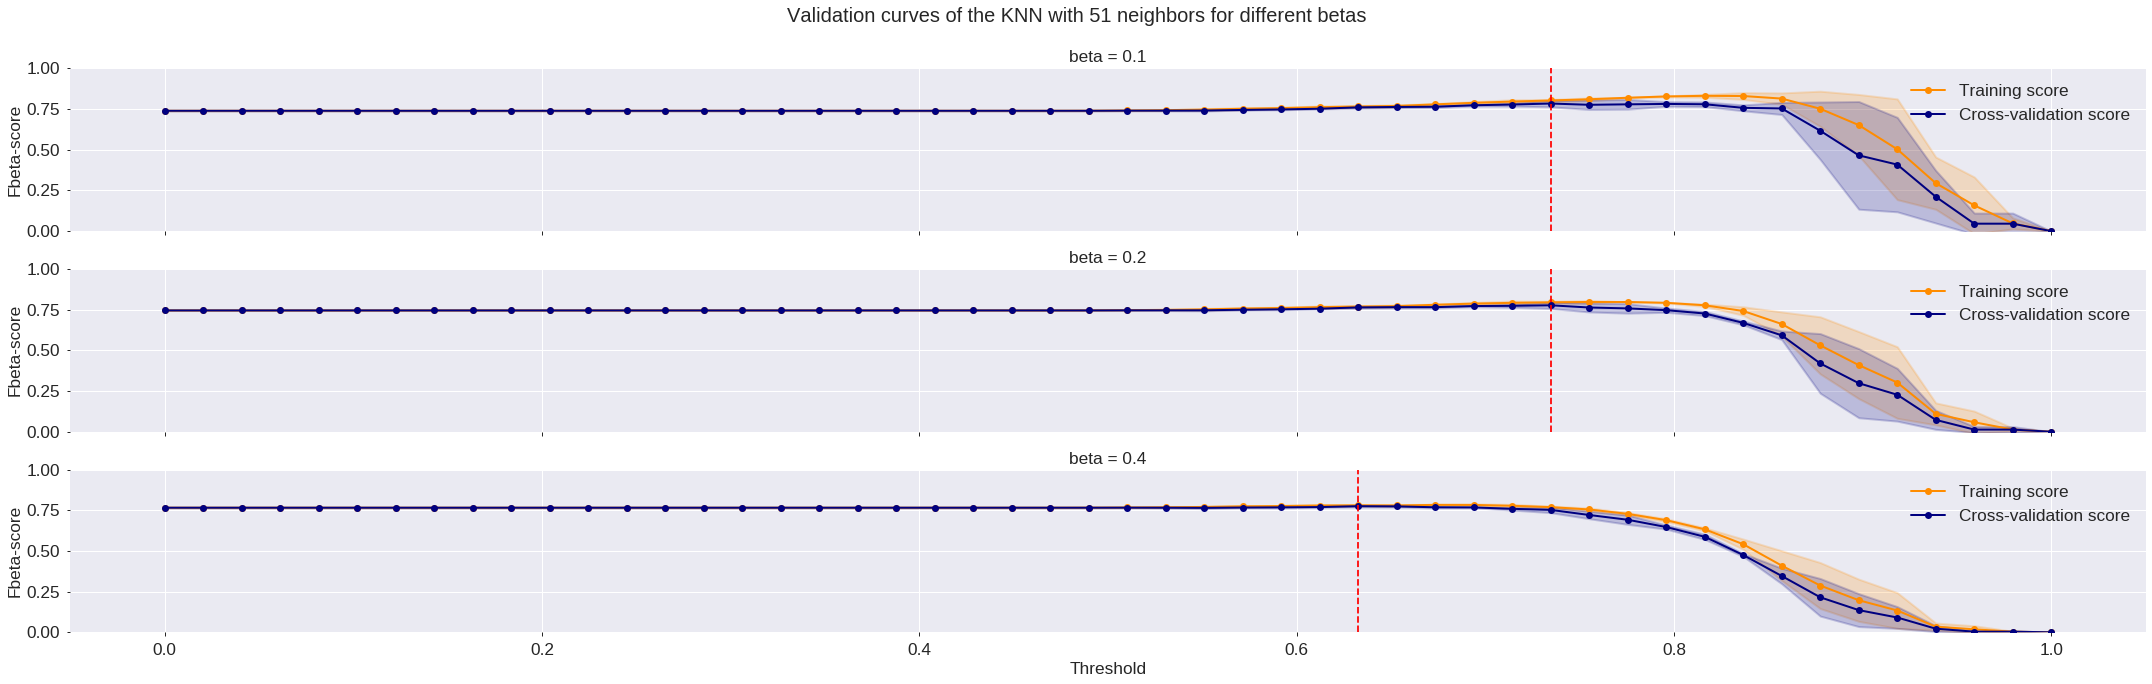

In [65]:
f, axes = plt.subplots(3,1, sharex=True, figsize=(30,9))
for i, beta, ax in zip(range(len(betas)), betas, axes.ravel()):
    plot_validation_curve(train_scores_per_beta[i], cv_scores_per_beta[i],
                          thresholds, 
                          y_label='Fbeta-score',
                          ylim = [0, 1.0],
                          title="beta = " + str(beta),
                          x_logscale=False, 
                          ax=ax)
    ax.axvline(x=best_thresholds[i], c='r', linestyle='--')
    
axes[2].set_xlabel('Threshold')
f.suptitle("Validation curves of the KNN with 51 neighbors for different betas", y=1.05, fontsize=20)
f.tight_layout()
plt.show()

As we can see, **the greater the $\beta$, the lower the threshold**. This makes sense since a greater $\beta$ gives more weight to the recall, and hence we will lower the threshold to "catch" more TP.

In [66]:
KNN = KNeighborsClassifier(n_neighbors=51, n_jobs = -1)
KNN.fit(X_train, y_train);



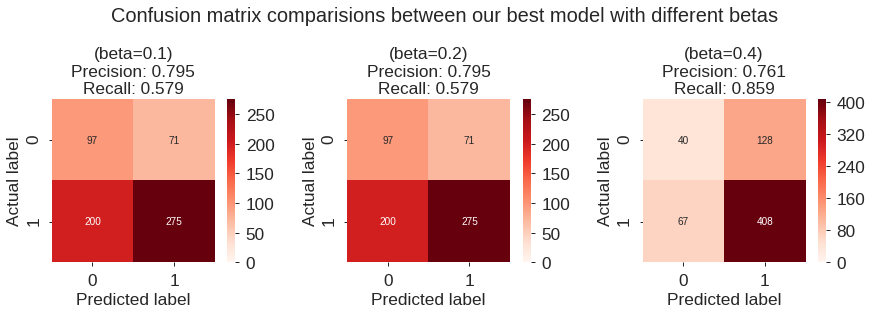

In [67]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
for ax, beta, best_thresh in zip(axes, betas, best_thresholds):
    y_hat = KNN.predict_proba(X_test)[:,1] > best_thresh
    cm = confusion_matrix(y_test, y_hat)
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    title = "(beta={})\nPrecision: {}\nRecall: {}".format(beta, round(precision, 3), round(recall, 3))
    plot_confusion_matrix(cm, title=title, ax=ax)
    
plt.suptitle('Confusion matrix comparisions between our best model with different betas', y=1.31, x=0.52, fontsize=20)
plt.show()

As expected, by **increasing the $\beta$**, we **give more weight to the recall** while **decreasing the importance of the precision**.

### How does it compare to the baseline ?

As a baseline, we always predict underpriced (i.e. `1`), since it is the most common outcome.


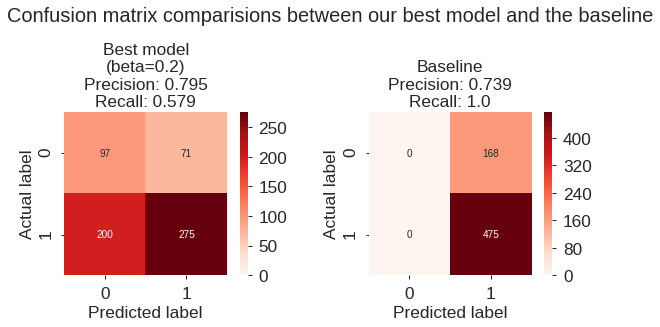

In [68]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
# Our best model
best_thresh = 0.7346

KNN = KNeighborsClassifier(n_neighbors=51, n_jobs = -1)
KNN.fit(X_train, y_train)
y_hat = KNN.predict_proba(X_test)[:,1] > best_thresh
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Best model\n(beta=0.2)\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title, ax=axes[0])

# Baseline
y_hat_baseline = np.full_like(y_test, 1)
cm = confusion_matrix(y_test, y_hat_baseline)
precision = precision_score(y_test, y_hat_baseline)
recall = recall_score(y_test, y_hat_baseline)
title = "Baseline\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))

plot_confusion_matrix(cm, title=title, ax=axes[1])

plt.suptitle('Confusion matrix comparisions between our best model and the baseline', y=1.37, x=0.55, fontsize=20)

plt.show()

As we can see, the model performs much better than the baseline. Our model has **50% of the TP for only 20% of the FP**. We however have a rather high FN count, which makes sense given the $\beta$ we have chosen (i.e. 0.2)

### Predict P2

We can now predict P2 using our best model: **KNN** with **5 neighbors** and a **threshold of ~0.73**

In [58]:
# Predict P2 for the data_to_predict
best_thresh = 0.7346

KNN = KNeighborsClassifier(n_neighbors=51, n_jobs = -1)
KNN.fit(X_train, y_train)
pd.to_pickle(pd.Series(KNN.predict_proba(X_to_predict)[:,1] > best_thresh), 'P2.pkl')

## Prediction P3

- Predict whether the **closing price at the end of the first day** of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the **offer price**.


In [59]:
# Prepare the dataset to learn from
P3_FEATURES = data_to_learn.drop(['closeDay1'], axis=1).columns

y = np.array(data_to_learn['closeDay1'] > data_to_learn['offerPrice'])

# We use all of the features available
X = np.array(data_to_learn[P3_FEATURES])
X_to_predict = np.array(data_to_predict[P3_FEATURES])

In [60]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_to_predict = scaler.transform(X_to_predict)

In [61]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

### KNN

In [83]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(5.0, 100.0, endpoint=True, num=10)])
model     = KNeighborsClassifier(n_jobs = -1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores, cv_scores = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name = "n_neighbors", 
                                                   param_range = K_values,
                                                   cv=cv_schema)

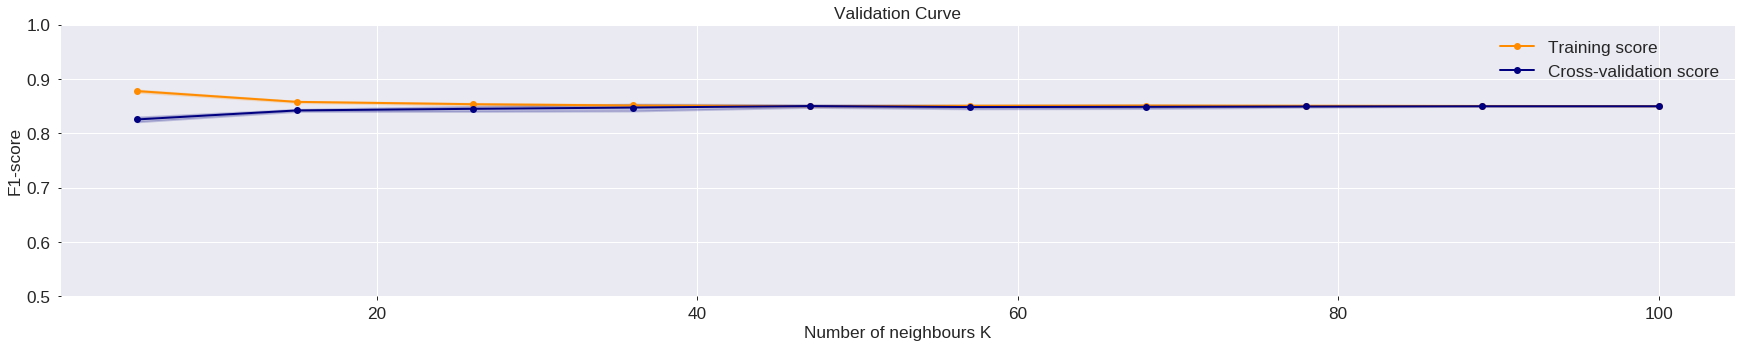

In [84]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, 
                      cv_scores,
                      K_values,
                      ylim=[0.5, 1.0],
                      y_label='F1-score',
                      x_label='Number of neighbours K', 
                      x_logscale=False)

In [85]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_K_value = K_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter K =", best_K_value)

Best value for the parameter K = 47


In [86]:
# Calculate F1 of KNN Model on test set at best value of K
KNN = KNeighborsClassifier(n_neighbors=best_K_value, n_jobs=-1)
KNN.fit(X_train, y_train)
y_hat_KNN_prob = KNN.predict_proba(X_test)[:,1]

In [87]:
print("F1-score of our best KNN model:", f1_score(y_test, y_hat_KNN_prob > 0.5))

F1-score of our best KNN model: 0.8524886877828054


### Random Forest

In [88]:
# Use a Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(5.0, 1000, 10)])
model     = RandomForestClassifier(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name = "n_estimators", 
                                                   param_range = N_values,
                                                   cv=cv_schema)

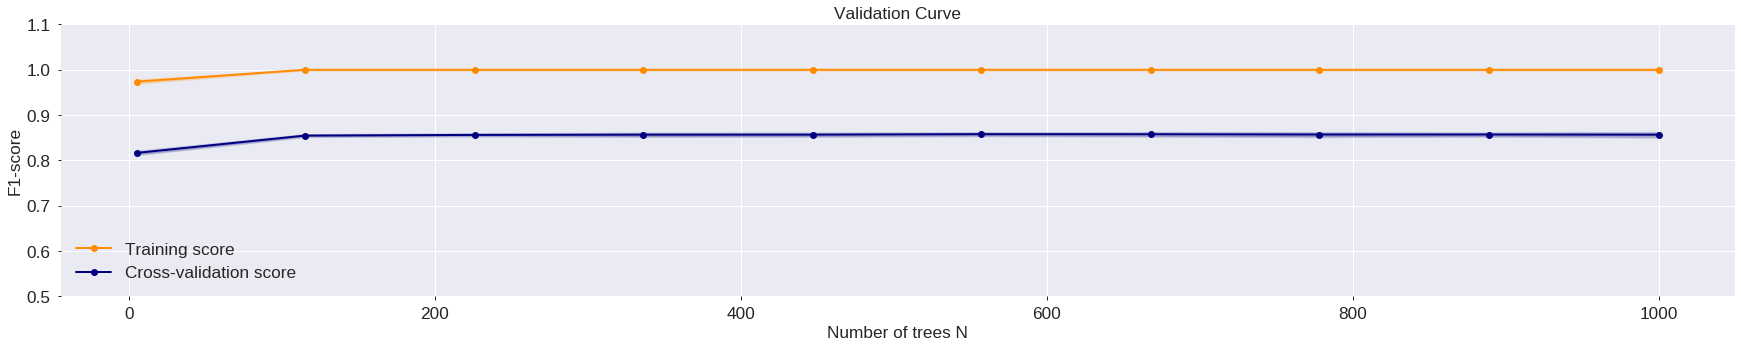

In [89]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores_val,
                      cv_scores_val,
                      N_values, y_label='F1-score',
                      ylim = [0.5, 1.1],
                      x_label='Number of trees N', 
                      x_logscale=False)


In [90]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores_val, axis=1)
best_N_value = N_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter N =", best_N_value)

Best value for the parameter N = 557


We round it up to 400 trees

In [91]:
# Calculate F1 of Random Forest Model on test set at best value of N
RF = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat_RF_prob = RF.predict_proba(X_test)[:,1]

In [92]:
print("F1-score of our best Random Forest Model:", f1_score(y_test, y_hat_RF_prob > 0.5))

F1-score of our best Random Forest Model: 0.8582089552238806


### Regularized Logit Model

In [93]:
# Define model
C_values = np.logspace(-10, 10, num=21, endpoint=True, base=10.0)
LR = LogisticRegression(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

# Now use the validation_curve() function to train/validate models...
train_scores, cv_scores = validation_curve(LR, X_train, y_train,
                                           scoring='f1',
                                           param_name="C",
                                           param_range=C_values,
                                           cv=cv_schema)

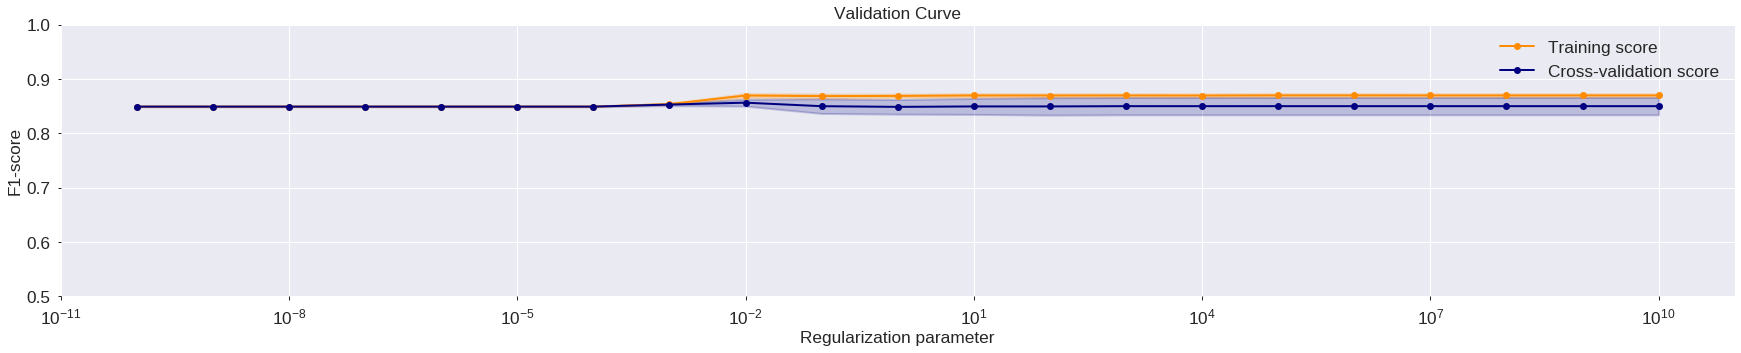

In [94]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores,
                      C_values, 
                      y_label='F1-score',
                      ylim = [0.5, 1.0],
                      x_label='Regularization parameter', 
                      x_logscale=True)

In [95]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_C_value = C_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter C =", best_C_value)

Best value for the parameter C = 0.01


In [96]:
# Calculate AUC of Regularized Logit Model on test set at best value of C
LR = LogisticRegression(C=best_C_value, n_jobs=-1, random_state=SEED)
LR.fit(X_train, y_train)
y_hat_logit_prob = LR.predict_proba(X_test)[:,1]

In [97]:
print("F1-score of our best Logit model:", f1_score(y_test, y_hat_logit_prob > 0.5))

F1-score of our best Logit model: 0.8574108818011257


### Models comparison

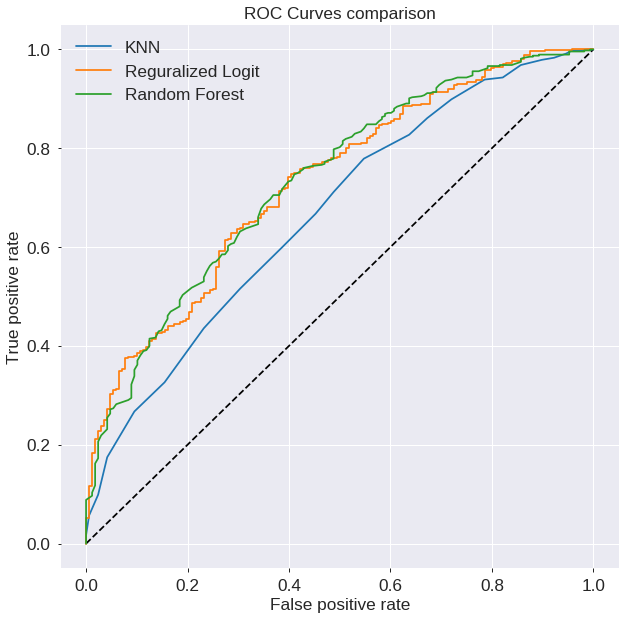

In [98]:
(fpr1, tpr1, thresholds1), model1 = roc_curve(y_test, y_hat_KNN_prob),'KNN'
(fpr2, tpr2, thresholds2), model2 = roc_curve(y_test, y_hat_logit_prob), 'Reguralized Logit'
(fpr3, tpr3, thresholds3), model3 = roc_curve(y_test, y_hat_RF_prob), 'Random Forest'
plot_3rocs(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, model1, model2, model3)

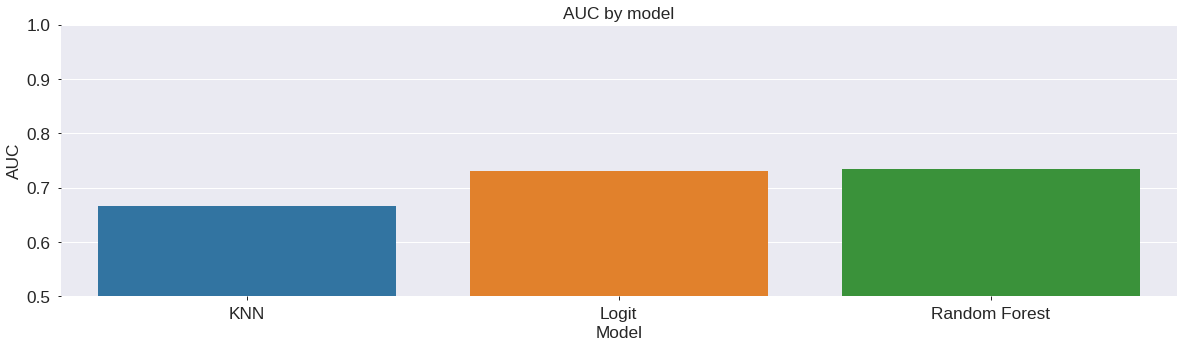

In [99]:
df =  pd.Series({'KNN': roc_auc_score(y_test, y_hat_KNN_prob),
                 'Random Forest': roc_auc_score(y_test, y_hat_RF_prob),
                 'Logit': roc_auc_score(y_test, y_hat_logit_prob)}).reset_index().sort_values(by=0)
plt.figure(figsize=(20,5))
sns.barplot(x='index', y=0, data=df)
plt.title('AUC by model')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.ylim([0.5,1])
plt.show()

It looks like the **Random Forest Model with 400 trees** is the **best performing model**.

We can now find the **threshold maximizing the Fbeta-score** with $\beta = 0.2$ by **cross-validating on the training set**.

In [100]:
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)
RF = RandomForestClassifier(n_estimators=400, n_jobs =-1, random_state=SEED)
thresholds = np.linspace(0,1,50)

train_scores = []
cv_scores = []
for train_indices, cv_indices in cv_schema.split(X_train, y_train):
    RF.fit(X_train[train_indices], y_train[train_indices])
    train_scores_inner = []
    cv_scores_inner = []
    for thresh in thresholds:
        y_hat_prob_train = RF.predict_proba(X_train[train_indices])[:,1] > thresh
        y_hat_prob_cv = RF.predict_proba(X_train[cv_indices])[:,1] > thresh

        train_scores_inner.append(fbeta_score(y_train[train_indices], y_hat_prob_train, beta=0.2))
        cv_scores_inner.append(fbeta_score(y_train[cv_indices], y_hat_prob_cv, beta=0.2))

    train_scores.append(train_scores_inner)
    cv_scores.append(cv_scores_inner)

# Transpose the array so they have the right shape
train_scores = np.ndarray.transpose(np.array(train_scores))
cv_scores = np.ndarray.transpose(np.array(cv_scores))

Threshold maximizing the Fbeta-score: 0.7959183673469387


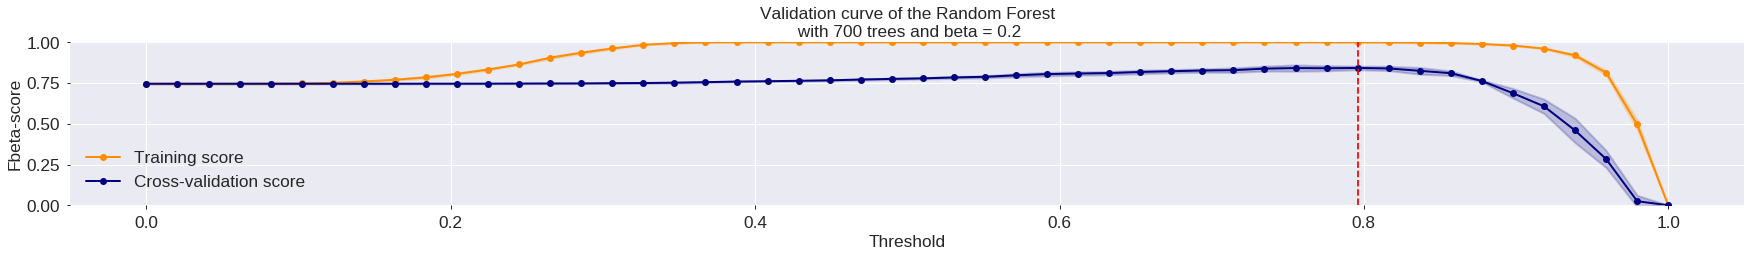

In [101]:
# Plot validation curve
plt.figure(figsize=(30,3))
plot_validation_curve(train_scores, cv_scores,
                      thresholds, 
                      x_label="Threshold",
                      y_label='Fbeta-score',
                      ylim = [0, 1.0],
                      title="Validation curve of the Random Forest\n with 700 trees and beta = 0.2",
                      x_logscale=False, 
                      ax=plt.gca())

# Find best threshold
df = pd.DataFrame(cv_scores, index=thresholds).mean(axis=1)
best_thresh = df.sort_values(ascending=False).reset_index()['index'].iloc[0]
print('Threshold maximizing the Fbeta-score: {}'.format(best_thresh))
plt.axvline(x=best_thresh, c='r', linestyle='--')
plt.show()

### Assessement of the best model

We pick the **Random Forest Model with 400 trees with a threshold of ~0.7755**. 

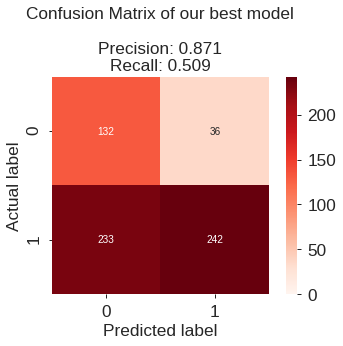

In [102]:
y_hat = RF.predict_proba(X_test)[:,1] > 0.7755
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Confusion Matrix of our best model\n\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title)
    
plt.show()

### What is the influence of $\beta$ ?

In [103]:
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)
RF = RandomForestClassifier(n_estimators=400, n_jobs =-1, random_state=SEED)
thresholds = np.linspace(0,1,50)

betas = [0.1, 0.2, 0.4]
train_scores_per_beta = []
cv_scores_per_beta = []

for beta in betas:
    train_scores = []
    cv_scores = []
    for train_indices, cv_indices in cv_schema.split(X_train, y_train):
        RF.fit(X_train[train_indices], y_train[train_indices])
        train_scores_inner = []
        cv_scores_inner = []
        for thresh in thresholds:
            y_hat_prob_train = RF.predict_proba(X_train[train_indices])[:,1] > thresh
            y_hat_prob_cv = RF.predict_proba(X_train[cv_indices])[:,1] > thresh

            train_scores_inner.append(fbeta_score(y_train[train_indices], y_hat_prob_train, beta=beta))
            cv_scores_inner.append(fbeta_score(y_train[cv_indices], y_hat_prob_cv, beta=beta))

        train_scores.append(train_scores_inner)
        cv_scores.append(cv_scores_inner)
    
    # Transpose the array so they have the right shape
    train_scores = np.ndarray.transpose(np.array(train_scores))
    cv_scores = np.ndarray.transpose(np.array(cv_scores))
    
    train_scores_per_beta.append(train_scores)
    cv_scores_per_beta.append(cv_scores)

In [104]:
best_thresholds = []
for i, beta in enumerate(betas):
    df = pd.DataFrame(cv_scores_per_beta[i], index=thresholds).mean(axis=1)
    best_thresh = df.sort_values(ascending=False).reset_index()['index'].iloc[0]
    best_thresholds.append(best_thresh)
    print("Threshold yielding highest Fbeta-score (beta: {}): {}".format(beta, best_thresh))

Threshold yielding highest Fbeta-score (beta: 0.1): 0.8571428571428571
Threshold yielding highest Fbeta-score (beta: 0.2): 0.7959183673469387
Threshold yielding highest Fbeta-score (beta: 0.4): 0.6530612244897959


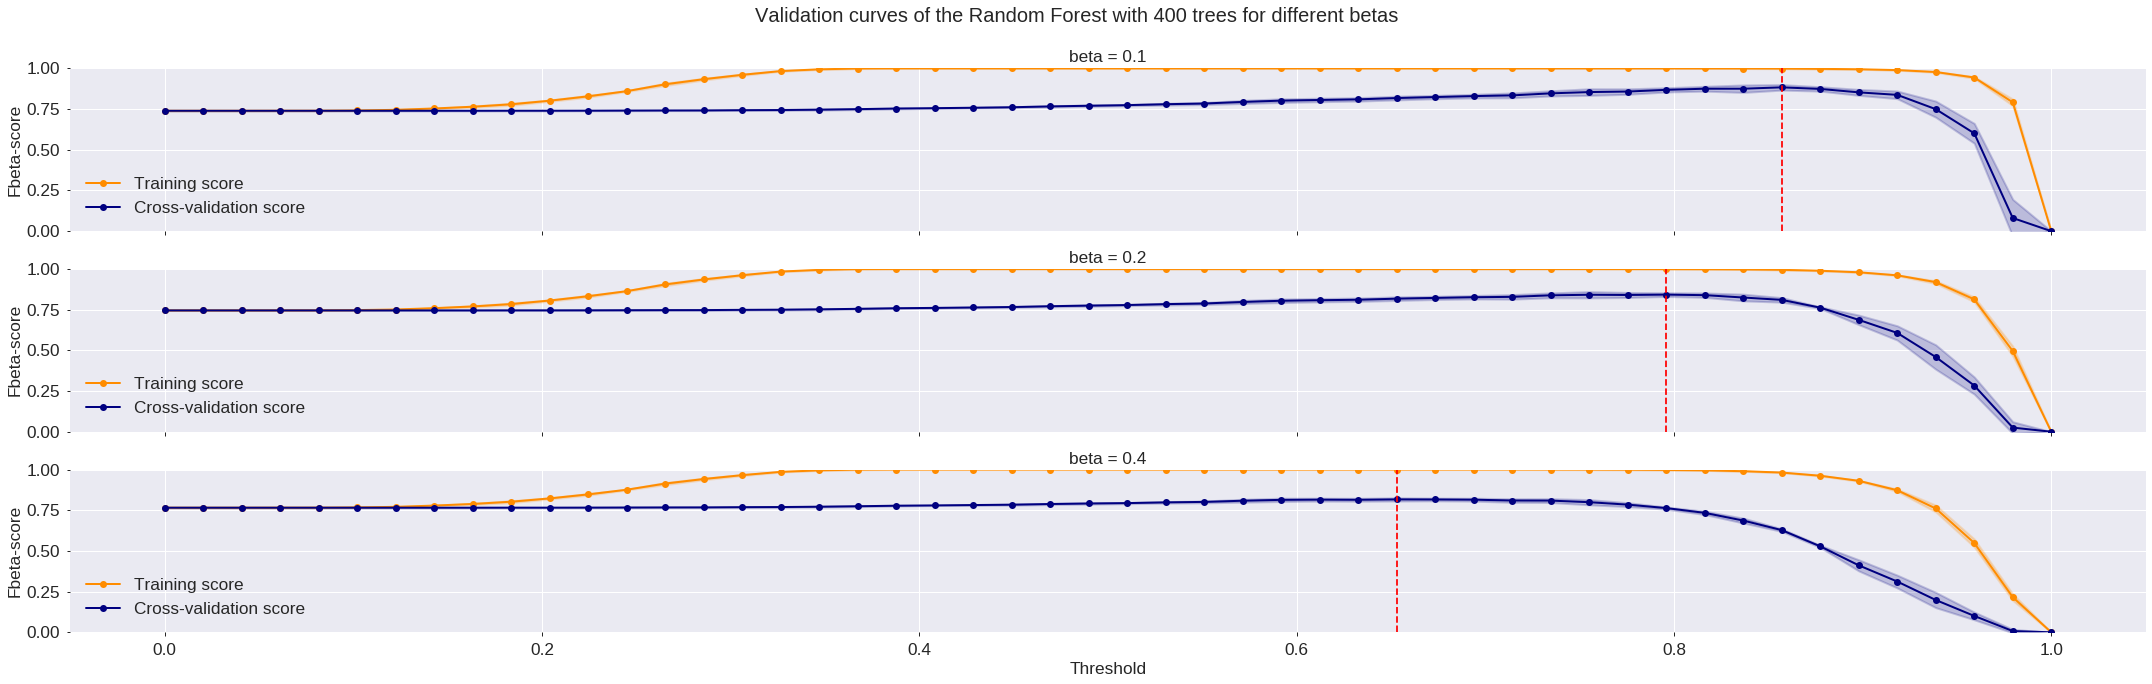

In [105]:
f, axes = plt.subplots(3,1, sharex=True, figsize=(30,9))
for i, beta, ax in zip(range(len(betas)), betas, axes.ravel()):
    plot_validation_curve(train_scores_per_beta[i], cv_scores_per_beta[i],
                          thresholds, 
                          y_label='Fbeta-score',
                          ylim = [0, 1.0],
                          title="beta = " + str(beta),
                          x_logscale=False, 
                          ax=ax)
    
    ax.axvline(x=best_thresholds[i], c='r', linestyle='--')

    
axes[2].set_xlabel('Threshold')
f.suptitle("Validation curves of the Random Forest with 400 trees for different betas", y=1.05, fontsize=20)
f.tight_layout()
plt.show()

As we can see, **the greater the $\beta$, the lower the threshold**. This makes sense since a greater $\beta$ gives more weight to the recall, and hence we will lower the threshold to "catch" more TP.

In [106]:
RF = RandomForestClassifier(n_estimators=400, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train);



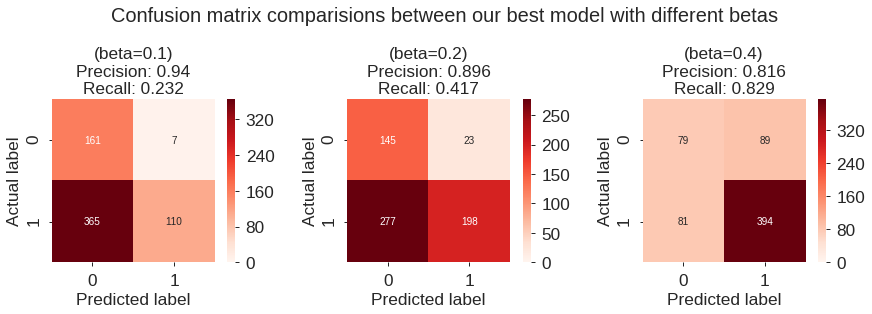

In [107]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
for ax, beta, best_thresh in zip(axes, betas, best_thresholds):
    y_hat = RF.predict_proba(X_test)[:,1] > best_thresh
    cm = confusion_matrix(y_test, y_hat)
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    title = "(beta={})\nPrecision: {}\nRecall: {}".format(beta, round(precision, 3), round(recall, 3))
    plot_confusion_matrix(cm, title=title, ax=ax)
    
plt.suptitle('Confusion matrix comparisions between our best model with different betas', y=1.31, x=0.52, fontsize=20)
plt.show()

As expected, by **increasing the $\beta$**, we **give more weight to the recall** while **decreasing the importance of the precision**.

### How does it compare to the baseline ?

As a baseline, we always predict underpriced (i.e. `1`), since it is the most common outcome.


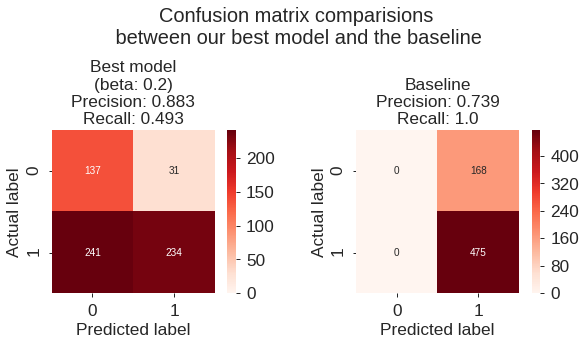

In [108]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
# Best model
best_thresh = 0.7755

RF = RandomForestClassifier(n_estimators=400, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat = RF.predict_proba(X_test)[:,1] > best_thresh
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Best model\n(beta: 0.2)\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title, ax=axes[0])

# Baseline
y_hat_baseline = np.full_like(y_test, 1)
cm = confusion_matrix(y_test, y_hat_baseline)
precision = precision_score(y_test, y_hat_baseline)
recall = recall_score(y_test, y_hat_baseline)
title = "Baseline\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))

plot_confusion_matrix(cm, title=title, ax=axes[1])

plt.suptitle('Confusion matrix comparisions\n between our best model and the baseline', y=1.45, x=0.52, fontsize=20)

plt.show()

As we can see, the model performs much better than the baseline. Our model has **50% of the TP for only 20* of the FP**. On the other hand, it suffers from a high FN count, which was to expect given the chosen $\beta$ (i.e. 0.2)

We notice that this **confusion matrix is the same as for P1**. Hence, adding the features engineered from `rf` did not improve our prediction.

### Which features matter more ?

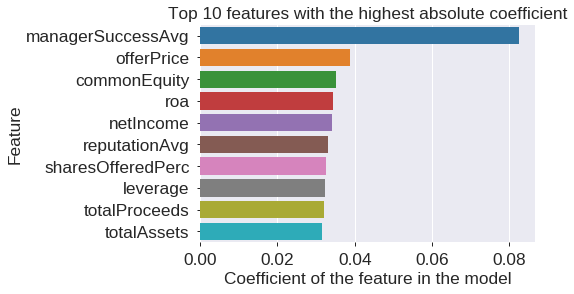

In [109]:
df = pd.DataFrame(RF.feature_importances_, index=P3_FEATURES)

sns.barplot(y='index', x=0, orient="h", data=df.apply(abs).reset_index().sort_values(by=0, ascending=False)[:10])
plt.xlabel('Coefficient of the feature in the model')
plt.ylabel('Feature')
plt.title('Top 10 features with the highest absolute coefficient')
plt.show()

As in P1, the feature engineering from the `manager` field (i.e. `managerSuccessAvg`) is by far the most important in our model. This shows that the **track record of the managers is a good predictor of their IPOs' success.**

One the other hand, the features engineered from `rf` did not make it into the top 10. This explains why **the best model for P3** is basically the **same as the best model for P1**, and why we have the same confusion matrix.

### Predict P3

We can now predict P3 using our best model: **Random Forest** with **400 trees** and a **threshold of ~0.77**

In [62]:
# Predict P3 for the data_to_predict
best_thresh = 0.7755

RF = RandomForestClassifier(n_estimators=400, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)
pd.to_pickle(pd.Series(RF.predict_proba(X_to_predict)[:,1] > best_thresh), 'P3.pkl')

## Prediction P4

- Predict whether the **closing price at the end of the first day** of trading will go **up by more than 20%** from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).

In [63]:
# Prepare the dataset to learn from
y = np.array(data_to_learn['closeDay1'] > data_to_learn['offerPrice']*1.2)

P4_FEATURES = data_to_learn.drop(['closeDay1'],axis=1).columns

# We use all of the features available
X = np.array(data_to_learn[P4_FEATURES])
X_to_predict = np.array(data_to_predict[P4_FEATURES])

In [64]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_to_predict = scaler.transform(X_to_predict)

In [65]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

### Is our training set balanced?

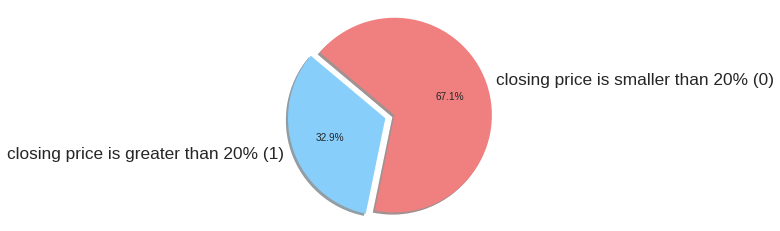

In [147]:
# Data to plot
labels = 'closing price is greater than 20% (1)', 'closing price is smaller than 20% (0)'
sizes = [sum(y), len(y)-sum(y)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

The data is **roughly balanced**, although there are more positives than negatices.

### KNN

In [148]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(5.0, 50.0, endpoint=True, num=10)])
model     = KNeighborsClassifier()
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores, cv_scores = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name = "n_neighbors", 
                                                   param_range = K_values,
                                                   cv=cv_schema)

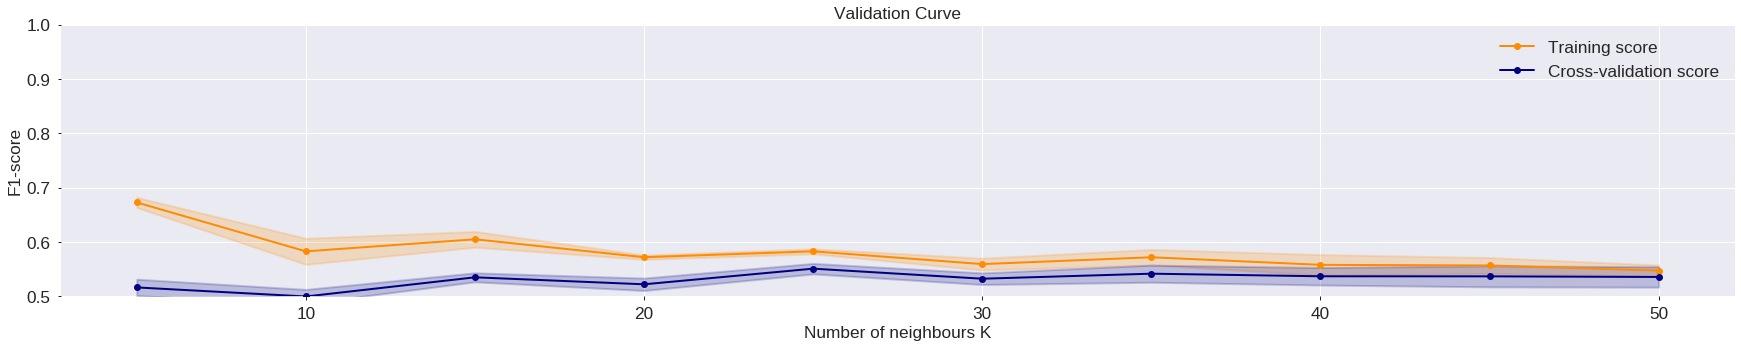

In [149]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, 
                      cv_scores,
                      K_values,
                      ylim=[0.5, 1.0],
                      y_label='F1-score',
                      x_label='Number of neighbours K', 
                      x_logscale=False)

In [150]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_K_value = K_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter K =", best_K_value)

Best value for the parameter K = 25


In [151]:
# Calculate AUC of KNN Model on test set at best value of K
KNN = KNeighborsClassifier(n_neighbors=best_K_value, n_jobs=-1)
KNN.fit(X_train, y_train)
y_hat_KNN_prob = KNN.predict_proba(X_test)[:,1]

In [152]:
print("F1-score of our best KNN model:", f1_score(y_test, y_hat_KNN_prob > 0.5))

F1-score of our best KNN model: 0.5226666666666667


### Random Forest

In [153]:
# Use a Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(5.0, 1000, 10)])
model = RandomForestClassifier( random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name = "n_estimators", 
                                                   param_range = N_values,
                                                   cv=cv_schema)

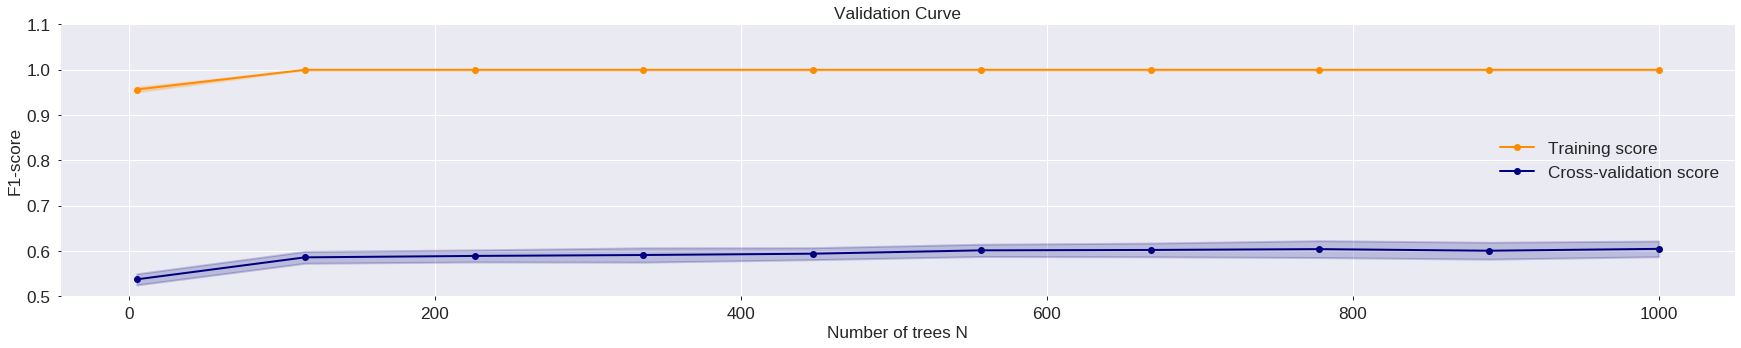

In [154]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores_val,
                      cv_scores_val,
                      N_values, y_label='F1-score',
                      ylim = [0.5, 1.1],
                      x_label='Number of trees N', 
                      x_logscale=False)

In [155]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores_val, axis=1)
best_N_value = N_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter N =", best_N_value)

Best value for the parameter N = 1000


We take 700 trees because the F1-score does not really improve as we increase the amount of trees.

In [156]:
# Calculate F1 of Random Forest Model on test set at best value of N
RF = RandomForestClassifier(n_estimators=700, n_jobs=-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat_RF_prob = RF.predict_proba(X_test)[:,1]

In [157]:
print("F1-score of our best Random Forest Model:", f1_score(y_test, y_hat_RF_prob > 0.5))

F1-score of our best Random Forest Model: 0.543859649122807


### Regularized logistic regression

In [158]:
# Define model
C_values = np.logspace(-10, 10, num=21, endpoint=True, base=10.0)
LR = LogisticRegression(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

# Now use the validation_curve() function to train/validate models...
train_scores, cv_scores = validation_curve(LR, X_train, y_train,
                                           scoring='f1',
                                           param_name="C",
                                           param_range=C_values,
                                           cv=cv_schema)

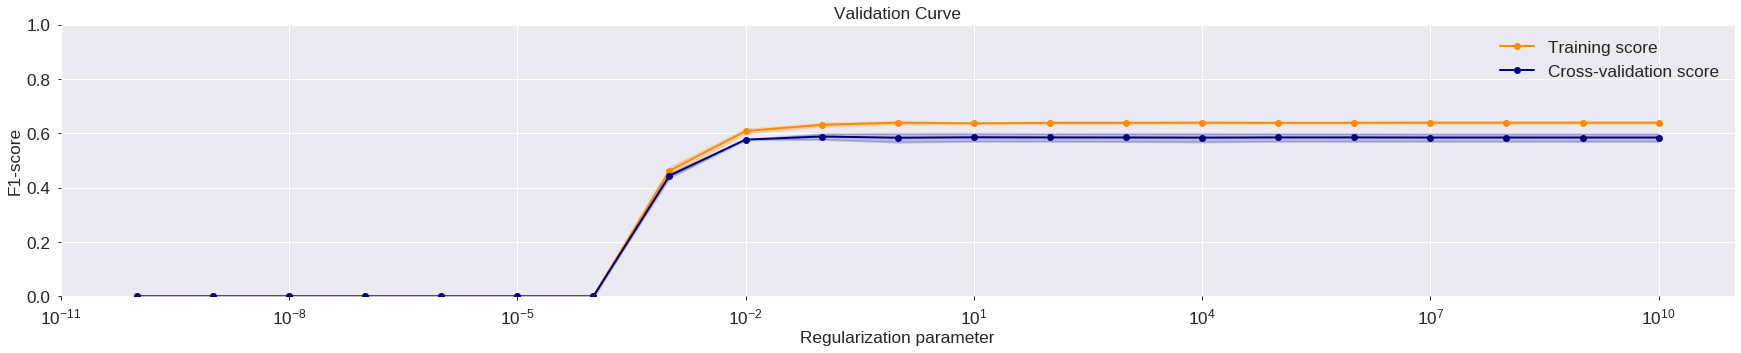

In [159]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores,
                      C_values, 
                      y_label='F1-score',
                      ylim = [0.0, 1],
                      x_label='Regularization parameter', 
                      x_logscale=True)

In [160]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_C_value = C_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter C =", best_C_value)

Best value for the parameter C = 0.1


In [161]:
# Calculate AUC of Regularized Logit Model on test set at best value of C

LR = LogisticRegression(C=0.01, n_jobs=-1, random_state=SEED)
LR.fit(X_train, y_train)
y_hat_logit_prob = LR.predict_proba(X_test)[:,1]

In [162]:
print("F1-score of our best Logit Model:", f1_score(y_test, y_hat_logit_prob > 0.5))

F1-score of our best Logit Model: 0.5193370165745856


### Models comparison

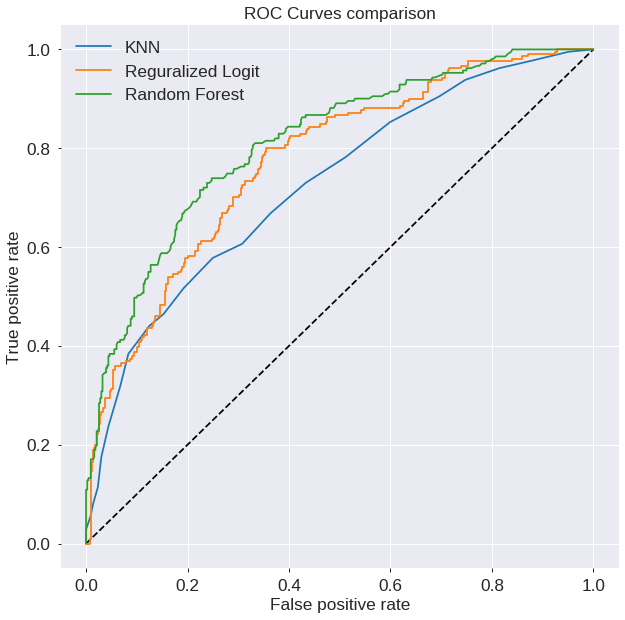

In [130]:
(fpr1, tpr1, thresholds1), model1 = roc_curve(y_test, y_hat_KNN_prob),'KNN'
(fpr2, tpr2, thresholds2), model2 = roc_curve(y_test, y_hat_logit_prob), 'Reguralized Logit'
(fpr3, tpr3, thresholds3), model3 = roc_curve(y_test, y_hat_RF_prob), 'Random Forest'
plot_3rocs(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, model1, model2, model3)

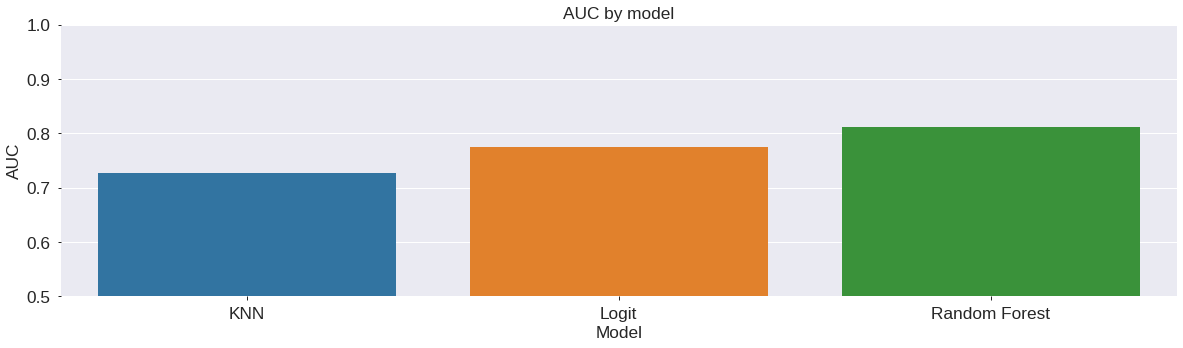

In [131]:
df =  pd.Series({'KNN': roc_auc_score(y_test, y_hat_KNN_prob),
                 'Random Forest': roc_auc_score(y_test, y_hat_RF_prob),
                 'Logit': roc_auc_score(y_test, y_hat_logit_prob)}).reset_index().sort_values(by=0)
plt.figure(figsize=(20,5))
sns.barplot(x='index', y=0, data=df)
plt.title('AUC by model')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.ylim([0.5,1])
plt.show()

It looks like the **Random Forest Model with 700 trees** is the **best performing model**.

We can now find the **threshold maximizing the Fbeta-score** with $\beta = 0.2$ by **cross-validating on the training set**.

In [132]:
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)
RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
thresholds = np.linspace(0,1,50)

train_scores = []
cv_scores = []
for train_indices, cv_indices in cv_schema.split(X_train, y_train):
    RF.fit(X_train[train_indices], y_train[train_indices])
    train_scores_inner = []
    cv_scores_inner = []
    for thresh in thresholds:
        y_hat_prob_train = RF.predict_proba(X_train[train_indices])[:,1] > thresh
        y_hat_prob_cv = RF.predict_proba(X_train[cv_indices])[:,1] > thresh

        train_scores_inner.append(fbeta_score(y_train[train_indices], y_hat_prob_train, beta=0.2))
        cv_scores_inner.append(fbeta_score(y_train[cv_indices], y_hat_prob_cv, beta=0.2))

    train_scores.append(train_scores_inner)
    cv_scores.append(cv_scores_inner)

# Transpose the array so they have the right shape
train_scores = np.ndarray.transpose(np.array(train_scores))
cv_scores = np.ndarray.transpose(np.array(cv_scores))

Threshold maximizing the Fbeta-score: 0.6122448979591836


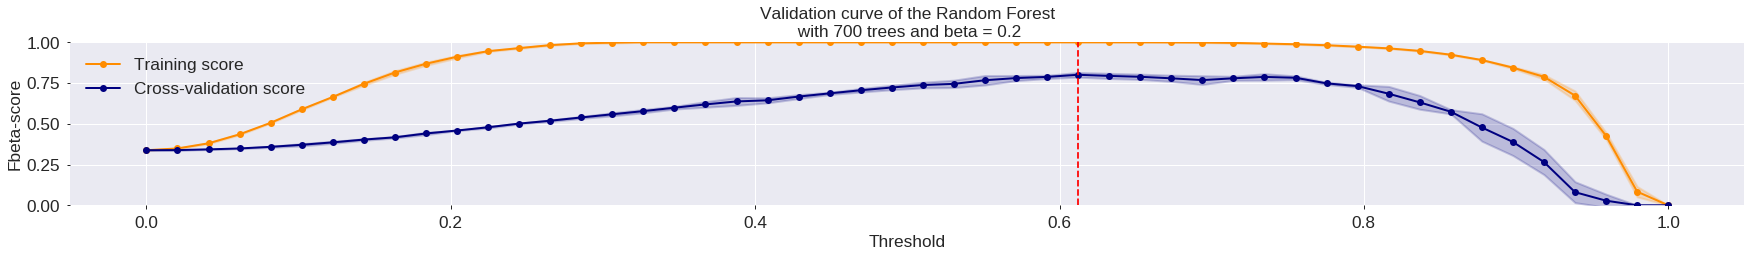

In [133]:
# Plot validation curve
plt.figure(figsize=(30,3))
plot_validation_curve(train_scores, cv_scores,
                      thresholds, 
                      x_label="Threshold",
                      y_label='Fbeta-score',
                      ylim = [0, 1.0],
                      title="Validation curve of the Random Forest\n with 700 trees and beta = 0.2",
                      x_logscale=False, 
                      ax=plt.gca())

# Find best threshold
df = pd.DataFrame(cv_scores, index=thresholds).mean(axis=1)
best_thresh = df.sort_values(ascending=False).reset_index()['index'].iloc[0]
print('Threshold maximizing the Fbeta-score: {}'.format(best_thresh))
plt.axvline(x=best_thresh, c='r', linestyle='--')
plt.show()

### Assessement of the best model

Our **best model** is the **Random Forest Model with 700 trees and a threshold of ~0.61**. 

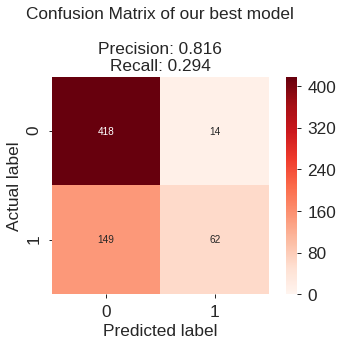

In [134]:
y_hat = RF.predict_proba(X_test)[:,1] > 0.6122
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Confusion Matrix of our best model\n\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title)
    
plt.show()

### What is the influence of $\beta$ ?

In [135]:
# Cross-validate over the training set for several betas
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)
RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
thresholds = np.linspace(0,1,50)

betas = [0.1, 0.2, 0.4]
train_scores_per_beta = []
cv_scores_per_beta = []

for beta in betas:
    train_scores = []
    cv_scores = []
    for train_indices, cv_indices in cv_schema.split(X_train, y_train):
        RF.fit(X_train[train_indices], y_train[train_indices])
        train_scores_inner = []
        cv_scores_inner = []
        for thresh in thresholds:
            y_hat_prob_train = RF.predict_proba(X_train[train_indices])[:,1] > thresh
            y_hat_prob_cv = RF.predict_proba(X_train[cv_indices])[:,1] > thresh

            train_scores_inner.append(fbeta_score(y_train[train_indices], y_hat_prob_train, beta=beta))
            cv_scores_inner.append(fbeta_score(y_train[cv_indices], y_hat_prob_cv, beta=beta))

        train_scores.append(train_scores_inner)
        cv_scores.append(cv_scores_inner)
    
    # Transpose the array so they have the right shape
    train_scores = np.ndarray.transpose(np.array(train_scores))
    cv_scores = np.ndarray.transpose(np.array(cv_scores))
    
    train_scores_per_beta.append(train_scores)
    cv_scores_per_beta.append(cv_scores)

In [136]:
best_thresholds = []
for i, beta in enumerate(betas):
    df = pd.DataFrame(cv_scores_per_beta[i], index=thresholds).mean(axis=1)
    best_thresh = df.sort_values(ascending=False).reset_index()['index'].iloc[0]
    best_thresholds.append(best_thresh)
    print("Threshold yielding highest Fbeta-score (beta: {}): {}".format(beta, best_thresh))

Threshold yielding highest Fbeta-score (beta: 0.1): 0.7551020408163265
Threshold yielding highest Fbeta-score (beta: 0.2): 0.6122448979591836
Threshold yielding highest Fbeta-score (beta: 0.4): 0.5714285714285714


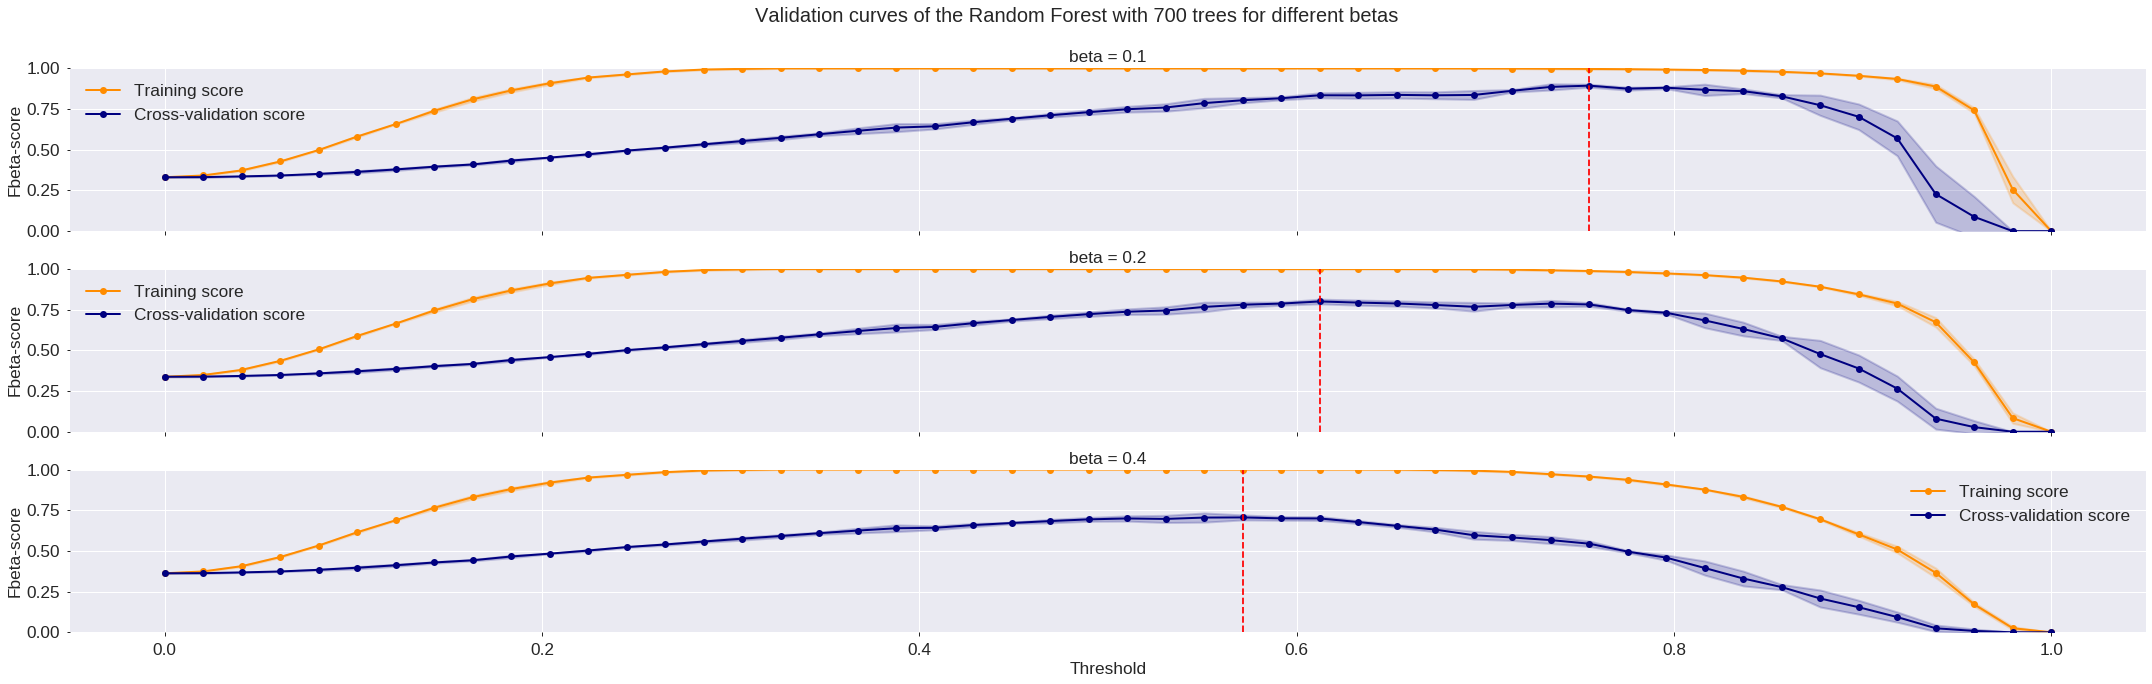

In [137]:
f, axes = plt.subplots(3,1, sharex=True, figsize=(30,9))
for i, beta, ax in zip(range(len(betas)), betas, axes.ravel()):
    plot_validation_curve(train_scores_per_beta[i], cv_scores_per_beta[i],
                          thresholds, 
                          y_label='Fbeta-score',
                          ylim = [0, 1.0],
                          title="beta = " + str(beta),
                          x_logscale=False, 
                          ax=ax)
    ax.axvline(x=best_thresholds[i], c='r', linestyle='--')
    
axes[2].set_xlabel('Threshold')
f.suptitle("Validation curves of the Random Forest with 700 trees for different betas", y=1.05, fontsize=20)
f.tight_layout()
plt.show()

As we can see, **the greater the $\beta$, the lower the threshold**. This makes sense since a greater $\beta$ gives more weight to the recall, and hence we will lower the threshold to "catch" more TP.

In [138]:
RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train);


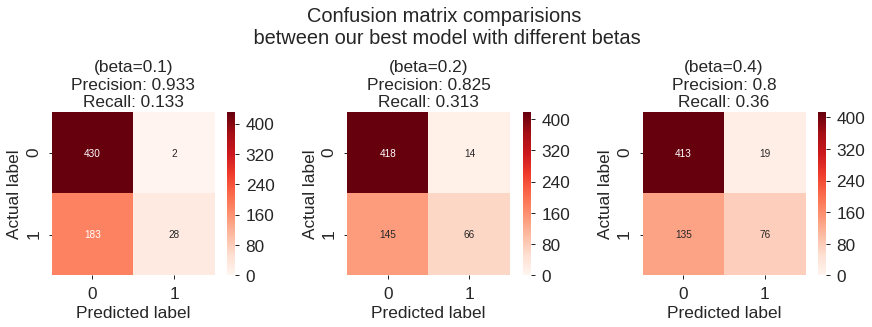

In [139]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
for ax, beta, best_thresh in zip(axes, betas, best_thresholds):
    y_hat = RF.predict_proba(X_test)[:,1] > best_thresh
    cm = confusion_matrix(y_test, y_hat)
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    title = "(beta={})\nPrecision: {}\nRecall: {}".format(beta, round(precision, 3), round(recall, 3))
    plot_confusion_matrix(cm, title=title, ax=ax)
    
plt.suptitle('Confusion matrix comparisions\n between our best model with different betas', y=1.37, x=0.52, fontsize=20)
plt.show()

As expected, by **increasing the $\beta$**, we **give more weight to the recall** while **decreasing the importance of the precision**.

### How does it compare to the baseline ?

As a baseline, we always predict underpriced (i.e. `1`), since it is the most common outcome.

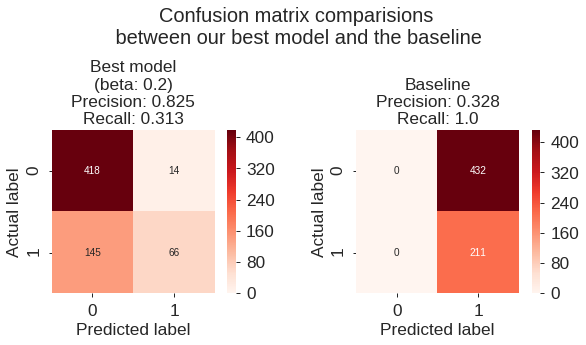

In [140]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
# Best model
best_thresh = 0.6122

RF = RandomForestClassifier(n_estimators=700, n_jobs=-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat = RF.predict_proba(X_test)[:,1] > best_thresh
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Best model\n(beta: 0.2)\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title, ax=axes[0])

# Baseline
y_hat_baseline = np.full_like(y_test, 1)
cm = confusion_matrix(y_test, y_hat_baseline)
precision = precision_score(y_test, y_hat_baseline)
recall = recall_score(y_test, y_hat_baseline)
title = "Baseline\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))

plot_confusion_matrix(cm, title=title, ax=axes[1])

plt.suptitle('Confusion matrix comparisions\n between our best model and the baseline', y=1.45, x=0.52, fontsize=20)

plt.show()

As we can see, the model performs much better than the baseline. Our model has **~30% of the TP for only ~3% of the FP**.

### Which features matter more ?

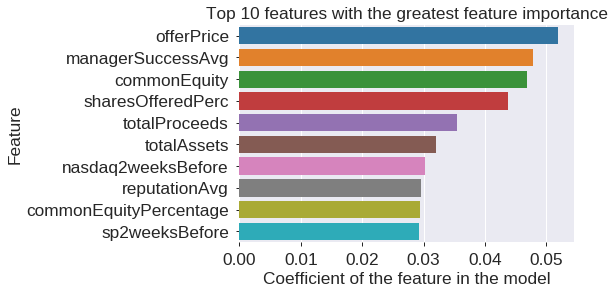

In [141]:
df = pd.DataFrame(RF.feature_importances_, index=P4_FEATURES)

sns.barplot(y='index', x=0, orient="h", data=df.apply(abs).reset_index().sort_values(by=0, ascending=False)[:10])
plt.xlabel('Coefficient of the feature in the model')
plt.ylabel('Feature')
plt.title('Top 10 features with the greatest feature importance')
plt.show()

As in P1, the feature engineering from the `manager` field (i.e. `managerSuccessAvg`) is really important in our model. This shows that the **track record of the managers is a good predictor of their IPOs' success.**

### Predict P4

We can now predict P4 using our best model: **Random Forest** with **700 trees** and a **threshold of ~0.61**

In [66]:
# Predict P3 for the data_to_predict
best_thresh = 0.6122

RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)
pd.to_pickle(pd.Series(RF.predict_proba(X_to_predict)[:,1] > best_thresh), 'P4.pkl')

## Prediction P5

- Predict whether the closing price at the end of the first day of trading will go **down** by more than **20% from the original offer price** (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).

## Our approach for the predictions P5

To predict P5, the following approach is taken:
1. Depending on the prediction at hand, **choose some ML models to test**
2. For each model, **cross-validate on the training set to tune the hyper-parameters** and **choose the hyper-parameter which**:
    - **gives the greatest F1-score** (assuming a threshold of 0.5 if necessary)
3. Compare the **trained models performance on the test set** by **choosing the model** which:
    - has the **highest AUC score** (in case of **classification**)
4. Pick the **best model** as the one with **highest AUC score**
5. Fill in the predictions (e.g. P5)

In [7]:
# Prepare the dataset to learn from
y = np.array(data_to_learn['closeDay1'] < data_to_learn['offerPrice']*0.8)

P5_FEATURES = data_to_learn.drop(['closeDay1'],axis=1).columns

# We use all of the features available
X = np.array(data_to_learn[P5_FEATURES])
X_to_predict = np.array(data_to_predict[P5_FEATURES])

In [8]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_to_predict = scaler.transform(X_to_predict)

In [9]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

### Is our data set balanced ?

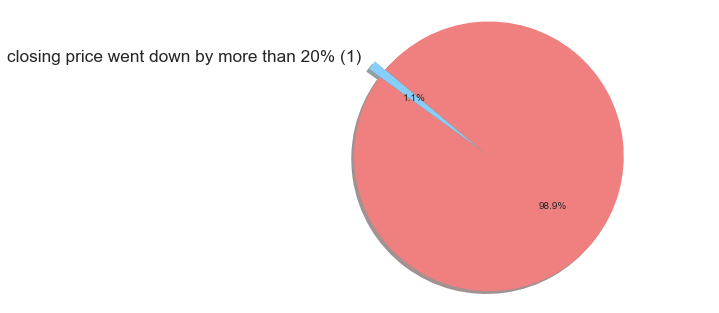

In [333]:
# Data to plot
labels = 'closing price went down by more than 20% (1)', ''
sizes = [sum(y), len(y)-sum(y)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

No, the dataset is **very unbalanced**

### Regularized Logit Model

Let's try to fit a Regularized Logit despite the unbalanceness

In [347]:
# Define model
C_values = np.logspace(-10, 10, num=11, endpoint=True, base=10.0)
LR = LogisticRegression(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

# Now use the validation_curve() function to train/validate models...
train_scores, cv_scores = validation_curve(LR, X_train, y_train,
                                           scoring='f1',
                                           param_name="C", 
                                           param_range=C_values,
                                           cv=cv_schema)

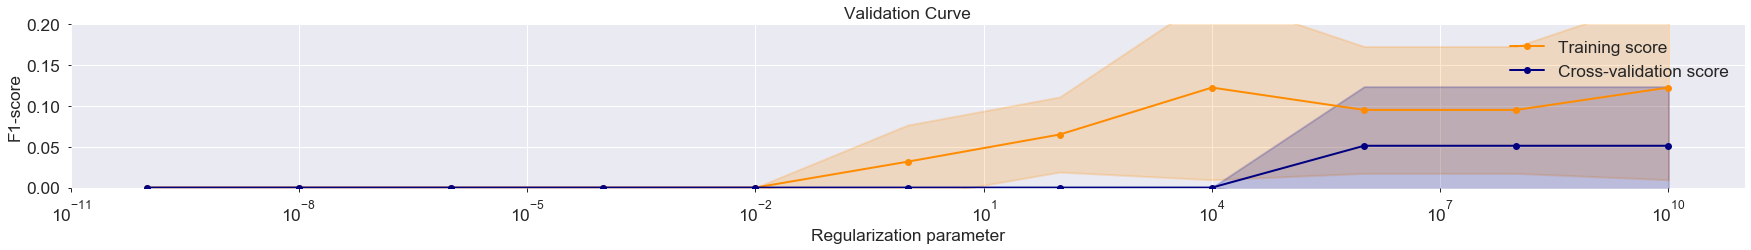

In [348]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plt.figure(figsize=(30,3))
plot_validation_curve(train_scores, cv_scores, C_values, 
                      ylim=[0, 0.2],
                      y_label='F1-score',
                      x_label='Regularization parameter', 
                      x_logscale=True)



As expected, the **F1-score is very bad** (below 0.1 in the best case for cross-validation). This is due to the unbalanceness of the data

In [349]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_C_value = C_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter C =", best_C_value)

Best value for the parameter C = 1000000.0


In [351]:
# Calculate F1 of Regularized Logit Model on test set at best value of C
LR = LogisticRegression(C=best_C_value, n_jobs=-1, random_state=SEED)
LR.fit(X_train, y_train)
y_hat_logit = LR.predict(X_test)
y_hat_logit_prob = LR.predict_proba(X_test)[:,1]

In [370]:
print("F1-score of our best Regularized Logit Model:", f1_score(y_test, y_hat_logit))
print("AUC of our best Regularized Logit Model:", roc_auc_score(y_test, y_hat_logit_prob))

F1-score of our best Regularized Logit Model: 0.0
AUC of our best Regularized Logit Model: 0.6808176100628931


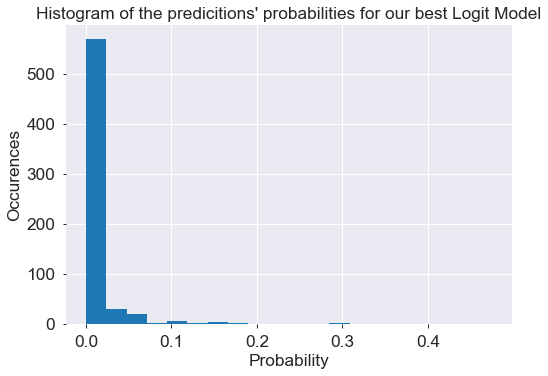

In [353]:
# Plot histogram
pd.DataFrame(y_hat_logit_prob).hist(bins=20)
plt.title("Histogram of the predicitions' probabilities for our best Logit Model")
plt.xlabel("Probability")
plt.ylabel("Occurences")
plt.show()

As we can see, the Model is always very sure that the case is a negative, which makes sense given the unbalanceness of the data.

### KNN

Let's try to fit a KNN despite the unbalanceness

In [173]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(5.0, 500.0, 30)])
model     = KNeighborsClassifier(n_jobs = -1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_KNN, cv_scores_KNN = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name="n_neighbors", 
                                                   param_range = K_values,
                                                   cv=cv_schema)

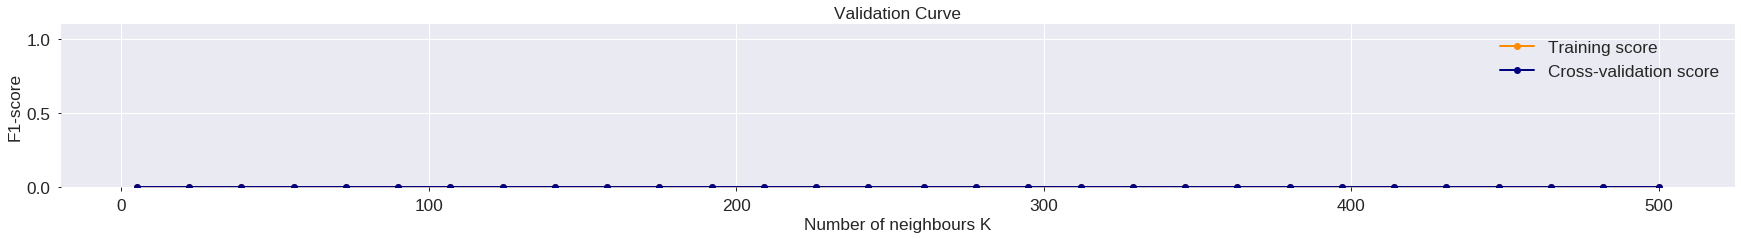

In [186]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,3))
plot_validation_curve(train_scores_KNN, cv_scores_KNN,
                      K_values, y_label='F1-score',
                      x_label='Number of neighbours K', x_logscale=False)

As expected, the model is bad too.

### Random Forest

And finally, let's try to fit a Random Forest despite the unbalanceness

In [190]:
# Use a Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(5.0, 200, 5)])
model     = RandomForestClassifier()
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,
                                                   scoring='f1',
                                                   param_name="n_estimators", 
                                                   param_range=N_values,
                                                   cv=cv_schema)

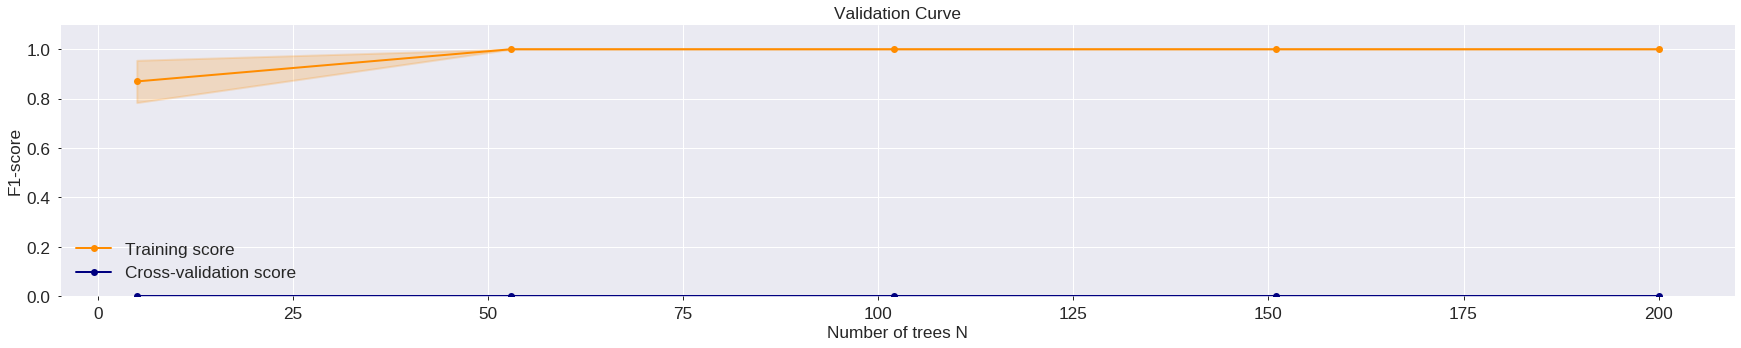

In [191]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores_val, cv_scores_val, \
                      N_values, y_label='F1-score', \
                      x_label='Number of trees N', x_logscale=False)


As expected, the model is bad too.

## Balanced Random Forest

We try to fix the unbalanceness by using a **Balanced Random Forest**

In [10]:
from imblearn.ensemble import BalancedRandomForestClassifier

Using TensorFlow backend.


In [11]:
imRF = BalancedRandomForestClassifier(random_state=SEED)
N_values  = np.array([int(i) for i in np.linspace(5.0, 500.0, 20)])
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(imRF, X_train, y_train,
                                                   scoring='f1',
                                                   param_name = "n_estimators",
                                                   param_range = N_values,
                                                   cv=cv_schema)

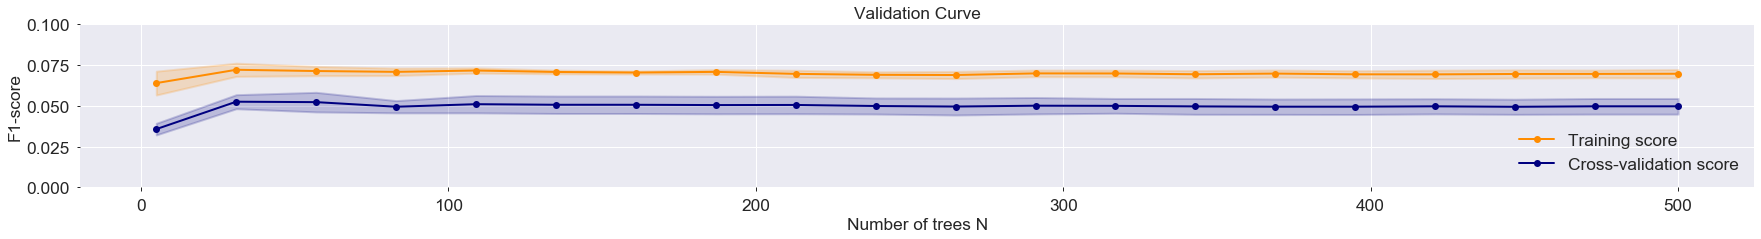

In [12]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,3))
plot_validation_curve(train_scores_val, cv_scores_val, \
                      N_values, y_label='F1-score',
                      ylim=[0,0.1],
                      x_label='Number of trees N', x_logscale=False)


In [13]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores_val, axis=1)
best_N_value = N_values[np.argmax(cv_scores_mean)]
print("Best value for the parameter N = ", best_N_value)

Best value for the parameter N =  31


In [14]:
# Calculate F1 of Random Forest Model on test set at best value of N
imRF = BalancedRandomForestClassifier(n_estimators = best_N_value, n_jobs=-1)
imRF.fit(X_train, y_train)
y_hat_imRF_prob = imRF.predict_proba(X_test)[:,1]

In [15]:
print("F1-score of our best Balanced Random Forest: ", f1_score(y_test, y_hat_imRF_prob > 0.5))
print("AUC of our best Balanced RF:", roc_auc_score(y_test, y_hat_imRF_prob))

F1-score of our best Balanced Random Forest:  0.04950495049504951
AUC of our best Balanced RF: 0.7697663971248877


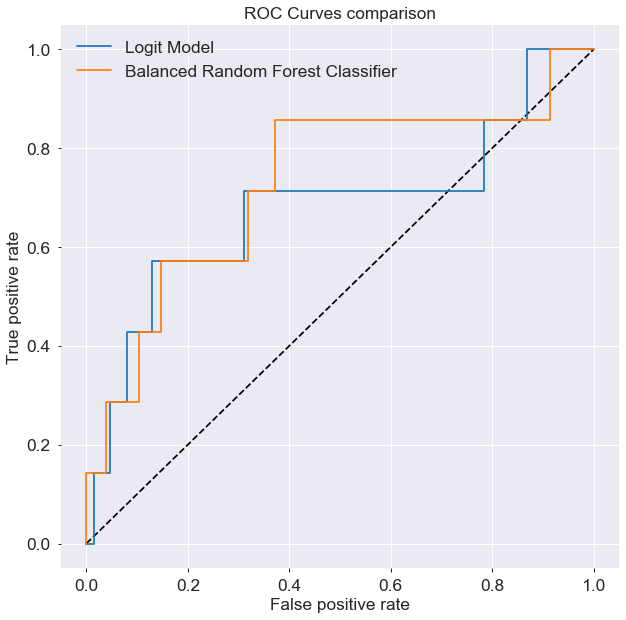

In [382]:
# plot ROC curve
(fpr3, tpr3, thresholds3), model3 = roc_curve(y_test, y_hat_logit_prob), 'Logit Model'
(fpr4, tpr4, thresholds4), model4 = roc_curve(y_test, y_hat_imRF_prob), 'Balanced Random Forest Classifier'
plot_3rocs(fpr3, tpr3, fpr4, tpr4, [0], [0], model3, model4, '')



We are unfortunately unable to develop a good model due to the unbalanceness of the dataset.

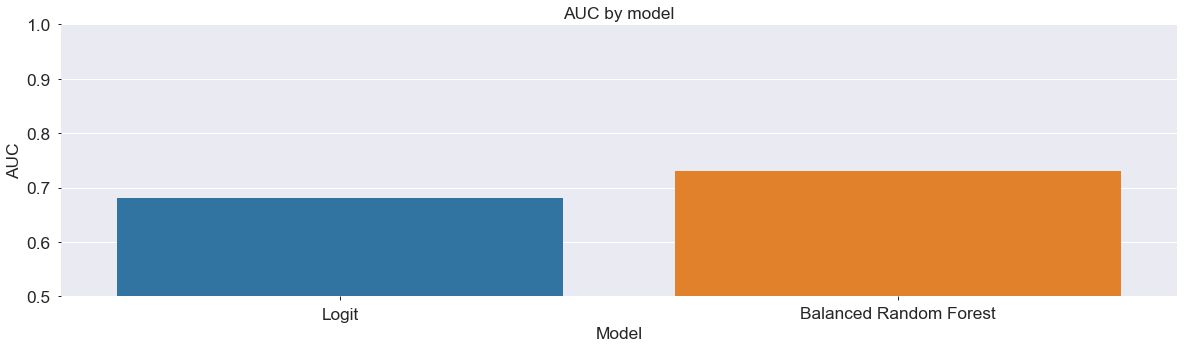

In [383]:
df =  pd.Series({'Balanced Random Forest': roc_auc_score(y_test, y_hat_imRF_prob),
                 'Logit': roc_auc_score(y_test, y_hat_logit_prob)}).reset_index().sort_values(by=0)
plt.figure(figsize=(20,5))
sns.barplot(x='index', y=0, data=df)
plt.title('AUC by model')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.ylim([0.5,1])
plt.show()


It looks like the **Balanced Random Forest Model with 31 trees** is the **best performing model**.

### Assessement of the best model

Our **best model** is the **Balanced Random Forest Model with 31 trees and a threshold of ~0.5**. 

Since the precision of our model is very low, we simply pick a threshold of 0.5.

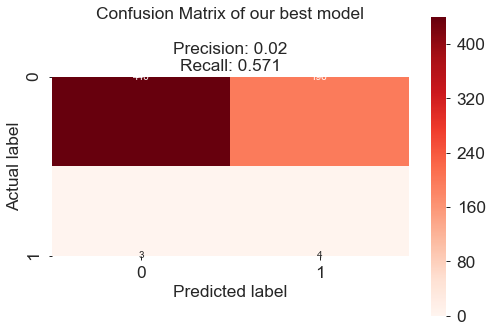

In [390]:
y_hat = imRF.predict_proba(X_test)[:,1] > 0.5
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Confusion Matrix of our best model\n\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title)

plt.show()

### Predict P5

We can now predict P5 using our best model: **Balanced Random Forest** with **31 trees** and a **threshold of 0.5**

Since the precision of our model is very low, we simply pick a threshold of 0.5.

In [17]:
# Predict P5 for the data_to_predict
best_thresh = 0.5

imRF = BalancedRandomForestClassifier(n_estimators=31, n_jobs =-1, random_state=SEED)
imRF.fit(X_train, y_train);


In [18]:
pd.to_pickle(pd.Series(imRF.predict_proba(X_to_predict)[:,1] > best_thresh), 'P5.pkl')

## Prediction P6

- Predict the **share price at the end of the first day**.

## Our approach for the predictions P6

To predict P6, the following approach is taken:
1. We **choose some ML models to test**
2. For each model, **cross-validate on the training set to tune the hyper-parameters** and **choose the hyper-parameter which**:
    - **gives the lowest Mean Squared Error (MSE)**
3. Compare the **trained models performance on the test set** by **choosing the model** which:
    - has the **lowest MSE** (in case of **regression**)
4. Pick the **best model** as the one with **lowest MSE**
5. Fill in the predictions (e.g. P6)

### Split into test, train, validation sets

From the data to train from, 20% is test set, 20% is train set and 20% is test set

In [67]:
# Prepare the dataset to learn from
y = data_to_learn['closeDay1']

P6_FEATURES = data_to_learn.drop(['closeDay1'], axis=1).columns 

X = data_to_learn[P6_FEATURES]
X_to_predict = data_to_predict[P6_FEATURES]

### Features standardization

In [68]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_to_predict = scaler.transform(X_to_predict)

In [69]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)


### Baseline

As a baseline, we will take the mean of the training set

In [167]:
mse = {}
mse['Baseline'] = mean_squared_error(y_test, y_test.shape[0]*[y_train.mean()])

print("MSE of Baseline on the test set:", mse['Baseline'])

MSE of Baseline on the test set: 187.71531302163342


### Linear Regression 

In [168]:
linear_regression = LinearRegression(n_jobs=-1)
linear_regression.fit(X_train, y_train)

mse['Linear Regression'] = mean_squared_error(y_test, linear_regression.predict(X_test))

print("MSE of Linear Regression on the test set:", mse['Linear Regression'])

MSE of Linear Regression on the test set: 91.91655034445245


### Lasso

We cross-validate on the MSE

In [169]:
# Define model
alpha_values = np.logspace(-10, 10, num=21, endpoint=True, base=10.0)
lasso = Lasso(random_state=SEED)


In [170]:
train_scores, cv_scores = validation_curve(lasso, X_train, y_train,
                                           scoring='neg_mean_squared_error',
                                           param_name = "alpha", param_range = alpha_values,
                                           cv=3)

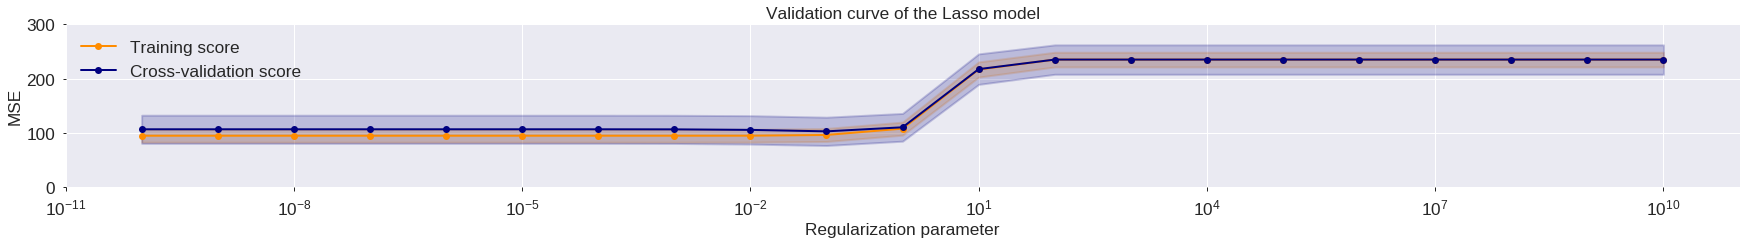

In [171]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plt.figure(figsize=(30,3))
plot_validation_curve(-train_scores, -cv_scores, alpha_values, y_label='MSE', ylim=[0,300], x_label='Regularization parameter', x_logscale=True, title="Validation curve of the Lasso model")

In [172]:
# Calculate MSE of Lasso Model on test set at best value of alpha
alpha = 1e-3
lasso = Lasso(alpha=alpha, random_state=SEED)
lasso.fit(X_train, y_train)

mse['Lasso'] = mean_squared_error(y_test, lasso.predict(X_test))

print("MSE of Lasso on the test set:", mse['Lasso'])

MSE of Lasso on the test set: 91.81746404761493


### Ridge 

In [173]:
# Define model
alpha_values = np.logspace(-10, 10, num=21, endpoint=True, base=10.0)
ridge = Ridge(random_state=SEED)


In [174]:
train_scores, cv_scores = validation_curve(ridge, X_train, y_train,
                                           scoring='neg_mean_squared_error',
                                           param_name = "alpha", param_range = alpha_values,
                                           cv=3)

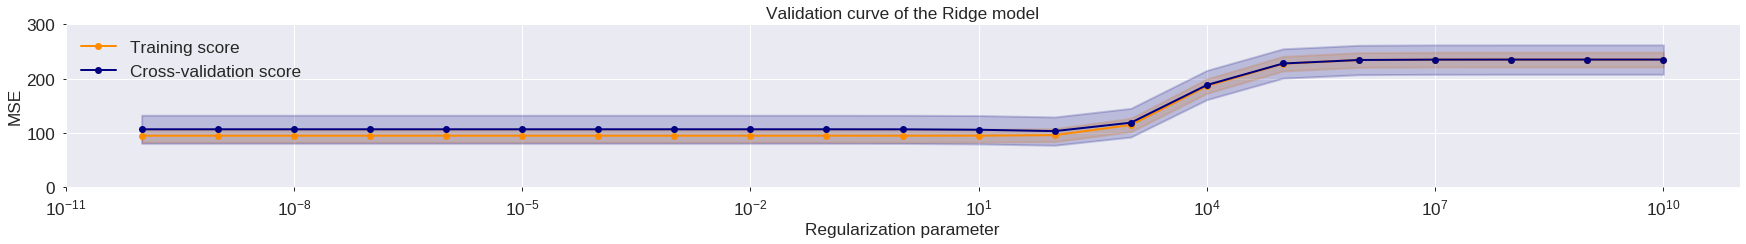

In [175]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plt.figure(figsize=(30,3))
plot_validation_curve(-train_scores, -cv_scores, alpha_values, y_label='MSE', ylim=[0,300], x_label='Regularization parameter', x_logscale=True, title="Validation curve of the Ridge model")

In [176]:
# Calculate MSE of Lasso Model on test set at best value of alpha
alpha = 1e1
ridge = Ridge(alpha=alpha, random_state=SEED)
ridge.fit(X_train, y_train)

mse['Ridge'] =  mean_squared_error(y_test, ridge.predict(X_test))

print("MSE of Lasso on the test set:", mse['Ridge'])

MSE of Lasso on the test set: 91.78812899466057


### Elastic Net

In [177]:
# Define model
alpha_values = np.logspace(-10, 10, num=21, endpoint=True, base=10.0)
elastic_net = ElasticNet(random_state=SEED)


In [178]:
train_scores, cv_scores = validation_curve(elastic_net, X_train, y_train,
                                           scoring='neg_mean_squared_error',
                                           param_name = "alpha", param_range = alpha_values,
                                           cv=3)

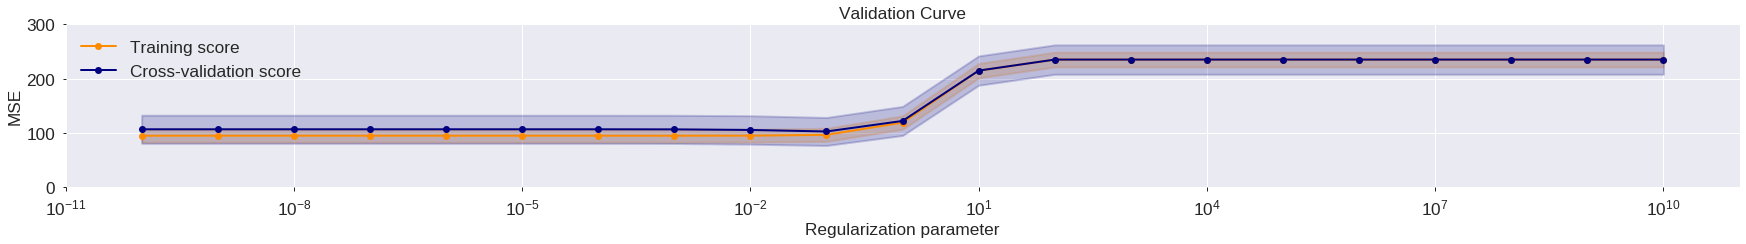

In [179]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plt.figure(figsize=(30,3))
plot_validation_curve(-train_scores, -cv_scores, alpha_values, y_label='MSE', ylim=[0,300], x_label='Regularization parameter', x_logscale=True)

In [180]:
# Calculate MSE of Lasso Model on test set at best value of alpha
alpha = 1e-2
elastic_net = ElasticNet(alpha=alpha, random_state=SEED)
elastic_net.fit(X_train, y_train)

mse['Elastic Net'] =  mean_squared_error(y_test, elastic_net.predict(X_test))

print("MSE of Elastic Net on the test set:", mse['Elastic Net'])

MSE of Elastic Net on the test set: 91.69776374740354


### Comparision

#### MSE

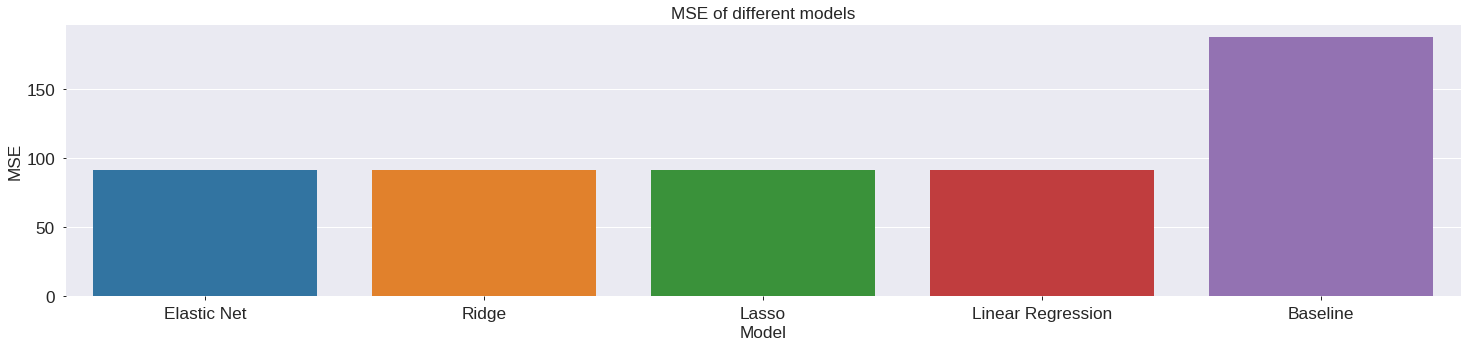

In [181]:
plt.figure(figsize=(25,5))
df = pd.Series(mse)
sns.barplot(x='index', y=0, data=df.reset_index().sort_values(by=0))

plt.title('MSE of different models')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

We notice that **Elastic Net** has to lowest MSE. Hence we use pick this model.

### Assessment of the best model

We pick **Elastic Net** with a **alpha of 0.01**

In [70]:
alpha = 1e-2
elastic_net = ElasticNet(alpha=alpha, random_state=SEED)
elastic_net.fit(X_train, y_train);

### Which features matter more ?

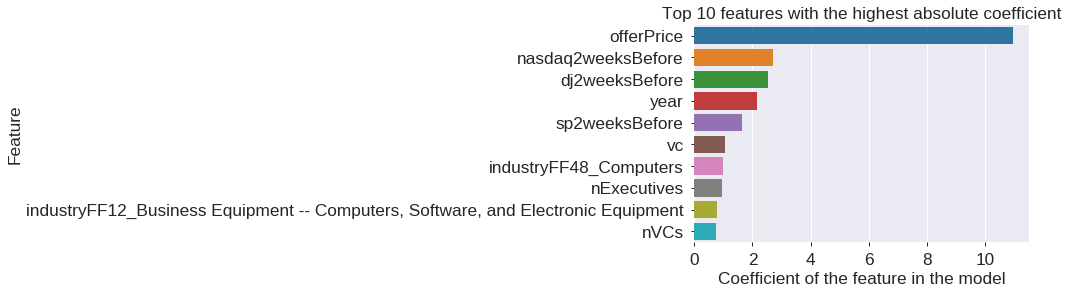

In [71]:
df = pd.DataFrame(elastic_net.coef_.reshape([-1]), index=P6_FEATURES)

sns.barplot(y='index', x=0, orient="h", data=df.apply(abs).reset_index().sort_values(by=0, ascending=False)[:10])
plt.xlabel('Coefficient of the feature in the model')
plt.ylabel('Feature')
plt.title('Top 10 features with the highest absolute coefficient')
plt.show()

### Predict P6

We can now predict P6 using our best model: **Elastic Net** with **alpha = 0.01**

In [72]:
# Predict P6 for the data_to_predict
alpha = 1e-2
elastic_net = ElasticNet(alpha=alpha, random_state=SEED)
elastic_net.fit(X_train, y_train)

pd.to_pickle(pd.Series(elastic_net.predict(X_to_predict)), 'P6.pkl')

## Our approach for the predictions P7, P8, P9

- We tune each model's hyperparameters by **cross-validating on the training set** (e.g. `n_neighbors` for KNN) 
- We select the hyperparameter which **minimizes the custom score** based on the predicted probabilities .
- We then **compare the models** and **choose the model with the smallest custom score.** 

## Prediction P7

- Predict the probability that the closing price at the end of the first day of trading will go up by more than 5% from the original offer price.
Scoring Metric for P7: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score of p * p (i.e., the square of your predicted probability for that event) will be assessed. For predictions where the event turns out to be TRUE, a score of (100 - p) * (100 - p) will be assessed (i.e., the square of 100 minus your predicted probability for that event). Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, then the score for that observation would equal 4,900 (70 * 70 = 4,900); but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 900 (100 - 70 = 30, and 30 * 30 = 900).

In [19]:
# Prepare the dataset to learn from
y = np.array(data_to_learn['closeDay1'] > data_to_learn['offerPrice']*1.05)

# We use all of the features available
X = np.array(data_to_learn.drop(['closeDay1'],axis=1))

In [20]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [21]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

### Is our data set balanced ?

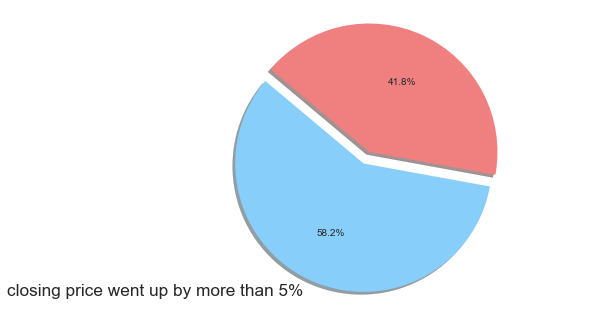

In [22]:
# Data to plot
labels = 'closing price went up by more than 5%', ''
sizes = [sum(y), len(y)-sum(y)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

The dataset is balanced. We can continue with the models.

### Baseline

In [23]:
# making scorer function according to description (low score is better)
def custom_scorer(y, y_pred):
    scores = []
    for value,pred in zip(y, y_pred):
        if value: scores.append((1-pred)**2)
        else: scores.append(pred**2)
    return np.mean(scores)*100

In [24]:
P7_scores = {}
P7_scores['Baseline'] = custom_scorer(y_test, np.full_like(y_test, 1))

print("Score on the test set is equal to: ", P7_scores['Baseline'])

Score on the test set is equal to:  41.679626749611195


### KNN

In [25]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(5.0, 100.0, 20)])
model     = KNeighborsClassifier()
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [26]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for k in K_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(n_neighbors= k)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

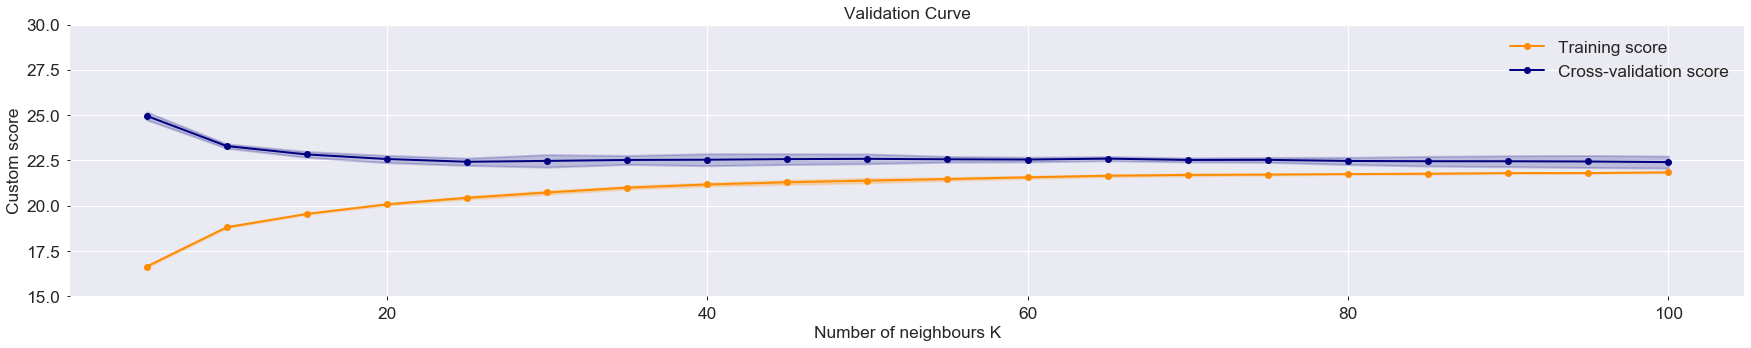

In [27]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      K_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=False, ylim = [15,30])

In [28]:
# Obtain the best value of the hyper parameter
cv_scores_mean_KNN = np.mean(cv_scores, axis=1)
best_K_value = K_values[np.argmin(cv_scores_mean_KNN)]
print("Best value for the parameter K =", best_K_value)

Best value for the parameter K = 100


We choose K = 60 since k = 100 is too much and will probably increase the bias of the model.

In [29]:
# Calculate Accuracy of KNN Model on test set at best value of K
KNN = KNeighborsClassifier(n_neighbors = 60, n_jobs=-1)
KNN.fit(X_train, y_train)
y_hat_KNN_prob = KNN.predict_proba(X_test)[:,1]

In [30]:
P7_scores['KNN'] = custom_scorer(y_test, y_hat_KNN_prob)
print("Custom score on the test set is equal to: ", P7_scores['KNN'])
print("Accuracy on the test set is equal to: ", KNN.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_KNN_prob))

Custom score on the test set is equal to:  21.639320891653703
Accuracy on the test set is equal to:  0.6531881804043546
Area under curve is equal to:  0.6992487562189054


### Random Forest

In [31]:
# Use a Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(1.0, 40.0, 20)])
model     = RandomForestClassifier()
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,\
                                                   param_name = "n_estimators", param_range = N_values,\
                                                   cv=cv_schema)

In [32]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for n in N_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(n_estimators= n)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

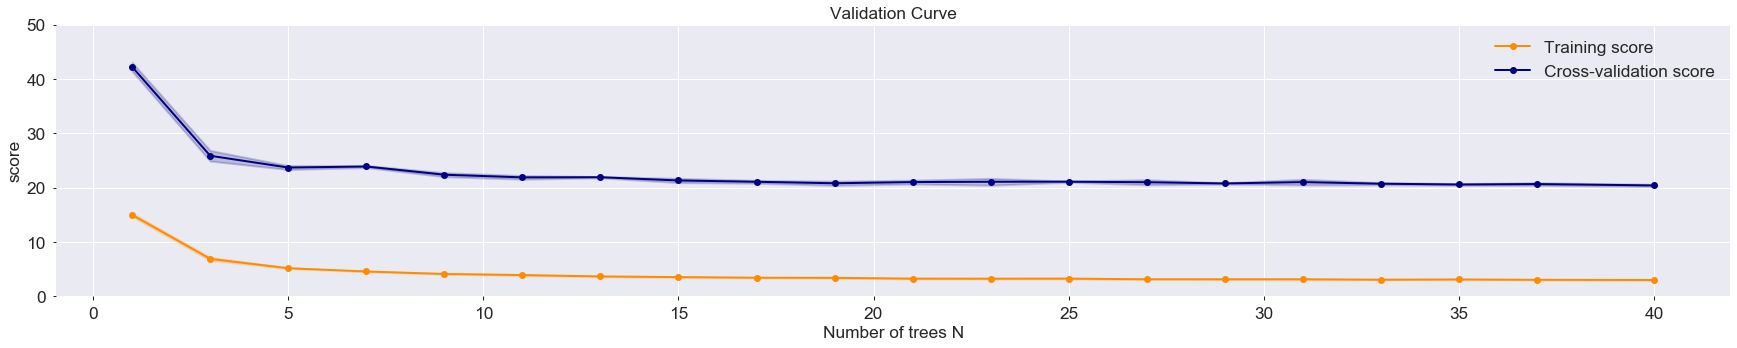

In [33]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      N_values, y_label='score', \
                      x_label='Number of trees N', x_logscale=False, ylim = [0,50])


In [34]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_N_value = N_values[np.argmin(cv_scores_mean)]
print("Best value for the parameter N = ", best_N_value)

Best value for the parameter N =  40


In [35]:
# Calculate Accuracy of Random Forest Model on test set at best value of N
RF = RandomForestClassifier(n_estimators = best_N_value, n_jobs=-1)
RF.fit(X_train, y_train)
y_hat_RF_prob = RF.predict_proba(X_test)[:,1]

In [36]:
P7_scores['Random Forest'] = custom_scorer(y_test, y_hat_RF_prob)
print("Custom score on the test set is equal to: ", P7_scores['Random Forest'])
print("Accuracy on the test set is equal to: ", RF.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_RF_prob))

Custom score on the test set is equal to:  20.004374027993784
Accuracy on the test set is equal to:  0.687402799377916
Area under curve is equal to:  0.7441044776119403


### Regularized logistic regression

In [37]:
# Define model
C_values = np.logspace(-10, 10, num=21, endpoint=True, base=10.0)
model = LogisticRegression()
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [38]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for c in C_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(C= c)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

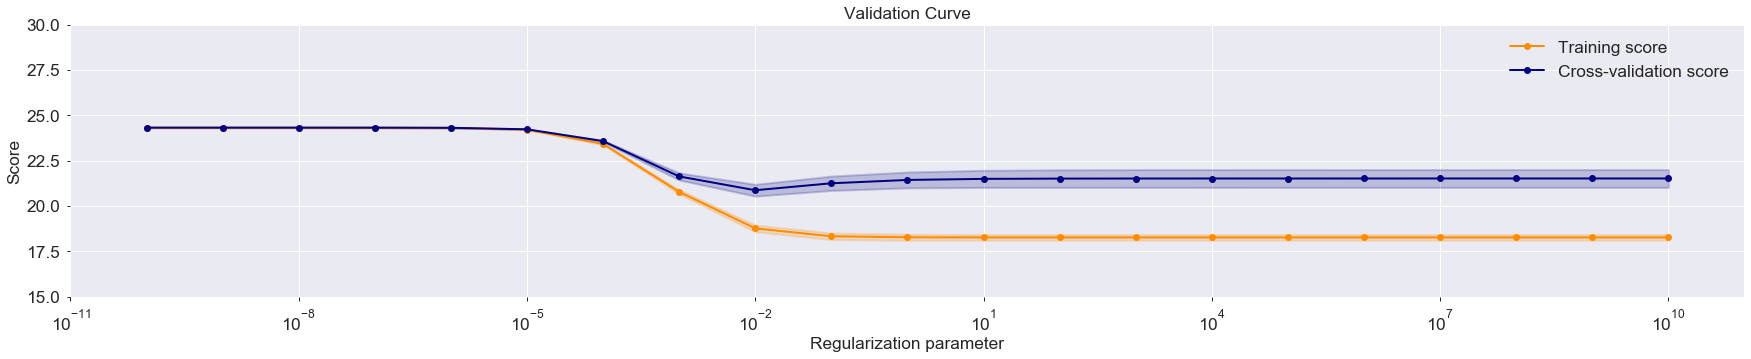

In [39]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, C_values, y_label='Score',\
                      x_label='Regularization parameter', x_logscale=True, ylim = [15,30])

In [40]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_C_value = C_values[np.argmin(cv_scores_mean)]
print("Best value for the parameter C = ", best_C_value)

Best value for the parameter C =  0.01


In [41]:
# Calculate Accuracy of Regularized Logit Model on test set at best value of C
LR = LogisticRegression(C = best_C_value, n_jobs=-1)
LR.fit(X_train, y_train)
y_hat_logit = LR.predict(X_test)
y_hat_logit_prob = LR.predict_proba(X_test)[:,1]

In [42]:
P7_scores['Logit'] = custom_scorer(y_test, y_hat_logit_prob)
print("Custom score on the test set is equal to: ", P7_scores['Logit'])
print("Accuracy on the test set is equal to: ", LR.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_logit_prob))

Custom score on the test set is equal to:  19.25130027929185
Accuracy on the test set is equal to:  0.71850699844479
Area under curve is equal to:  0.7701890547263681


### Models comparison

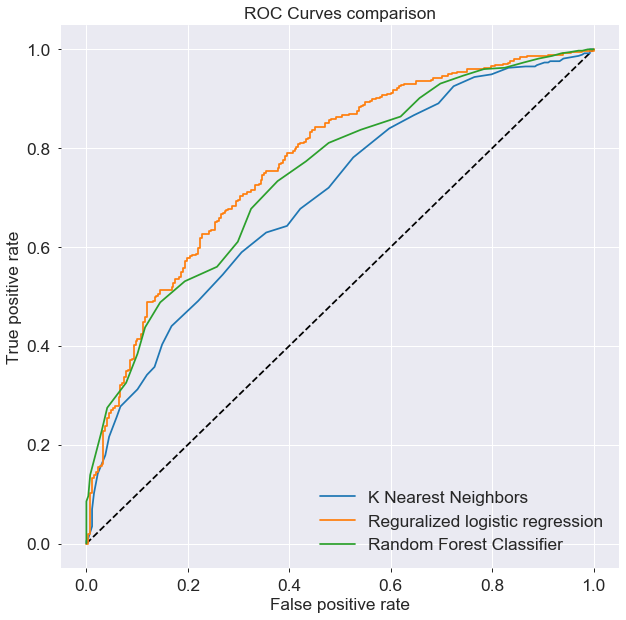

In [43]:
(fpr1, tpr1, thresholds1), model1 = roc_curve(y_test, y_hat_KNN_prob),'K Nearest Neighbors'
(fpr2, tpr2, thresholds2), model2 = roc_curve(y_test, y_hat_logit_prob), 'Reguralized logistic regression'
(fpr3, tpr3, thresholds3), model3 = roc_curve(y_test, y_hat_RF_prob), 'Random Forest Classifier'
plot_3rocs(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, model1, model2, model3)

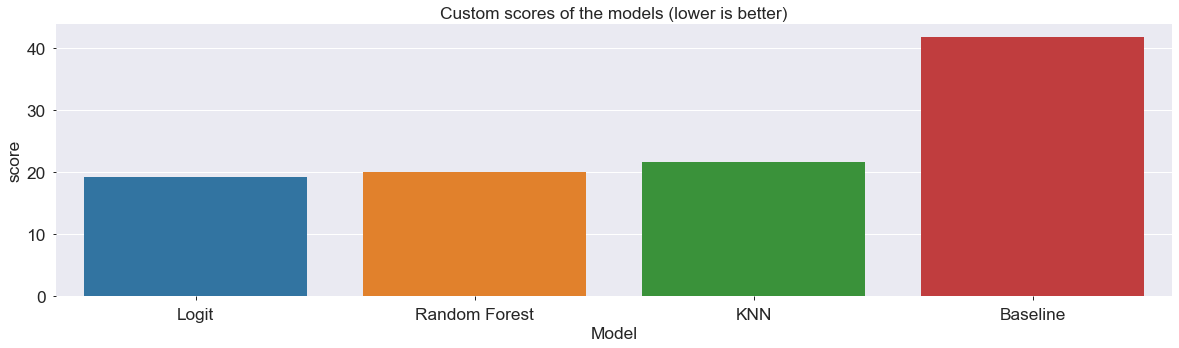

In [44]:
plt.figure(figsize=(20,5))
sns.barplot(x='index', y=0, data=pd.Series(P7_scores).reset_index().sort_values(by=0))
plt.title('Custom scores of the models (lower is better)')
plt.xlabel('Model')
plt.ylabel('score')
plt.show()

It looks like the logit model is the best performing model.

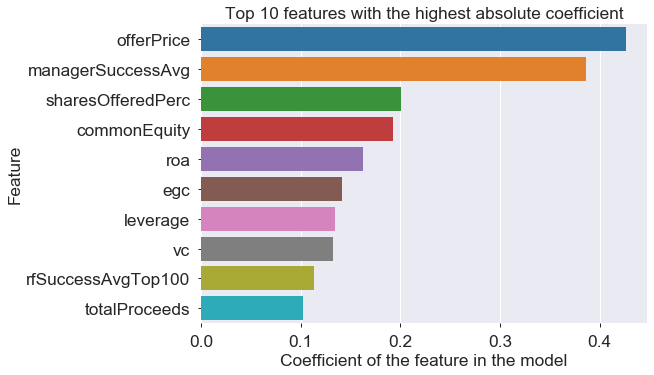

In [45]:
# Most important features of the best model
df = pd.DataFrame(LR.coef_.reshape([-1]), index=data_to_learn.columns[1:])

sns.barplot(y='index', x=0, orient="h", data=df.apply(abs).reset_index().sort_values(by=0, ascending=False)[:10])
plt.xlabel('Coefficient of the feature in the model')
plt.ylabel('Feature')
plt.title('Top 10 features with the highest absolute coefficient')
plt.show()

In [46]:
# predict P7
FEATURES = data_to_learn.drop(['closeDay1'], axis=1).columns

X_to_predict = np.array(data_to_predict[FEATURES])
X_to_predict = scaler.transform(X_to_predict)        # standardize features

pd.to_pickle(pd.Series(LR.predict_proba(X_to_predict)[:,1]), 'P7.pkl')

## Prediction P8

- Predict the probability that the closing price at the end of the first day of trading will go up by more than 50% from the original offer price.

Scoring Metric for P8: Same scoring metric as P7 above. Attempt to tune you prediction model(s) accordingly.

### Methology

We train each model over some range of its hyper parameter (ex: n_neighbors for KNN), compute the custom score based on the predicted probabilities for each hyper parameter and take the best hyper parameter (the one giving the smaller score) for each model. We then compare the models and choose the best one (with smallest best score).

In [47]:
# Prepare the dataset to learn from
y = np.array(data_to_learn['closeDay1'] > data_to_learn['offerPrice']*1.5)

# We use all of the features available
X = np.array(data_to_learn.drop(['closeDay1'],axis=1))

In [48]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [49]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

### Is our data set balanced ?

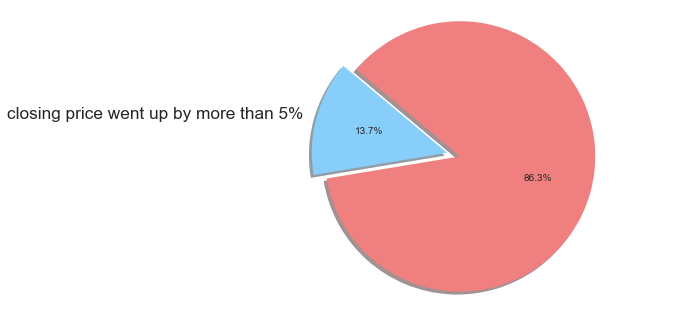

In [50]:
# Data to plot
labels = 'closing price went up by more than 5%', ''
sizes = [sum(y), len(y)-sum(y)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

The dataset is quite balanced. We can continue with the models.

### Baseline

In [51]:
P8_scores = {}
P8_scores['Baseline'] = custom_scorer(y_test, np.full_like(y_test, 0))

print("Score on the test set is equal to: ", P8_scores['Baseline'])

Score on the test set is equal to:  13.685847589424572


### KNN

In [52]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(5.0, 100.0, 20)])
model     = KNeighborsClassifier(n_jobs=-1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [53]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for k in K_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(n_neighbors= k)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

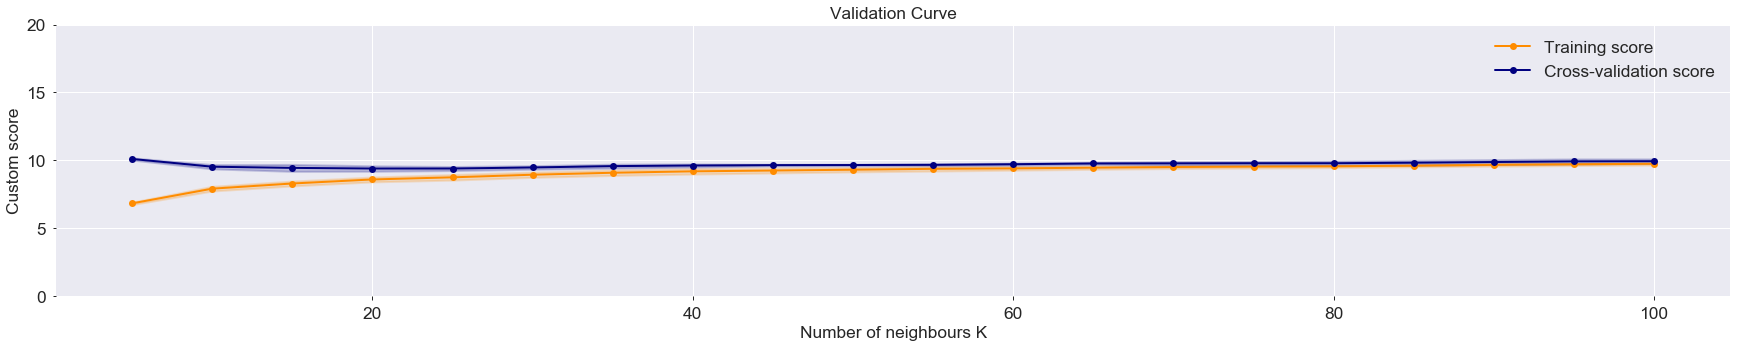

In [54]:
# Plot a validation curve across levels of K

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      K_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=False, ylim = [0,20])

In [55]:
# Obtain the best value of the hyper parameter
cv_scores_mean_KNN = np.mean(cv_scores, axis=1)
best_K_value = K_values[np.argmin(cv_scores_mean_KNN)]
print("Best value for the parameter K =", best_K_value)

Best value for the parameter K = 25


In [56]:
# Calculate Accuracy of KNN Model on test set at best value of K
KNN = KNeighborsClassifier(n_neighbors = best_K_value, n_jobs=-1)
KNN.fit(X_train, y_train)
y_hat_KNN_prob = KNN.predict_proba(X_test)[:,1]

In [57]:
P8_scores['KNN'] = custom_scorer(y_test, y_hat_KNN_prob)
print("Custom score on the test set is equal to: ", P8_scores['KNN'])
print("Accuracy on the test set is equal to: ", KNN.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_KNN_prob))

Custom score on the test set is equal to:  9.304385692068431
Accuracy on the test set is equal to:  0.8786936236391913
Area under curve is equal to:  0.8207309582309583


### Random Forest

In [58]:
# Use a Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(1.0, 40.0, 20)])
model     = RandomForestClassifier(n_jobs=-1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [59]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for n in N_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(n_estimators= n)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

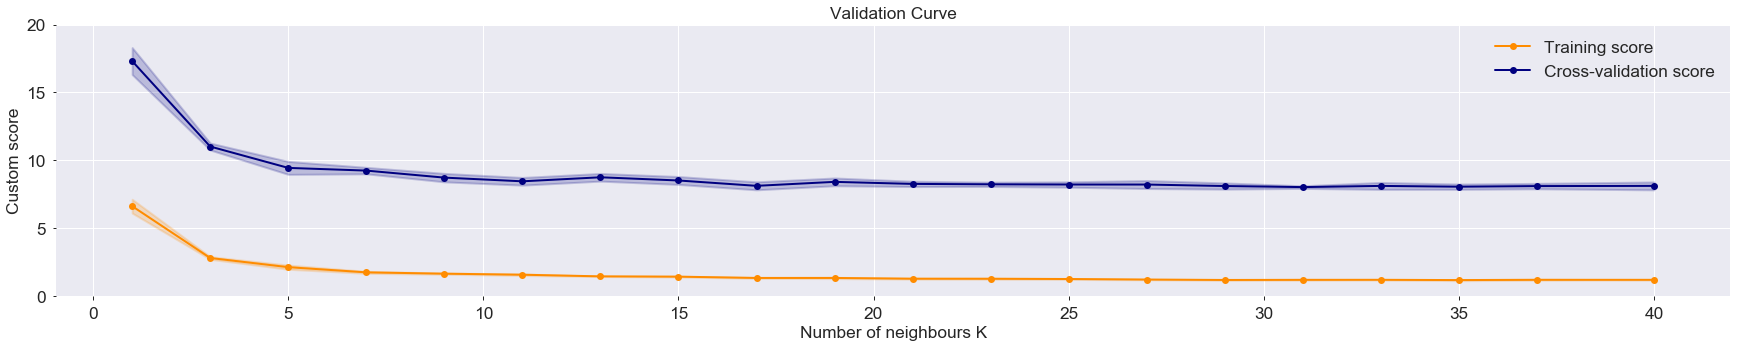

In [60]:
# Plot a validation curve across levels of N

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      N_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=False, ylim = [0,20])


In [61]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_N_value = N_values[np.argmin(cv_scores_mean)]
print("Best value for the parameter N = ", best_N_value)

Best value for the parameter N =  31


In [62]:
# Calculate Accuracy of Random Forest Model on test set at best value of N
RF = RandomForestClassifier(n_estimators = best_N_value, n_jobs=-1)
RF.fit(X_train, y_train)
y_hat_RF_prob = RF.predict_proba(X_test)[:,1]

In [63]:
P8_scores['Random Forest'] = custom_scorer(y_test, y_hat_RF_prob)
print("Custom score on the test set is equal to: ", P8_scores['Random Forest'])
print("Accuracy on the test set is equal to: ", RF.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_RF_prob))

Custom score on the test set is equal to:  8.386158145917857
Accuracy on the test set is equal to:  0.8849144634525661
Area under curve is equal to:  0.8691339066339067


### Regularized logistic regression

In [64]:
# Define model
C_values = np.logspace(-20, 10, num=21, endpoint=True, base=10.0)
model = LogisticRegression()
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [65]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for c in C_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(C= c)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

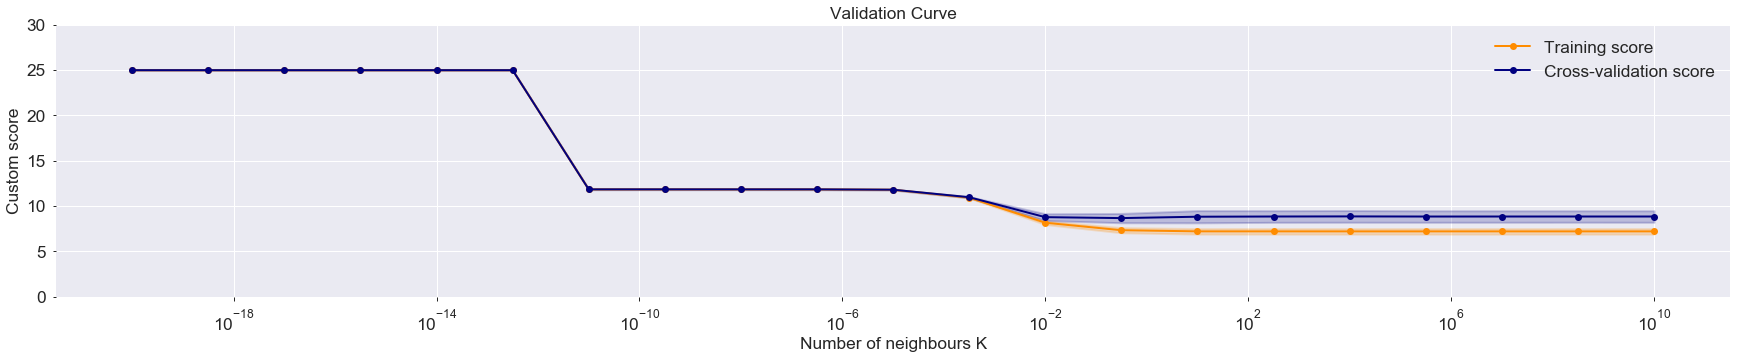

In [66]:
# Plot a validation curve across levels of C, using a logscale for the x axis

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      C_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=True, ylim = [0,30])

In [67]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_C_value = C_values[np.argmin(cv_scores_mean)]
print("Best value for the parameter C = ", best_C_value)

Best value for the parameter C =  0.31622776601683794


In [68]:
# Calculate Accuracy of Regularized Logit Model on test set at best value of C
LR = LogisticRegression(C = best_C_value, n_jobs=-1)
LR.fit(X_train, y_train)
y_hat_logit = LR.predict(X_test)
y_hat_logit_prob = LR.predict_proba(X_test)[:,1]

In [69]:
P8_scores['Logit'] = custom_scorer(y_test, y_hat_logit_prob)
print("Custom score on the test set is equal to: ", P8_scores['Logit'])
print("Accuracy on the test set is equal to: ", LR.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_logit_prob))

Custom score on the test set is equal to:  8.607422302536964
Accuracy on the test set is equal to:  0.8740279937791602
Area under curve is equal to:  0.851965601965602


### Models comparison

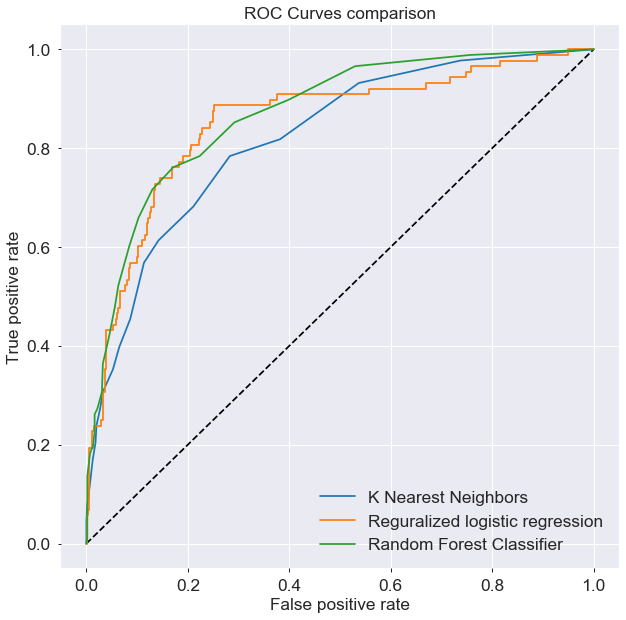

In [70]:
(fpr1, tpr1, thresholds1), model1 = roc_curve(y_test, y_hat_KNN_prob),'K Nearest Neighbors'
(fpr2, tpr2, thresholds2), model2 = roc_curve(y_test, y_hat_logit_prob), 'Reguralized logistic regression'
(fpr3, tpr3, thresholds3), model3 = roc_curve(y_test, y_hat_RF_prob), 'Random Forest Classifier'
plot_3rocs(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, model1, model2, model3)

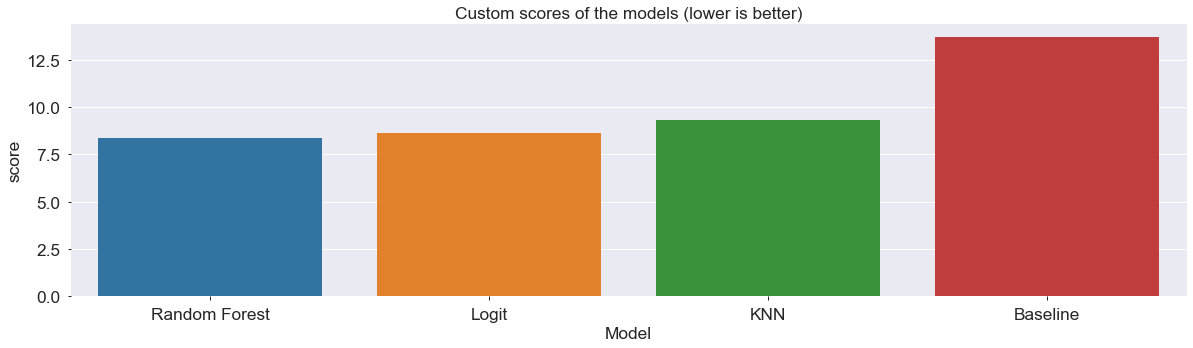

In [71]:
plt.figure(figsize=(20,5))
sns.barplot(x='index', y=0, data=pd.Series(P8_scores).reset_index().sort_values(by=0))
plt.title('Custom scores of the models (lower is better)')
plt.xlabel('Model')
plt.ylabel('score')
plt.show()

It looks like the random forest classifier is the best performing model.

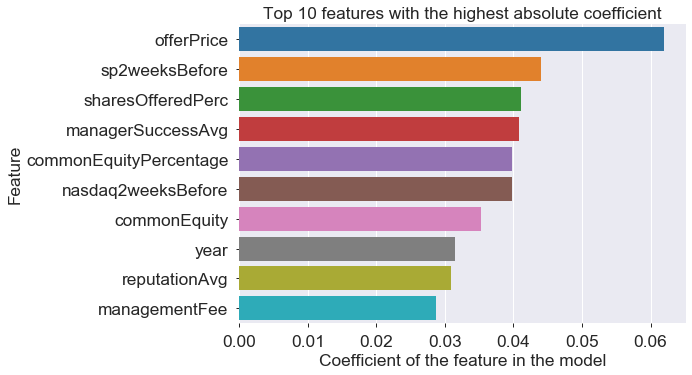

In [72]:
# Most important features of the best model
df = pd.DataFrame(RF.feature_importances_, index=FEATURES)

sns.barplot(y='index', x=0, orient="h", data=df.apply(abs).reset_index().sort_values(by=0, ascending=False)[:10])
plt.xlabel('Coefficient of the feature in the model')
plt.ylabel('Feature')
plt.title('Top 10 features with the highest absolute coefficient')
plt.show()

In [73]:
# predict P8

pd.to_pickle(pd.Series(RF.predict_proba(X_to_predict)[:,1]), 'P8.pkl')

## Prediction P9

- Predict the probability that the closing price at the end of the first day of trading will go down (the "positive" case, coded as 1) or not (coded as 0) by more than 10% from the original offer price.

Scoring Metric for P9: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score equal to p will be assessed. For predictions where the event turns out to be TRUE, a score of 2 * (100 - p) will be assessed. Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, the score for that observation would equal 70; but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 2 * (100 - 70) = 60.

In [74]:
# Prepare the dataset to learn from
y = np.array(data_to_learn['closeDay1'] < data_to_learn['offerPrice']*0.9)

# We use all of the features available
X = np.array(data_to_learn.drop(['closeDay1'],axis=1))

In [75]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [76]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

### Is our data set balanced ?

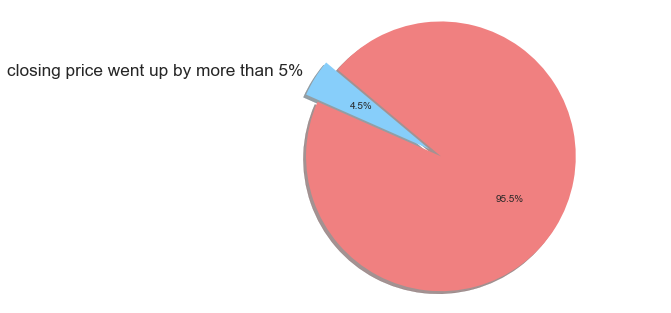

In [77]:
# Data to plot
labels = 'closing price went up by more than 5%', ''
sizes = [sum(y), len(y)-sum(y)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

The dataset is unbalanced. We need first naively try to train our models on the unbalanced dataset and the try to deal with the unbalanceness and compare the results.

### Methology

We train each model over some range of its hyper parameter (ex: n_neighbors for KNN), compute the custom score based on the predicted probabilities for each hyper parameter and take the best hyper parameter (the one giving the smaller score) for each model. We then compare the models and choose the best one (with smallest best score).

### Baseline

In [78]:
# making scorer function according to description (low score is better)
def custom_scorer(y, y_pred):
    scores = []
    for value,pred in zip(y, y_pred):
        if value: scores.append(2*(1-pred))
        else: scores.append(pred)
    return np.mean(scores)*100

In [79]:
P9_scores = {}
P9_scores['Baseline'] = custom_scorer(y_test, np.full_like(y_test, 0))

print("Score on the test set is equal to: ", P9_scores['Baseline'])

Score on the test set is equal to:  9.020217729393467


### KNN

In [80]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(1.0, 60.0, 20)])
model     = KNeighborsClassifier(n_jobs=-1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [81]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for k in K_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(n_neighbors= k)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

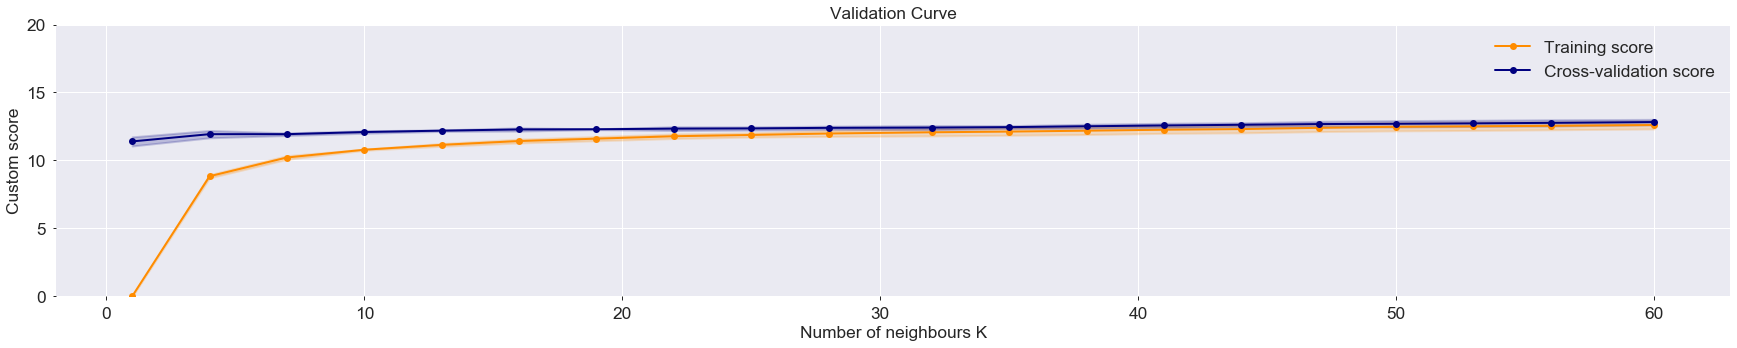

In [82]:
# Plot a validation curve across levels of K

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      K_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=False, ylim = [0,20])

In [83]:
# Obtain the best value of the hyper parameter
cv_scores_mean_KNN = np.mean(cv_scores, axis=1)
best_K_value = K_values[np.argmin(cv_scores_mean_KNN)]
print("Best value for the parameter K =", best_K_value)

Best value for the parameter K = 1


But we see that K = 1 has high variance and will overfit the data. So we take best_K_value = 10

In [84]:
# Calculate Accuracy of KNN Model on test set at best value of K
KNN = KNeighborsClassifier(n_neighbors = 10, n_jobs=-1)
KNN.fit(X_train, y_train)
y_hat_KNN_prob = KNN.predict_proba(X_test)[:,1]

In [85]:
P9_scores['KNN'] = custom_scorer(y_test, y_hat_KNN_prob)
print("Custom score on the test set is equal to: ", P9_scores['KNN'])
print("Accuracy on the test set is equal to: ", KNN.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_KNN_prob))

Custom score on the test set is equal to:  12.130637636080872
Accuracy on the test set is equal to:  0.9548989113530326
Area under curve is equal to:  0.6523362911378187


### Random Forest

In [86]:
# Use a Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(1.0, 40.0, 20)])
model     = RandomForestClassifier(n_jobs=-1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [87]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for n in N_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(n_estimators= n)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

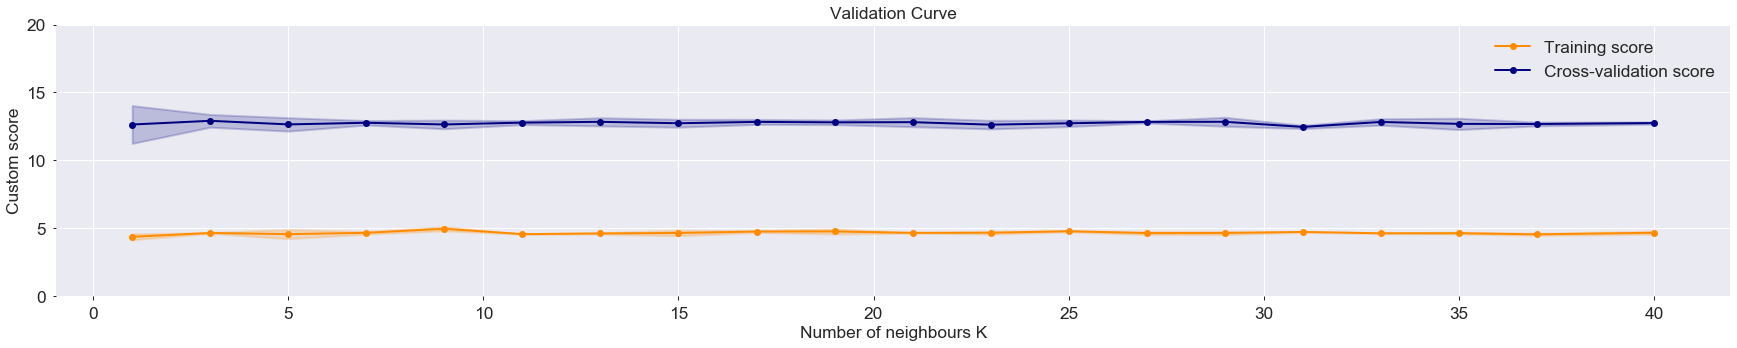

In [88]:
# Plot a validation curve across levels of K

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      N_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=False, ylim = [0,20])

In [89]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_N_value = N_values[np.argmin(cv_scores_mean)]
print("Best value for the parameter N = ", best_N_value)

Best value for the parameter N =  31


But N = 1 will overfit the data. So we take best_N_value = 20.

In [90]:
# Calculate Accuracy of Random Forest Model on test set at best value of N
RF = RandomForestClassifier(n_estimators = 20, n_jobs=-1)
RF.fit(X_train, y_train)
y_hat_RF_prob = RF.predict_proba(X_test)[:,1]

In [91]:
P9_scores['Random Forest'] = custom_scorer(y_test, y_hat_RF_prob)
print("Custom score on the test set is equal to: ", P9_scores['Random Forest'])
print("Accuracy on the test set is equal to: ", RF.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_RF_prob))

Custom score on the test set is equal to:  12.752721617418352
Accuracy on the test set is equal to:  0.9548989113530326
Area under curve is equal to:  0.6521116477591823


### Regularized logistic regression

In [92]:
# Define model
C_values = np.logspace(-10, 10, num=21, endpoint=True, base=10.0)
model = LogisticRegression()
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [93]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for c in C_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(C= c)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

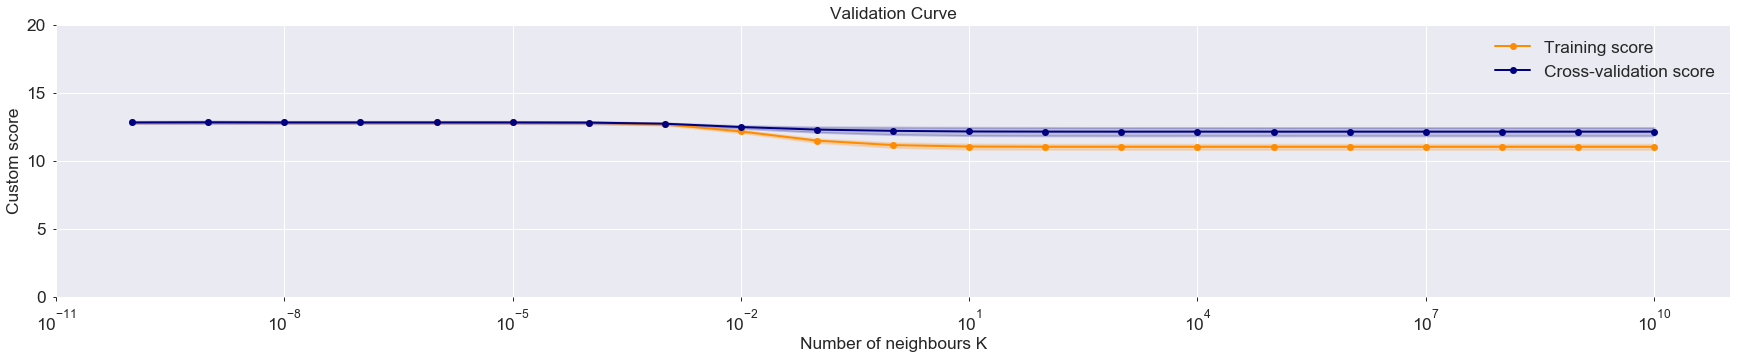

In [94]:
# Plot a validation curve across levels of C, using a logscale for the x axis

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      C_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=True, ylim = [0,20])

In [95]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_C_value = C_values[np.argmin(cv_scores_mean)]
print("Best value for the parameter C = ", best_C_value)

Best value for the parameter C =  100000.0


But a high C would minimize the importance of the features so we take C=10 as the score is pretty much constant from C=10.

In [96]:
# Calculate Accuracy of Regularized Logit Model on test set at best value of C
LR = LogisticRegression(C = 10, n_jobs=-1)
LR.fit(X_train, y_train)
y_hat_logit = LR.predict(X_test)
y_hat_logit_prob = LR.predict_proba(X_test)[:,1]

In [97]:
P9_scores['Logit'] = custom_scorer(y_test, y_hat_logit_prob)
print("Custom score on the test set is equal to: ", P9_scores['Logit'])
print("Accuracy on the test set is equal to: ", LR.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_logit_prob))

Custom score on the test set is equal to:  12.661648030586484
Accuracy on the test set is equal to:  0.9471228615863142
Area under curve is equal to:  0.6736493316859486


### Models comparison

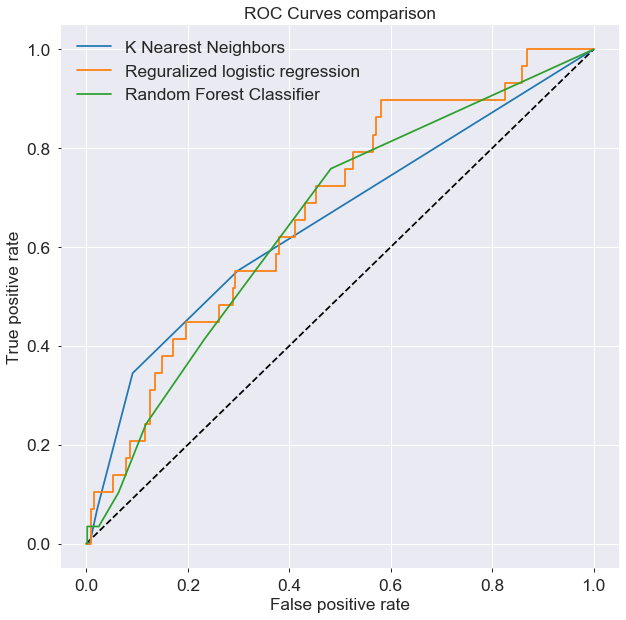

In [98]:
(fpr1, tpr1, thresholds1), model1 = roc_curve(y_test, y_hat_KNN_prob),'K Nearest Neighbors'
(fpr2, tpr2, thresholds2), model2 = roc_curve(y_test, y_hat_logit_prob), 'Reguralized logistic regression'
(fpr3, tpr3, thresholds3), model3 = roc_curve(y_test, y_hat_RF_prob), 'Random Forest Classifier'
plot_3rocs(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, model1, model2, model3)

It looks like the Logit Classifier is the best performing model.

## Balanced Random Forest

In [99]:
# Use a Balanced Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(1.0, 60.0, 20)])
model     = BalancedRandomForestClassifier(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [100]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for n in N_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(n_estimators= n)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

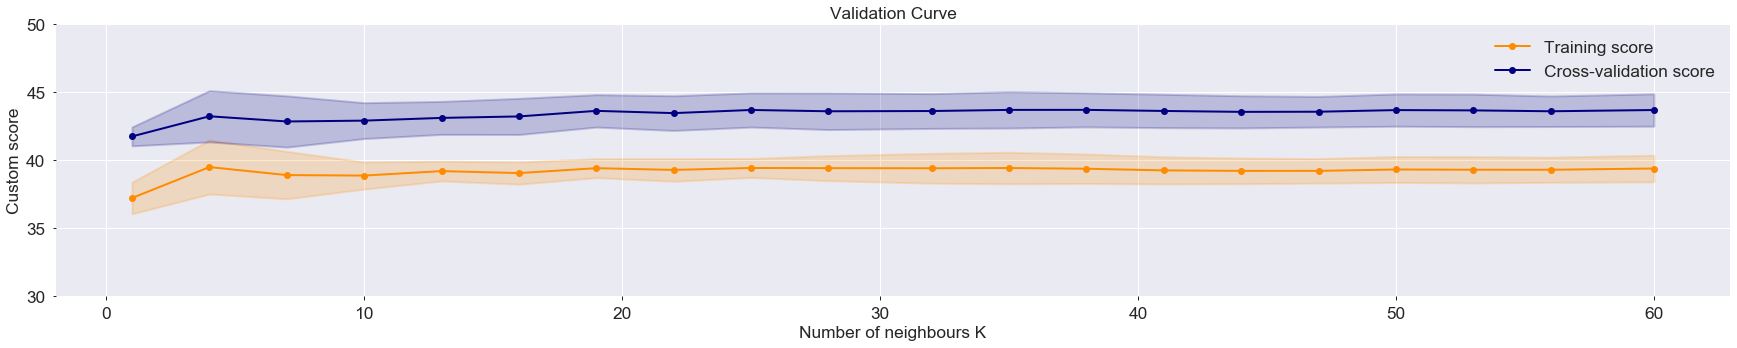

In [101]:
# Plot a validation curve across levels of N

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      N_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=False, ylim = [30,50])


In [102]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_N_value = N_values[np.argmin(cv_scores_mean)]
print("Best value for the parameter N = ", best_N_value)

Best value for the parameter N =  1


In [103]:
# Calculate Accuracy of Random Forest Model on test set at best value of N
imRF = BalancedRandomForestClassifier(n_estimators = 10, n_jobs=-1, random_state=SEED)
imRF.fit(X_train, y_train)
y_hat_imRF_prob = imRF.predict_proba(X_test)[:,1]

In [104]:
P9_scores['Balanced Random Forest'] = custom_scorer(y_test, y_hat_imRF_prob)
print("Custom score on the test set is equal to: ", P9_scores['Balanced Random Forest'])
print("Accuracy on the test set is equal to: ", imRF.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_imRF_prob))

Custom score on the test set is equal to:  43.2919145229248
Accuracy on the test set is equal to:  0.6531881804043546
Area under curve is equal to:  0.6521116477591823


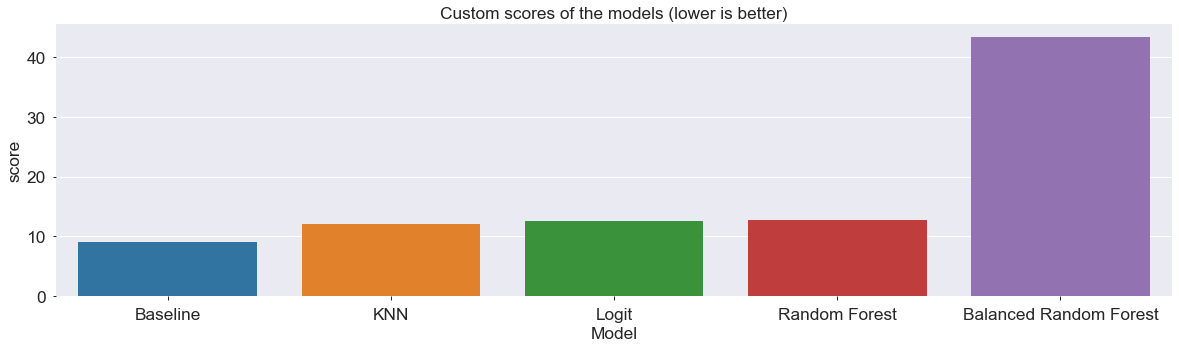

In [105]:
plt.figure(figsize=(20,5))
sns.barplot(x='index', y=0, data=pd.Series(P9_scores).reset_index().sort_values(by=0))
plt.title('Custom scores of the models (lower is better)')
plt.xlabel('Model')
plt.ylabel('score')
plt.show()

Now we will try to deal with the unbalanceness of the data by oversampling i.e. creating similar (in the neighborhood of existing) minority class feature points. We don't subsample as we won't have enough data to train on.

In [106]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X_train, y_train)

### Is our data set balanced ?

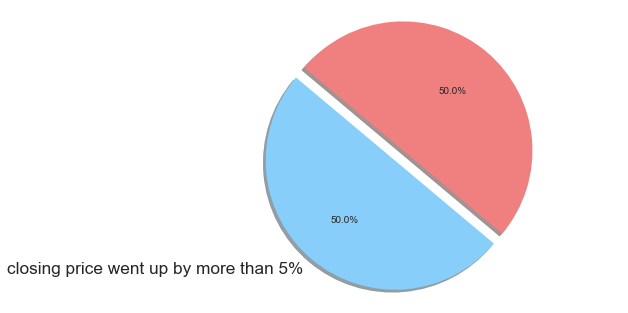

In [107]:
# Data to plot
labels = 'closing price went up by more than 5%', ''
sizes = [sum(y_res), len(y_res)-sum(y_res)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [108]:
X_train = X_res
y_train = y_res

The dataset is quite balanced. We can continue with the models.

### Baseline

In [109]:
P9_scores_res = {}
P9_scores_res['Baseline'] = custom_scorer(y_test, np.full_like(y_test, 0))

print("Score on the test set is equal to: ", P9_scores_res['Baseline'])

Score on the test set is equal to:  9.020217729393467


### KNN

In [110]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(5.0, 100.0, 20)])
model     = KNeighborsClassifier(n_jobs=-1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [111]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for k in K_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(n_neighbors= k)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

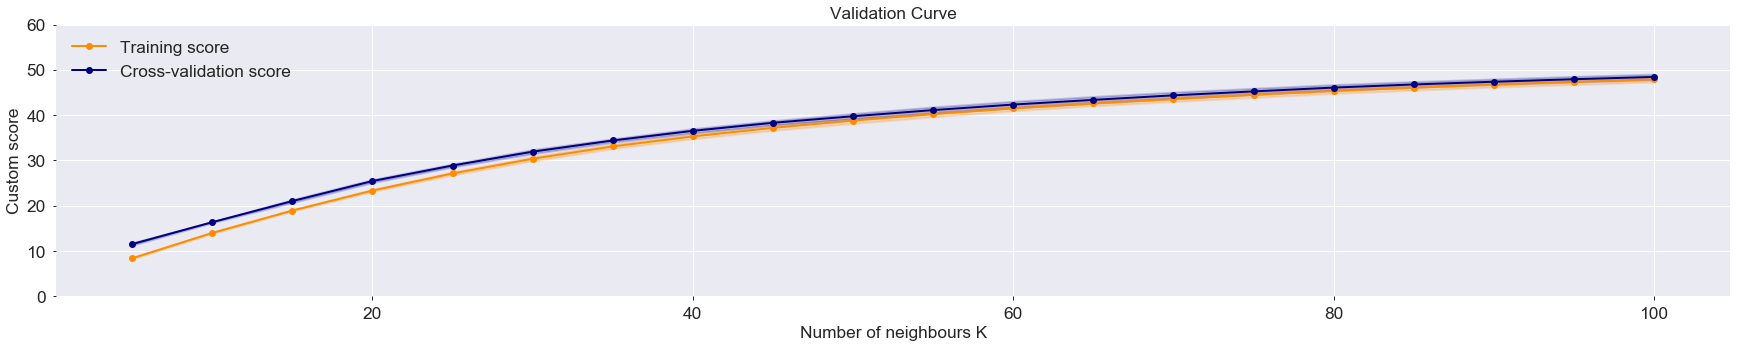

In [112]:
# Plot a validation curve across levels of K

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      K_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=False, ylim = [0,60])

In [113]:
# Obtain the best value of the hyper parameter
cv_scores_mean_KNN = np.mean(cv_scores, axis=1)
best_K_value = K_values[np.argmin(cv_scores_mean_KNN)]
print("Best value for the parameter K =", best_K_value)

Best value for the parameter K = 5


In [114]:
# Calculate Accuracy of KNN Model on test set at best value of K
KNN = KNeighborsClassifier(n_neighbors = best_K_value, n_jobs=-1)
KNN.fit(X_train, y_train)
y_hat_KNN_prob = KNN.predict_proba(X_test)[:,1]

In [115]:
P9_scores_res['KNN'] = custom_scorer(y_test, y_hat_KNN_prob)
print("Custom score on the test set is equal to: ", P9_scores_res['KNN'])
print("Accuracy on the test set is equal to: ", KNN.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_KNN_prob))

Custom score on the test set is equal to:  24.261275272161743
Accuracy on the test set is equal to:  0.7993779160186625
Area under curve is equal to:  0.6204650117937776


### Random Forest

In [116]:
# Use a Random Forest Classifier to predict labels

N_values  = np.array([int(i) for i in np.linspace(1.0, 40.0, 20)])
model     = RandomForestClassifier(n_jobs=-1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [117]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for n in N_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(n_estimators= n)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

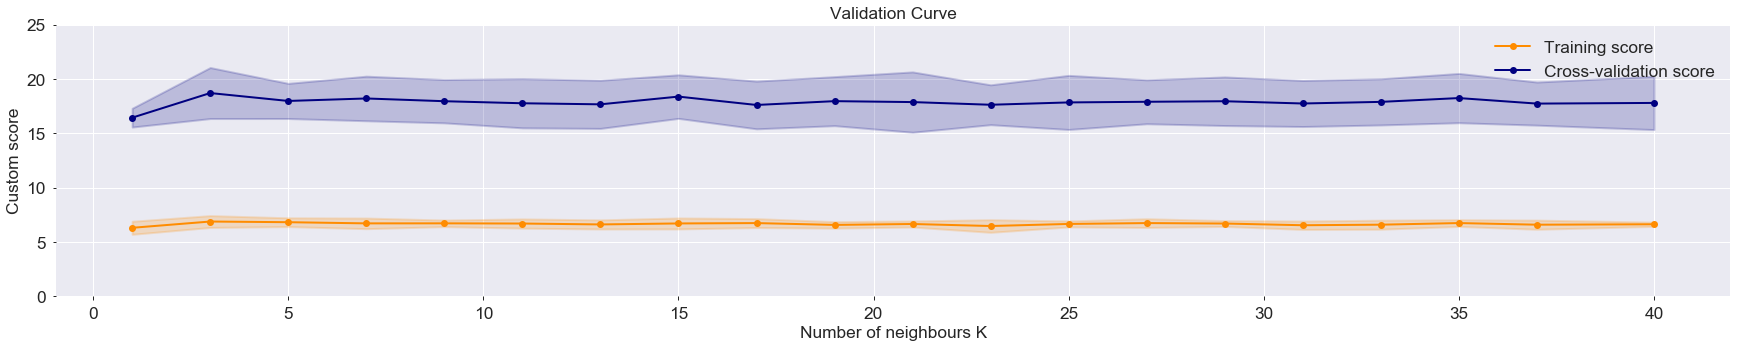

In [118]:
# Plot a validation curve across levels of N

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      N_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=False, ylim = [0,25])


In [119]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_N_value = N_values[np.argmin(cv_scores_mean)]
print("Best value for the parameter N = ", best_N_value)

Best value for the parameter N =  1


In [120]:
# Calculate Accuracy of Random Forest Model on test set at best value of N
RF = RandomForestClassifier(n_estimators = best_N_value, n_jobs=-1)
RF.fit(X_train, y_train)
y_hat_RF_prob = RF.predict_proba(X_test)[:,1]

In [121]:
P9_scores_res['Random Forest'] = custom_scorer(y_test, y_hat_RF_prob)
print("Custom score on the test set is equal to: ", P9_scores_res['Random Forest'])
print("Accuracy on the test set is equal to: ", RF.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_RF_prob))

Custom score on the test set is equal to:  16.018662519440124
Accuracy on the test set is equal to:  0.8740279937791602
Area under curve is equal to:  0.5726440525665506


### Regularized logistic regression

In [122]:
# Define model
C_values = np.logspace(-20, 10, num=21, endpoint=True, base=10.0)
model = LogisticRegression()
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [123]:
# we crossvalidate to find the best hyperparameter

cv_scores = []
train_scores = []

for c in C_values:
    inter_cv_score = []
    inter_train_score = []
    for train_index, cv_index in cv_schema.split(X_train, y_train):
        model.set_params(C= c)
        model.fit(X_train[train_index], y_train[train_index])
        
        cv_prediction = model.predict_proba(X_train[cv_index])
        cv_pred1 = cv_prediction[:,1]
        inter_cv_score.append(custom_scorer(y_train[cv_index], cv_pred1))
        
        train_prediction = model.predict_proba(X_train[train_index])
        train_pred1 = train_prediction[:,1]
        inter_train_score.append(custom_scorer(y_train[train_index], train_pred1))
        
    cv_scores.append(inter_cv_score)
    train_scores.append(inter_train_score)

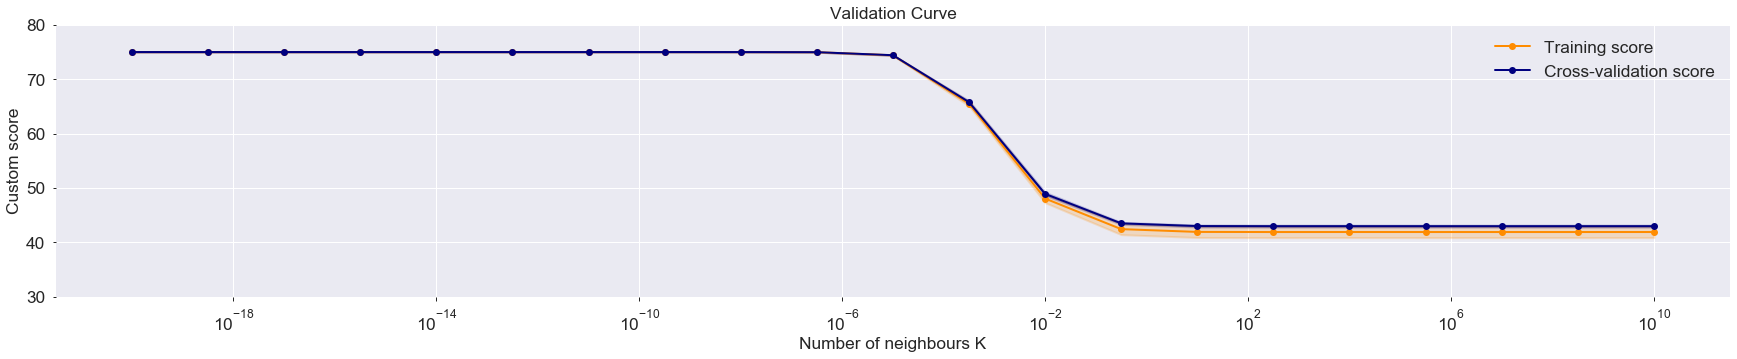

In [124]:
# Plot a validation curve across levels of C, using a logscale for the x axis

plt.figure(figsize=(30,5))
plot_validation_curve(train_scores, cv_scores, \
                      C_values, y_label='Custom score', \
                      x_label='Number of neighbours K', x_logscale=True, ylim = [30,80])

In [125]:
# Obtain the best value of the hyper parameter
cv_scores_mean = np.mean(cv_scores, axis=1)
best_C_value = C_values[np.argmin(cv_scores_mean)]
print("Best value for the parameter C = ", best_C_value)

Best value for the parameter C =  316227766.01683795


In [126]:
# Calculate Accuracy of Regularized Logit Model on test set at best value of C
LR = LogisticRegression(C = 100, n_jobs=-1)
LR.fit(X_train, y_train)
y_hat_logit = LR.predict(X_test)
y_hat_logit_prob = LR.predict_proba(X_test)[:,1]

In [127]:
P9_scores_res['Logit'] = custom_scorer(y_test, y_hat_logit_prob)
print("Custom score on the test set is equal to: ", P9_scores_res['Logit'])
print("Accuracy on the test set is equal to: ", LR.score(X_test, y_test))
print("Area under curve is equal to: ", roc_auc_score(y_test, y_hat_logit_prob))

Custom score on the test set is equal to:  32.34594454729473
Accuracy on the test set is equal to:  0.7340590979782271
Area under curve is equal to:  0.6725822756374256


### Models comparison

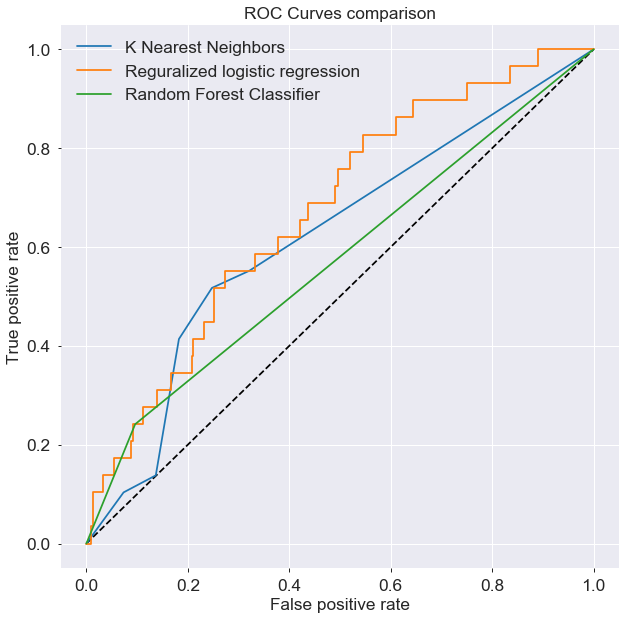

In [128]:
(fpr1, tpr1, thresholds1), model1 = roc_curve(y_test, y_hat_KNN_prob),'K Nearest Neighbors'
(fpr2, tpr2, thresholds2), model2 = roc_curve(y_test, y_hat_logit_prob), 'Reguralized logistic regression'
(fpr3, tpr3, thresholds3), model3 = roc_curve(y_test, y_hat_RF_prob), 'Random Forest Classifier'
plot_3rocs(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, model1, model2, model3)

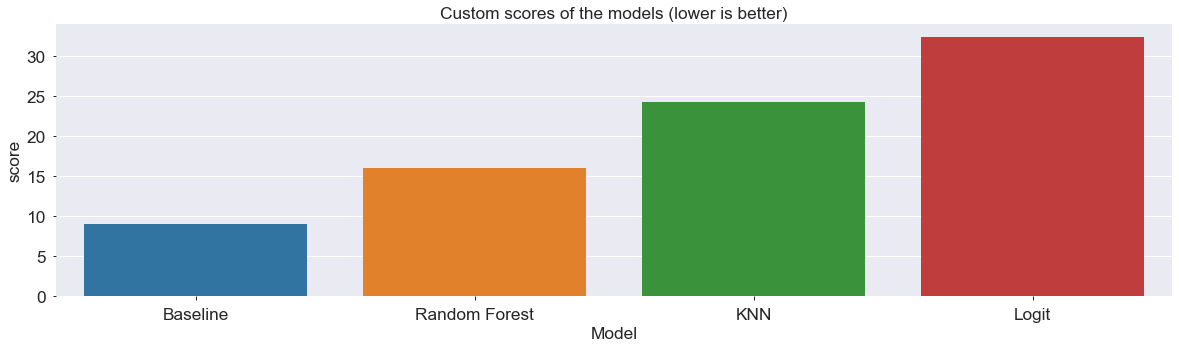

In [129]:
plt.figure(figsize=(20,5))
sns.barplot(x='index', y=0, data=pd.Series(P9_scores_res).reset_index().sort_values(by=0))
plt.title('Custom scores of the models (lower is better)')
plt.xlabel('Model')
plt.ylabel('score')
plt.show()

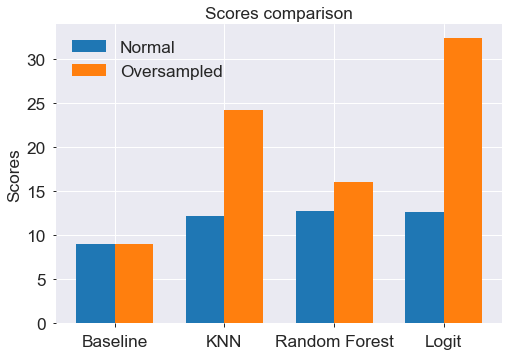

In [131]:
# comparing both approaches
x = np.arange(4)  # the label locations\n",
width = 0.35
fig, ax = plt.subplots()
del P9_scores['Balanced Random Forest']
rects1 = ax.bar(x - width/2, P9_scores.values(), width, label='Normal')
rects2 = ax.bar(x + width/2, P9_scores_res.values(), width, label='Oversampled')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores comparison')
ax.set_xticks(x)
ax.set_xticklabels(P9_scores.keys())
ax.legend();

### Predict P9

In [132]:
# Prepare the dataset to learn from
y = np.array(data_to_learn['closeDay1'] < data_to_learn['offerPrice']*0.9)

# We use all of the features available
X = np.array(data_to_learn.drop(['closeDay1'],axis=1))

In [133]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [134]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

In [135]:
# Calculate Accuracy of KNN Model on test set at best value of K
KNN = KNeighborsClassifier(n_neighbors = 10, n_jobs=-1)
KNN.fit(X_train, y_train)
y_hat_KNN_prob = KNN.predict_proba(X_test)[:,1]

In [136]:
# predict P8
FEATURES = data_to_learn.drop(['closeDay1'], axis=1).columns

X_to_predict = np.array(data_to_predict[FEATURES])
X_to_predict = scaler.transform(X_to_predict)

pd.to_pickle(pd.Series(KNN.predict_proba(X_to_predict)[:,1]), 'P9.pkl')

# Export Excel

In [137]:
IPO_data_to_predict = pd.read_excel('IPO_data_to_predict.xlsx')

In [138]:
IPO_data_to_predict.head(1)

Unnamed: 0  offerPrice                                                 rf  \
0        2750        17.0  RISK FACTORS Before you invest in our common s...   

     egc   html  patRatio      city     issuer  highTech  age exchange  year  \
0  False  False  0.131579  SAN JOSE  PCTEL Inc      True  5.0    NASDQ  1999   

                                         industryFF5  \
0  Business Equipment, Telephone and Television T...   

                                        industryFF12       industryFF48  \
0  Business Equipment -- Computers, Software, and...  Business Services   

   nUnderwriters  sharesOfferedPerc  totalProceeds  \
0             13              29.48       78200000   

                          manager  investmentReceived  amountOnProspectus  \
0  Banc of America Securities LLC                 NaN                78.2   

   commonEquity  sp2weeksBefore  nasdaq2weeksBefore  dj2weeksBefore  blueSky  \
0         0.241         1304.59             2795.97        10401.22  15000.0   

   managementFee  commonEquity.1  bookValue  totalAssets  totalRevenue  \
0      1104000.0           100.0  104.27832      130.605        76.293   

   netIncome       roa  leverage     vc     pe  prominence  nVCs  nExecutives  \
0      5.422  0.041514       0.0  False  False           0   NaN          NaN   

   priorFinancing  ipoSize  reputationLeadMax  reputationLeadAvg  \
0             NaN      NaN              8.001              8.001   

   reputationSum  reputationAvg  nPatents  P1  P2  P3  P4  P5  P6  P7  P8  P9  
0          75.01           5.77         6 NaN NaN NaN NaN NaN NaN NaN NaN NaN

In [139]:
IPO_data_to_predict.P1 = pd.read_pickle('P1.pkl')
IPO_data_to_predict.P2 = pd.read_pickle('P2.pkl')
IPO_data_to_predict.P3 = pd.read_pickle('P3.pkl')
IPO_data_to_predict.P4 = pd.read_pickle('P4.pkl')
IPO_data_to_predict.P5 = pd.read_pickle('P5.pkl')
IPO_data_to_predict.P6 = pd.read_pickle('P6.pkl')
IPO_data_to_predict.P7 = pd.read_pickle('P7.pkl')
IPO_data_to_predict.P8 = pd.read_pickle('P8.pkl')
IPO_data_to_predict.P9 = pd.read_pickle('P9.pkl')

In [140]:
IPO_data_to_predict.to_excel('IPO_data_to_predict.xlsx')